Dataset from [here](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).

importing Libraries 

In [2]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from tqdm import tqdm


**Preprocessing the audio waves**

#Resampling 
#Removing shorter commands of less than 1 second/n
#Let us define these pre-processing steps in the below code snippet:

In [3]:
# All samples
labels = [    'left', 'cat', 'wow', 'six', 'go', 'one', 'dog', 'nine', 'sheila', 'yes',
    'down', 'bird', 'tree', 'up', 'eight', 'bed', 'three', 'on', 'house',
    'five', 'seven', 'zero', 'right', 'four', 'no', 'two', 'off', 'happy',   'stop', 'marvin']


In [4]:
train_audio_path = 'C:/Users/Hamza pc/Downloads/tensorflow-speech-recognition-challenge/SpeechData/train/audio'

all_wave = []
all_label = []
for label in tqdm(labels):
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

100%|██████████| 30/30 [47:35<00:00, 72.61s/it]  


Here we convert the output labels to integer encoded and convert the integer encoded labels to a one-hot vector

In [6]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

label_enconder = LabelEncoder()
y = label_enconder.fit_transform(all_label)
classes = list(label_enconder.classes_)
y = tf.keras.utils.to_categorical(y, num_classes=len(labels))

Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:

In [7]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [27]:
print(all_wave.shape)

(58252, 8000, 1)


**Split into train and validation set**

Next, we will train the model on 80% of the data and validate on the remaining 20%:


In [9]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

**Model Architecture**

In [23]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import GRU

In [24]:
model = models.Sequential()


#Input Layer With  Batchnormalization 

model.add(layers.BatchNormalization(axis=-1, input_shape=(8000,1),momentum=0.99, epsilon=1e-3, center=True, scale=True,))

#First Conv1D layer

model.add(layers.Conv1D(8,13, activation='relu',padding='valid', strides=1))
model.add(layers.MaxPooling1D(pool_size=3))
model.add(layers.Dropout(0.3))


#Second Conv1D layer

model.add(layers.Conv1D(16, 11,activation='relu', padding='valid', strides=1))
model.add(layers.MaxPooling1D(pool_size=3))
model.add(layers.Dropout(0.3))

#Third Conv1D layer
model.add(layers.Conv1D(32, 9, activation='relu',padding='valid', strides=1))
model.add(layers.MaxPooling1D(pool_size=3))
model.add(layers.Dropout(0.3))

model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True))

model.add(layers.Bidirectional(GRU(128, return_sequences=True), merge_mode='sum'))
model.add(layers.Bidirectional(GRU(128, return_sequences=True), merge_mode='sum'))
model.add(layers.Bidirectional(GRU(128, return_sequences=False), merge_mode='sum'))

model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True))

#Flatten layer
model.add(layers.Flatten())

#Dense Layer 1
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(30, activation="softmax"))



In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 8000, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0

Define the loss function to be categorical cross-entropy since it is a multi-classification problem:

In [30]:
model.compile(loss='categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])

Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch:

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Callback to save the Keras model or model weights at some frequency.

#Inherits From: Callback

In [33]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=10, min_delta=0.0001)

checkpoint = ModelCheckpoint('speech2text_model.hdf5', monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')

Let us train the model on a batch size of 32 and evaluate the performance on the holdout set:

In [34]:
hist = model.fit(
    x=x_train, 
    y=y_train,
    epochs=100, 
    callbacks=[early_stop, checkpoint], 
    batch_size=32, 
    validation_data=(x_valid,y_valid)
)

Train on 46601 samples, validate on 11651 samples
Epoch 1/100


 5408/46601 [==>...........................] - ETA: 18:34:24 - loss: 3.5117 - accuracy: 0.06 - ETA: 9:55:59 - loss: 3.5744 - accuracy: 0.0469 - ETA: 7:02:56 - loss: 3.5604 - accuracy: 0.041 - ETA: 5:34:45 - loss: 3.5690 - accuracy: 0.031 - ETA: 4:42:13 - loss: 3.5578 - accuracy: 0.043 - ETA: 4:07:23 - loss: 3.5500 - accuracy: 0.046 - ETA: 3:42:23 - loss: 3.5102 - accuracy: 0.058 - ETA: 3:24:18 - loss: 3.5083 - accuracy: 0.058 - ETA: 3:09:35 - loss: 3.5126 - accuracy: 0.055 - ETA: 2:58:30 - loss: 3.5165 - accuracy: 0.056 - ETA: 2:48:37 - loss: 3.5210 - accuracy: 0.054 - ETA: 2:40:35 - loss: 3.5293 - accuracy: 0.049 - ETA: 2:34:19 - loss: 3.5370 - accuracy: 0.045 - ETA: 2:28:26 - loss: 3.5376 - accuracy: 0.044 - ETA: 2:23:15 - loss: 3.5201 - accuracy: 0.041 - ETA: 2:18:39 - loss: 3.5265 - accuracy: 0.041 - ETA: 2:14:36 - loss: 3.5236 - accuracy: 0.044 - ETA: 2:11:07 - loss: 3.5250 - accuracy: 0.041 - ETA: 2:08:05 - loss: 3.5193 - accuracy: 0.041 - ETA: 2:05:09 - loss: 3.5178 - accuracy: 

22240/46601 [=============>................] - ETA: 54:22 - loss: 2.6185 - accuracy: 0.241 - ETA: 54:19 - loss: 2.6160 - accuracy: 0.241 - ETA: 54:14 - loss: 2.6139 - accuracy: 0.242 - ETA: 54:10 - loss: 2.6119 - accuracy: 0.243 - ETA: 54:05 - loss: 2.6099 - accuracy: 0.243 - ETA: 54:01 - loss: 2.6085 - accuracy: 0.244 - ETA: 53:56 - loss: 2.6066 - accuracy: 0.244 - ETA: 53:51 - loss: 2.6045 - accuracy: 0.245 - ETA: 53:47 - loss: 2.6033 - accuracy: 0.245 - ETA: 53:43 - loss: 2.6012 - accuracy: 0.246 - ETA: 53:39 - loss: 2.5983 - accuracy: 0.247 - ETA: 53:34 - loss: 2.5966 - accuracy: 0.247 - ETA: 53:30 - loss: 2.5949 - accuracy: 0.248 - ETA: 53:26 - loss: 2.5931 - accuracy: 0.248 - ETA: 53:23 - loss: 2.5917 - accuracy: 0.248 - ETA: 53:19 - loss: 2.5890 - accuracy: 0.249 - ETA: 53:15 - loss: 2.5875 - accuracy: 0.249 - ETA: 53:10 - loss: 2.5853 - accuracy: 0.250 - ETA: 53:06 - loss: 2.5841 - accuracy: 0.251 - ETA: 53:02 - loss: 2.5816 - accuracy: 0.251 - ETA: 52:58 - loss: 2.5796 - accur

27936/46601 [================>.............] - ETA: 42:31 - loss: 2.3187 - accuracy: 0.322 - ETA: 42:27 - loss: 2.3171 - accuracy: 0.322 - ETA: 42:23 - loss: 2.3155 - accuracy: 0.323 - ETA: 42:19 - loss: 2.3146 - accuracy: 0.323 - ETA: 42:15 - loss: 2.3129 - accuracy: 0.323 - ETA: 42:11 - loss: 2.3112 - accuracy: 0.324 - ETA: 42:08 - loss: 2.3094 - accuracy: 0.324 - ETA: 42:04 - loss: 2.3078 - accuracy: 0.325 - ETA: 42:00 - loss: 2.3057 - accuracy: 0.325 - ETA: 41:56 - loss: 2.3040 - accuracy: 0.326 - ETA: 41:53 - loss: 2.3024 - accuracy: 0.326 - ETA: 41:49 - loss: 2.3007 - accuracy: 0.327 - ETA: 41:46 - loss: 2.2992 - accuracy: 0.327 - ETA: 41:42 - loss: 2.2978 - accuracy: 0.328 - ETA: 41:38 - loss: 2.2963 - accuracy: 0.328 - ETA: 41:34 - loss: 2.2946 - accuracy: 0.329 - ETA: 41:30 - loss: 2.2936 - accuracy: 0.329 - ETA: 41:26 - loss: 2.2921 - accuracy: 0.329 - ETA: 41:23 - loss: 2.2912 - accuracy: 0.330 - ETA: 41:19 - loss: 2.2901 - accuracy: 0.330 - ETA: 41:15 - loss: 2.2883 - accur

33632/46601 [====================>.........] - ETA: 31:59 - loss: 2.0960 - accuracy: 0.385 - ETA: 31:55 - loss: 2.0952 - accuracy: 0.385 - ETA: 31:52 - loss: 2.0939 - accuracy: 0.385 - ETA: 31:48 - loss: 2.0925 - accuracy: 0.386 - ETA: 31:45 - loss: 2.0913 - accuracy: 0.386 - ETA: 31:43 - loss: 2.0900 - accuracy: 0.386 - ETA: 31:40 - loss: 2.0893 - accuracy: 0.387 - ETA: 31:36 - loss: 2.0878 - accuracy: 0.387 - ETA: 31:33 - loss: 2.0865 - accuracy: 0.388 - ETA: 31:29 - loss: 2.0857 - accuracy: 0.388 - ETA: 31:26 - loss: 2.0842 - accuracy: 0.388 - ETA: 31:23 - loss: 2.0833 - accuracy: 0.388 - ETA: 31:19 - loss: 2.0825 - accuracy: 0.389 - ETA: 31:16 - loss: 2.0815 - accuracy: 0.389 - ETA: 31:12 - loss: 2.0804 - accuracy: 0.389 - ETA: 31:09 - loss: 2.0791 - accuracy: 0.390 - ETA: 31:06 - loss: 2.0782 - accuracy: 0.390 - ETA: 31:02 - loss: 2.0769 - accuracy: 0.390 - ETA: 30:59 - loss: 2.0757 - accuracy: 0.391 - ETA: 30:55 - loss: 2.0745 - accuracy: 0.391 - ETA: 30:52 - loss: 2.0732 - accur

39328/46601 [========================>.....] - ETA: 21:56 - loss: 1.9281 - accuracy: 0.434 - ETA: 21:53 - loss: 1.9271 - accuracy: 0.434 - ETA: 21:49 - loss: 1.9262 - accuracy: 0.434 - ETA: 21:46 - loss: 1.9255 - accuracy: 0.434 - ETA: 21:43 - loss: 1.9248 - accuracy: 0.435 - ETA: 21:39 - loss: 1.9239 - accuracy: 0.435 - ETA: 21:36 - loss: 1.9230 - accuracy: 0.435 - ETA: 21:33 - loss: 1.9225 - accuracy: 0.435 - ETA: 21:29 - loss: 1.9214 - accuracy: 0.436 - ETA: 21:26 - loss: 1.9204 - accuracy: 0.436 - ETA: 21:23 - loss: 1.9199 - accuracy: 0.436 - ETA: 21:19 - loss: 1.9186 - accuracy: 0.437 - ETA: 21:16 - loss: 1.9177 - accuracy: 0.437 - ETA: 21:13 - loss: 1.9166 - accuracy: 0.437 - ETA: 21:09 - loss: 1.9154 - accuracy: 0.437 - ETA: 21:06 - loss: 1.9149 - accuracy: 0.438 - ETA: 21:03 - loss: 1.9142 - accuracy: 0.438 - ETA: 20:59 - loss: 1.9131 - accuracy: 0.438 - ETA: 20:56 - loss: 1.9126 - accuracy: 0.438 - ETA: 20:53 - loss: 1.9119 - accuracy: 0.438 - ETA: 20:49 - loss: 1.9115 - accur

45216/46601 [============================>.] - ETA: 12:09 - loss: 1.7849 - accuracy: 0.474 - ETA: 12:06 - loss: 1.7843 - accuracy: 0.474 - ETA: 12:03 - loss: 1.7836 - accuracy: 0.474 - ETA: 11:59 - loss: 1.7827 - accuracy: 0.475 - ETA: 11:56 - loss: 1.7817 - accuracy: 0.475 - ETA: 11:53 - loss: 1.7811 - accuracy: 0.475 - ETA: 11:50 - loss: 1.7804 - accuracy: 0.475 - ETA: 11:46 - loss: 1.7798 - accuracy: 0.475 - ETA: 11:43 - loss: 1.7789 - accuracy: 0.476 - ETA: 11:40 - loss: 1.7781 - accuracy: 0.476 - ETA: 11:37 - loss: 1.7777 - accuracy: 0.476 - ETA: 11:33 - loss: 1.7769 - accuracy: 0.476 - ETA: 11:30 - loss: 1.7761 - accuracy: 0.476 - ETA: 11:27 - loss: 1.7756 - accuracy: 0.477 - ETA: 11:23 - loss: 1.7746 - accuracy: 0.477 - ETA: 11:20 - loss: 1.7740 - accuracy: 0.477 - ETA: 11:17 - loss: 1.7731 - accuracy: 0.477 - ETA: 11:14 - loss: 1.7726 - accuracy: 0.477 - ETA: 11:10 - loss: 1.7716 - accuracy: 0.478 - ETA: 11:07 - loss: 1.7707 - accuracy: 0.478 - ETA: 11:04 - loss: 1.7702 - accur

46601/46601 [==============================] - 4900s 105ms/sample - loss: 1.6369 - accuracy: 0.5173 - val_loss: 0.9806 - val_accuracy: 0.7085
Epoch 2/100


 5440/46601 [==>...........................] - ETA: 1:13:20 - loss: 0.7050 - accuracy: 0.812 - ETA: 1:17:29 - loss: 0.5911 - accuracy: 0.828 - ETA: 1:13:19 - loss: 0.5277 - accuracy: 0.854 - ETA: 1:15:04 - loss: 0.6164 - accuracy: 0.820 - ETA: 1:14:50 - loss: 0.6992 - accuracy: 0.768 - ETA: 1:13:32 - loss: 0.7118 - accuracy: 0.770 - ETA: 1:13:20 - loss: 0.7149 - accuracy: 0.763 - ETA: 1:13:13 - loss: 0.7402 - accuracy: 0.757 - ETA: 1:13:50 - loss: 0.7739 - accuracy: 0.746 - ETA: 1:13:55 - loss: 0.7908 - accuracy: 0.737 - ETA: 1:14:06 - loss: 0.7839 - accuracy: 0.741 - ETA: 1:13:32 - loss: 0.7775 - accuracy: 0.739 - ETA: 1:12:57 - loss: 0.7495 - accuracy: 0.752 - ETA: 1:12:29 - loss: 0.7562 - accuracy: 0.752 - ETA: 1:13:09 - loss: 0.7358 - accuracy: 0.760 - ETA: 1:13:21 - loss: 0.7179 - accuracy: 0.763 - ETA: 1:12:50 - loss: 0.7401 - accuracy: 0.757 - ETA: 1:12:29 - loss: 0.7355 - accuracy: 0.758 - ETA: 1:12:36 - loss: 0.7366 - accuracy: 0.758 - ETA: 1:12:17 - loss: 0.7249 - accuracy: 0

22368/46601 [=============>................] - ETA: 47:46 - loss: 0.6682 - accuracy: 0.798 - ETA: 47:43 - loss: 0.6678 - accuracy: 0.798 - ETA: 47:40 - loss: 0.6674 - accuracy: 0.798 - ETA: 47:36 - loss: 0.6673 - accuracy: 0.798 - ETA: 47:34 - loss: 0.6666 - accuracy: 0.798 - ETA: 47:31 - loss: 0.6662 - accuracy: 0.798 - ETA: 47:28 - loss: 0.6667 - accuracy: 0.798 - ETA: 47:25 - loss: 0.6672 - accuracy: 0.798 - ETA: 47:21 - loss: 0.6683 - accuracy: 0.797 - ETA: 47:19 - loss: 0.6678 - accuracy: 0.798 - ETA: 47:16 - loss: 0.6682 - accuracy: 0.798 - ETA: 47:13 - loss: 0.6680 - accuracy: 0.798 - ETA: 47:11 - loss: 0.6682 - accuracy: 0.797 - ETA: 47:08 - loss: 0.6684 - accuracy: 0.798 - ETA: 47:05 - loss: 0.6683 - accuracy: 0.797 - ETA: 47:03 - loss: 0.6683 - accuracy: 0.798 - ETA: 46:59 - loss: 0.6686 - accuracy: 0.797 - ETA: 46:57 - loss: 0.6683 - accuracy: 0.797 - ETA: 46:54 - loss: 0.6684 - accuracy: 0.797 - ETA: 46:51 - loss: 0.6690 - accuracy: 0.797 - ETA: 46:48 - loss: 0.6689 - accur

28064/46601 [=================>............] - ETA: 39:13 - loss: 0.6480 - accuracy: 0.803 - ETA: 39:10 - loss: 0.6475 - accuracy: 0.803 - ETA: 39:07 - loss: 0.6472 - accuracy: 0.804 - ETA: 39:04 - loss: 0.6474 - accuracy: 0.803 - ETA: 39:02 - loss: 0.6480 - accuracy: 0.803 - ETA: 38:58 - loss: 0.6475 - accuracy: 0.803 - ETA: 38:55 - loss: 0.6474 - accuracy: 0.804 - ETA: 38:52 - loss: 0.6469 - accuracy: 0.804 - ETA: 38:49 - loss: 0.6470 - accuracy: 0.804 - ETA: 38:46 - loss: 0.6466 - accuracy: 0.804 - ETA: 38:43 - loss: 0.6465 - accuracy: 0.804 - ETA: 38:39 - loss: 0.6462 - accuracy: 0.804 - ETA: 38:37 - loss: 0.6454 - accuracy: 0.804 - ETA: 38:33 - loss: 0.6454 - accuracy: 0.804 - ETA: 38:31 - loss: 0.6454 - accuracy: 0.804 - ETA: 38:28 - loss: 0.6451 - accuracy: 0.804 - ETA: 38:25 - loss: 0.6450 - accuracy: 0.804 - ETA: 38:22 - loss: 0.6451 - accuracy: 0.804 - ETA: 38:18 - loss: 0.6446 - accuracy: 0.804 - ETA: 38:15 - loss: 0.6444 - accuracy: 0.804 - ETA: 38:13 - loss: 0.6446 - accur

33760/46601 [====================>.........] - ETA: 30:14 - loss: 0.6292 - accuracy: 0.809 - ETA: 30:11 - loss: 0.6292 - accuracy: 0.809 - ETA: 30:08 - loss: 0.6294 - accuracy: 0.809 - ETA: 30:05 - loss: 0.6292 - accuracy: 0.810 - ETA: 30:02 - loss: 0.6293 - accuracy: 0.809 - ETA: 29:58 - loss: 0.6292 - accuracy: 0.809 - ETA: 29:55 - loss: 0.6289 - accuracy: 0.809 - ETA: 29:52 - loss: 0.6288 - accuracy: 0.810 - ETA: 29:49 - loss: 0.6286 - accuracy: 0.810 - ETA: 29:46 - loss: 0.6289 - accuracy: 0.810 - ETA: 29:43 - loss: 0.6284 - accuracy: 0.810 - ETA: 29:40 - loss: 0.6286 - accuracy: 0.810 - ETA: 29:37 - loss: 0.6286 - accuracy: 0.810 - ETA: 29:34 - loss: 0.6282 - accuracy: 0.810 - ETA: 29:31 - loss: 0.6281 - accuracy: 0.810 - ETA: 29:27 - loss: 0.6284 - accuracy: 0.810 - ETA: 29:24 - loss: 0.6282 - accuracy: 0.810 - ETA: 29:21 - loss: 0.6280 - accuracy: 0.810 - ETA: 29:18 - loss: 0.6283 - accuracy: 0.810 - ETA: 29:15 - loss: 0.6279 - accuracy: 0.810 - ETA: 29:12 - loss: 0.6277 - accur

39456/46601 [========================>.....] - ETA: 21:02 - loss: 0.6136 - accuracy: 0.814 - ETA: 20:58 - loss: 0.6135 - accuracy: 0.814 - ETA: 20:55 - loss: 0.6132 - accuracy: 0.814 - ETA: 20:52 - loss: 0.6132 - accuracy: 0.814 - ETA: 20:49 - loss: 0.6130 - accuracy: 0.814 - ETA: 20:46 - loss: 0.6129 - accuracy: 0.814 - ETA: 20:43 - loss: 0.6130 - accuracy: 0.814 - ETA: 20:40 - loss: 0.6128 - accuracy: 0.814 - ETA: 20:37 - loss: 0.6126 - accuracy: 0.814 - ETA: 20:34 - loss: 0.6124 - accuracy: 0.814 - ETA: 20:30 - loss: 0.6124 - accuracy: 0.814 - ETA: 20:27 - loss: 0.6122 - accuracy: 0.814 - ETA: 20:24 - loss: 0.6126 - accuracy: 0.814 - ETA: 20:21 - loss: 0.6124 - accuracy: 0.814 - ETA: 20:18 - loss: 0.6123 - accuracy: 0.814 - ETA: 20:15 - loss: 0.6120 - accuracy: 0.814 - ETA: 20:12 - loss: 0.6122 - accuracy: 0.814 - ETA: 20:09 - loss: 0.6123 - accuracy: 0.814 - ETA: 20:06 - loss: 0.6120 - accuracy: 0.814 - ETA: 20:03 - loss: 0.6119 - accuracy: 0.814 - ETA: 20:00 - loss: 0.6119 - accur

45344/46601 [============================>.] - ETA: 11:46 - loss: 0.6018 - accuracy: 0.817 - ETA: 11:43 - loss: 0.6017 - accuracy: 0.817 - ETA: 11:40 - loss: 0.6015 - accuracy: 0.817 - ETA: 11:37 - loss: 0.6013 - accuracy: 0.817 - ETA: 11:34 - loss: 0.6012 - accuracy: 0.817 - ETA: 11:30 - loss: 0.6010 - accuracy: 0.817 - ETA: 11:27 - loss: 0.6009 - accuracy: 0.817 - ETA: 11:24 - loss: 0.6008 - accuracy: 0.817 - ETA: 11:21 - loss: 0.6007 - accuracy: 0.817 - ETA: 11:18 - loss: 0.6004 - accuracy: 0.817 - ETA: 11:15 - loss: 0.6002 - accuracy: 0.817 - ETA: 11:11 - loss: 0.6001 - accuracy: 0.817 - ETA: 11:08 - loss: 0.5999 - accuracy: 0.817 - ETA: 11:05 - loss: 0.5998 - accuracy: 0.817 - ETA: 11:02 - loss: 0.5998 - accuracy: 0.817 - ETA: 10:59 - loss: 0.5997 - accuracy: 0.817 - ETA: 10:56 - loss: 0.5999 - accuracy: 0.817 - ETA: 10:52 - loss: 0.6003 - accuracy: 0.817 - ETA: 10:49 - loss: 0.6002 - accuracy: 0.817 - ETA: 10:46 - loss: 0.6004 - accuracy: 0.817 - ETA: 10:43 - loss: 0.6001 - accur

46601/46601 [==============================] - 4836s 104ms/sample - loss: 0.5872 - accuracy: 0.8219 - val_loss: 0.5383 - val_accuracy: 0.8353
Epoch 3/100


 5440/46601 [==>...........................] - ETA: 1:11:24 - loss: 0.3160 - accuracy: 0.906 - ETA: 1:14:25 - loss: 0.5733 - accuracy: 0.828 - ETA: 1:15:31 - loss: 0.5852 - accuracy: 0.822 - ETA: 1:15:30 - loss: 0.5145 - accuracy: 0.835 - ETA: 1:14:15 - loss: 0.5186 - accuracy: 0.837 - ETA: 1:12:57 - loss: 0.5490 - accuracy: 0.828 - ETA: 1:11:25 - loss: 0.5923 - accuracy: 0.812 - ETA: 1:11:47 - loss: 0.5690 - accuracy: 0.824 - ETA: 1:12:17 - loss: 0.5595 - accuracy: 0.833 - ETA: 1:12:21 - loss: 0.5513 - accuracy: 0.834 - ETA: 1:12:05 - loss: 0.5165 - accuracy: 0.846 - ETA: 1:12:05 - loss: 0.5197 - accuracy: 0.846 - ETA: 1:12:03 - loss: 0.5184 - accuracy: 0.848 - ETA: 1:12:34 - loss: 0.5232 - accuracy: 0.846 - ETA: 1:12:39 - loss: 0.5143 - accuracy: 0.852 - ETA: 1:12:22 - loss: 0.4995 - accuracy: 0.855 - ETA: 1:12:21 - loss: 0.4906 - accuracy: 0.856 - ETA: 1:12:14 - loss: 0.4750 - accuracy: 0.859 - ETA: 1:12:34 - loss: 0.4665 - accuracy: 0.863 - ETA: 1:12:28 - loss: 0.4673 - accuracy: 0

22368/46601 [=============>................] - ETA: 47:36 - loss: 0.4292 - accuracy: 0.870 - ETA: 47:32 - loss: 0.4292 - accuracy: 0.870 - ETA: 47:29 - loss: 0.4294 - accuracy: 0.870 - ETA: 47:27 - loss: 0.4295 - accuracy: 0.870 - ETA: 47:23 - loss: 0.4292 - accuracy: 0.870 - ETA: 47:20 - loss: 0.4289 - accuracy: 0.870 - ETA: 47:17 - loss: 0.4284 - accuracy: 0.870 - ETA: 47:13 - loss: 0.4289 - accuracy: 0.870 - ETA: 47:10 - loss: 0.4291 - accuracy: 0.870 - ETA: 47:07 - loss: 0.4297 - accuracy: 0.870 - ETA: 47:05 - loss: 0.4298 - accuracy: 0.870 - ETA: 47:02 - loss: 0.4296 - accuracy: 0.870 - ETA: 46:59 - loss: 0.4298 - accuracy: 0.870 - ETA: 46:56 - loss: 0.4299 - accuracy: 0.870 - ETA: 46:53 - loss: 0.4299 - accuracy: 0.870 - ETA: 46:51 - loss: 0.4301 - accuracy: 0.870 - ETA: 46:48 - loss: 0.4300 - accuracy: 0.870 - ETA: 46:45 - loss: 0.4301 - accuracy: 0.870 - ETA: 46:42 - loss: 0.4308 - accuracy: 0.870 - ETA: 46:39 - loss: 0.4305 - accuracy: 0.870 - ETA: 46:36 - loss: 0.4298 - accur

28064/46601 [=================>............] - ETA: 38:36 - loss: 0.4264 - accuracy: 0.871 - ETA: 38:33 - loss: 0.4265 - accuracy: 0.871 - ETA: 38:30 - loss: 0.4275 - accuracy: 0.871 - ETA: 38:27 - loss: 0.4273 - accuracy: 0.871 - ETA: 38:24 - loss: 0.4276 - accuracy: 0.871 - ETA: 38:22 - loss: 0.4275 - accuracy: 0.871 - ETA: 38:18 - loss: 0.4272 - accuracy: 0.871 - ETA: 38:15 - loss: 0.4268 - accuracy: 0.871 - ETA: 38:12 - loss: 0.4268 - accuracy: 0.871 - ETA: 38:09 - loss: 0.4267 - accuracy: 0.871 - ETA: 38:07 - loss: 0.4268 - accuracy: 0.871 - ETA: 38:03 - loss: 0.4267 - accuracy: 0.871 - ETA: 38:00 - loss: 0.4265 - accuracy: 0.871 - ETA: 37:57 - loss: 0.4265 - accuracy: 0.871 - ETA: 37:54 - loss: 0.4264 - accuracy: 0.871 - ETA: 37:51 - loss: 0.4263 - accuracy: 0.871 - ETA: 37:48 - loss: 0.4271 - accuracy: 0.871 - ETA: 37:45 - loss: 0.4271 - accuracy: 0.871 - ETA: 37:42 - loss: 0.4272 - accuracy: 0.871 - ETA: 37:39 - loss: 0.4275 - accuracy: 0.871 - ETA: 37:36 - loss: 0.4279 - accur

33760/46601 [====================>.........] - ETA: 29:25 - loss: 0.4216 - accuracy: 0.873 - ETA: 29:22 - loss: 0.4220 - accuracy: 0.873 - ETA: 29:19 - loss: 0.4226 - accuracy: 0.873 - ETA: 29:16 - loss: 0.4223 - accuracy: 0.873 - ETA: 29:13 - loss: 0.4223 - accuracy: 0.873 - ETA: 29:10 - loss: 0.4220 - accuracy: 0.873 - ETA: 29:07 - loss: 0.4219 - accuracy: 0.873 - ETA: 29:04 - loss: 0.4218 - accuracy: 0.873 - ETA: 29:01 - loss: 0.4216 - accuracy: 0.873 - ETA: 28:58 - loss: 0.4217 - accuracy: 0.873 - ETA: 28:54 - loss: 0.4217 - accuracy: 0.873 - ETA: 28:51 - loss: 0.4217 - accuracy: 0.873 - ETA: 28:48 - loss: 0.4217 - accuracy: 0.873 - ETA: 28:45 - loss: 0.4216 - accuracy: 0.873 - ETA: 28:42 - loss: 0.4214 - accuracy: 0.873 - ETA: 28:39 - loss: 0.4211 - accuracy: 0.873 - ETA: 28:36 - loss: 0.4211 - accuracy: 0.873 - ETA: 28:33 - loss: 0.4208 - accuracy: 0.873 - ETA: 28:30 - loss: 0.4211 - accuracy: 0.873 - ETA: 28:27 - loss: 0.4211 - accuracy: 0.873 - ETA: 28:24 - loss: 0.4211 - accur

39456/46601 [========================>.....] - ETA: 20:18 - loss: 0.4196 - accuracy: 0.873 - ETA: 20:15 - loss: 0.4193 - accuracy: 0.874 - ETA: 20:12 - loss: 0.4193 - accuracy: 0.874 - ETA: 20:09 - loss: 0.4192 - accuracy: 0.874 - ETA: 20:06 - loss: 0.4191 - accuracy: 0.874 - ETA: 20:03 - loss: 0.4191 - accuracy: 0.874 - ETA: 20:00 - loss: 0.4193 - accuracy: 0.874 - ETA: 19:56 - loss: 0.4192 - accuracy: 0.874 - ETA: 19:53 - loss: 0.4192 - accuracy: 0.874 - ETA: 19:50 - loss: 0.4194 - accuracy: 0.874 - ETA: 19:47 - loss: 0.4194 - accuracy: 0.874 - ETA: 19:44 - loss: 0.4194 - accuracy: 0.874 - ETA: 19:41 - loss: 0.4199 - accuracy: 0.874 - ETA: 19:38 - loss: 0.4198 - accuracy: 0.874 - ETA: 19:35 - loss: 0.4197 - accuracy: 0.874 - ETA: 19:32 - loss: 0.4197 - accuracy: 0.874 - ETA: 19:29 - loss: 0.4198 - accuracy: 0.874 - ETA: 19:26 - loss: 0.4197 - accuracy: 0.874 - ETA: 19:23 - loss: 0.4197 - accuracy: 0.873 - ETA: 19:20 - loss: 0.4195 - accuracy: 0.874 - ETA: 19:17 - loss: 0.4193 - accur

45344/46601 [============================>.] - ETA: 11:15 - loss: 0.4182 - accuracy: 0.874 - ETA: 11:12 - loss: 0.4184 - accuracy: 0.874 - ETA: 11:09 - loss: 0.4183 - accuracy: 0.874 - ETA: 11:06 - loss: 0.4181 - accuracy: 0.874 - ETA: 11:03 - loss: 0.4181 - accuracy: 0.874 - ETA: 11:00 - loss: 0.4180 - accuracy: 0.874 - ETA: 10:57 - loss: 0.4180 - accuracy: 0.874 - ETA: 10:53 - loss: 0.4178 - accuracy: 0.874 - ETA: 10:50 - loss: 0.4180 - accuracy: 0.874 - ETA: 10:47 - loss: 0.4181 - accuracy: 0.873 - ETA: 10:44 - loss: 0.4179 - accuracy: 0.873 - ETA: 10:41 - loss: 0.4181 - accuracy: 0.873 - ETA: 10:38 - loss: 0.4181 - accuracy: 0.873 - ETA: 10:35 - loss: 0.4182 - accuracy: 0.873 - ETA: 10:32 - loss: 0.4187 - accuracy: 0.873 - ETA: 10:29 - loss: 0.4188 - accuracy: 0.873 - ETA: 10:26 - loss: 0.4189 - accuracy: 0.873 - ETA: 10:23 - loss: 0.4188 - accuracy: 0.873 - ETA: 10:20 - loss: 0.4188 - accuracy: 0.873 - ETA: 10:17 - loss: 0.4188 - accuracy: 0.873 - ETA: 10:14 - loss: 0.4188 - accur

46601/46601 [==============================] - 4701s 101ms/sample - loss: 0.4161 - accuracy: 0.8746 - val_loss: 0.3978 - val_accuracy: 0.8808
Epoch 4/100


 5440/46601 [==>...........................] - ETA: 1:14:51 - loss: 0.1631 - accuracy: 0.937 - ETA: 1:17:01 - loss: 0.1675 - accuracy: 0.937 - ETA: 1:17:12 - loss: 0.2803 - accuracy: 0.906 - ETA: 1:16:55 - loss: 0.2994 - accuracy: 0.898 - ETA: 1:16:48 - loss: 0.3107 - accuracy: 0.906 - ETA: 1:16:12 - loss: 0.3404 - accuracy: 0.901 - ETA: 1:16:00 - loss: 0.3797 - accuracy: 0.888 - ETA: 1:16:09 - loss: 0.4130 - accuracy: 0.882 - ETA: 1:15:41 - loss: 0.4223 - accuracy: 0.881 - ETA: 1:15:24 - loss: 0.4252 - accuracy: 0.881 - ETA: 1:14:18 - loss: 0.4285 - accuracy: 0.883 - ETA: 1:14:59 - loss: 0.4193 - accuracy: 0.885 - ETA: 1:14:26 - loss: 0.4539 - accuracy: 0.870 - ETA: 1:13:40 - loss: 0.4624 - accuracy: 0.863 - ETA: 1:14:13 - loss: 0.4424 - accuracy: 0.868 - ETA: 1:14:01 - loss: 0.4503 - accuracy: 0.867 - ETA: 1:13:54 - loss: 0.4343 - accuracy: 0.871 - ETA: 1:13:55 - loss: 0.4598 - accuracy: 0.869 - ETA: 1:13:26 - loss: 0.4533 - accuracy: 0.873 - ETA: 1:13:30 - loss: 0.4583 - accuracy: 0

22336/46601 [=============>................] - ETA: 49:12 - loss: 0.3615 - accuracy: 0.891 - ETA: 49:09 - loss: 0.3616 - accuracy: 0.891 - ETA: 49:06 - loss: 0.3620 - accuracy: 0.891 - ETA: 49:03 - loss: 0.3623 - accuracy: 0.891 - ETA: 49:00 - loss: 0.3623 - accuracy: 0.891 - ETA: 48:56 - loss: 0.3630 - accuracy: 0.891 - ETA: 48:53 - loss: 0.3630 - accuracy: 0.891 - ETA: 48:50 - loss: 0.3637 - accuracy: 0.890 - ETA: 48:47 - loss: 0.3636 - accuracy: 0.890 - ETA: 48:43 - loss: 0.3632 - accuracy: 0.891 - ETA: 48:40 - loss: 0.3634 - accuracy: 0.890 - ETA: 48:37 - loss: 0.3635 - accuracy: 0.890 - ETA: 48:33 - loss: 0.3632 - accuracy: 0.891 - ETA: 48:29 - loss: 0.3632 - accuracy: 0.891 - ETA: 48:26 - loss: 0.3629 - accuracy: 0.891 - ETA: 48:23 - loss: 0.3635 - accuracy: 0.891 - ETA: 48:21 - loss: 0.3632 - accuracy: 0.891 - ETA: 48:17 - loss: 0.3633 - accuracy: 0.891 - ETA: 48:14 - loss: 0.3640 - accuracy: 0.891 - ETA: 48:12 - loss: 0.3637 - accuracy: 0.891 - ETA: 48:08 - loss: 0.3641 - accur

28032/46601 [=================>............] - ETA: 39:50 - loss: 0.3599 - accuracy: 0.892 - ETA: 39:46 - loss: 0.3598 - accuracy: 0.892 - ETA: 39:44 - loss: 0.3594 - accuracy: 0.892 - ETA: 39:41 - loss: 0.3594 - accuracy: 0.892 - ETA: 39:37 - loss: 0.3592 - accuracy: 0.892 - ETA: 39:34 - loss: 0.3594 - accuracy: 0.892 - ETA: 39:31 - loss: 0.3590 - accuracy: 0.893 - ETA: 39:28 - loss: 0.3589 - accuracy: 0.892 - ETA: 39:25 - loss: 0.3591 - accuracy: 0.892 - ETA: 39:21 - loss: 0.3592 - accuracy: 0.892 - ETA: 39:18 - loss: 0.3593 - accuracy: 0.892 - ETA: 39:15 - loss: 0.3590 - accuracy: 0.892 - ETA: 39:12 - loss: 0.3592 - accuracy: 0.892 - ETA: 39:09 - loss: 0.3590 - accuracy: 0.893 - ETA: 39:06 - loss: 0.3590 - accuracy: 0.893 - ETA: 39:03 - loss: 0.3592 - accuracy: 0.893 - ETA: 39:00 - loss: 0.3589 - accuracy: 0.893 - ETA: 38:57 - loss: 0.3591 - accuracy: 0.893 - ETA: 38:53 - loss: 0.3587 - accuracy: 0.893 - ETA: 38:50 - loss: 0.3585 - accuracy: 0.893 - ETA: 38:48 - loss: 0.3585 - accur

33728/46601 [====================>.........] - ETA: 30:28 - loss: 0.3562 - accuracy: 0.894 - ETA: 30:25 - loss: 0.3560 - accuracy: 0.894 - ETA: 30:21 - loss: 0.3558 - accuracy: 0.894 - ETA: 30:18 - loss: 0.3564 - accuracy: 0.894 - ETA: 30:15 - loss: 0.3563 - accuracy: 0.894 - ETA: 30:12 - loss: 0.3563 - accuracy: 0.894 - ETA: 30:09 - loss: 0.3563 - accuracy: 0.894 - ETA: 30:05 - loss: 0.3562 - accuracy: 0.894 - ETA: 30:02 - loss: 0.3563 - accuracy: 0.894 - ETA: 29:59 - loss: 0.3561 - accuracy: 0.894 - ETA: 29:56 - loss: 0.3560 - accuracy: 0.894 - ETA: 29:53 - loss: 0.3562 - accuracy: 0.894 - ETA: 29:50 - loss: 0.3561 - accuracy: 0.894 - ETA: 29:46 - loss: 0.3561 - accuracy: 0.894 - ETA: 29:43 - loss: 0.3561 - accuracy: 0.894 - ETA: 29:40 - loss: 0.3566 - accuracy: 0.894 - ETA: 29:37 - loss: 0.3563 - accuracy: 0.894 - ETA: 29:34 - loss: 0.3563 - accuracy: 0.894 - ETA: 29:31 - loss: 0.3565 - accuracy: 0.894 - ETA: 29:27 - loss: 0.3567 - accuracy: 0.894 - ETA: 29:24 - loss: 0.3566 - accur

39424/46601 [========================>.....] - ETA: 21:05 - loss: 0.3551 - accuracy: 0.894 - ETA: 21:02 - loss: 0.3549 - accuracy: 0.894 - ETA: 20:58 - loss: 0.3550 - accuracy: 0.894 - ETA: 20:55 - loss: 0.3549 - accuracy: 0.894 - ETA: 20:52 - loss: 0.3552 - accuracy: 0.894 - ETA: 20:49 - loss: 0.3553 - accuracy: 0.894 - ETA: 20:46 - loss: 0.3553 - accuracy: 0.894 - ETA: 20:43 - loss: 0.3553 - accuracy: 0.894 - ETA: 20:39 - loss: 0.3551 - accuracy: 0.894 - ETA: 20:36 - loss: 0.3552 - accuracy: 0.894 - ETA: 20:33 - loss: 0.3552 - accuracy: 0.894 - ETA: 20:30 - loss: 0.3551 - accuracy: 0.894 - ETA: 20:27 - loss: 0.3554 - accuracy: 0.894 - ETA: 20:24 - loss: 0.3554 - accuracy: 0.894 - ETA: 20:21 - loss: 0.3557 - accuracy: 0.894 - ETA: 20:17 - loss: 0.3559 - accuracy: 0.894 - ETA: 20:14 - loss: 0.3557 - accuracy: 0.894 - ETA: 20:11 - loss: 0.3558 - accuracy: 0.894 - ETA: 20:08 - loss: 0.3559 - accuracy: 0.894 - ETA: 20:05 - loss: 0.3557 - accuracy: 0.894 - ETA: 20:02 - loss: 0.3556 - accur

45312/46601 [============================>.] - ETA: 11:43 - loss: 0.3595 - accuracy: 0.892 - ETA: 11:40 - loss: 0.3598 - accuracy: 0.892 - ETA: 11:37 - loss: 0.3600 - accuracy: 0.892 - ETA: 11:33 - loss: 0.3600 - accuracy: 0.892 - ETA: 11:30 - loss: 0.3598 - accuracy: 0.892 - ETA: 11:27 - loss: 0.3600 - accuracy: 0.892 - ETA: 11:24 - loss: 0.3600 - accuracy: 0.892 - ETA: 11:21 - loss: 0.3599 - accuracy: 0.892 - ETA: 11:18 - loss: 0.3600 - accuracy: 0.892 - ETA: 11:15 - loss: 0.3601 - accuracy: 0.892 - ETA: 11:11 - loss: 0.3603 - accuracy: 0.892 - ETA: 11:08 - loss: 0.3604 - accuracy: 0.892 - ETA: 11:05 - loss: 0.3604 - accuracy: 0.892 - ETA: 11:02 - loss: 0.3602 - accuracy: 0.892 - ETA: 10:59 - loss: 0.3601 - accuracy: 0.892 - ETA: 10:56 - loss: 0.3601 - accuracy: 0.892 - ETA: 10:53 - loss: 0.3600 - accuracy: 0.892 - ETA: 10:49 - loss: 0.3602 - accuracy: 0.892 - ETA: 10:46 - loss: 0.3602 - accuracy: 0.892 - ETA: 10:43 - loss: 0.3600 - accuracy: 0.892 - ETA: 10:40 - loss: 0.3601 - accur

46601/46601 [==============================] - 4788s 103ms/sample - loss: 0.3592 - accuracy: 0.8925 - val_loss: 0.3552 - val_accuracy: 0.8947
Epoch 5/100


 5440/46601 [==>...........................] - ETA: 1:27:25 - loss: 0.6438 - accuracy: 0.812 - ETA: 1:25:46 - loss: 0.3939 - accuracy: 0.875 - ETA: 1:21:58 - loss: 0.3871 - accuracy: 0.875 - ETA: 1:22:05 - loss: 0.3645 - accuracy: 0.890 - ETA: 1:20:51 - loss: 0.3258 - accuracy: 0.906 - ETA: 1:19:38 - loss: 0.2972 - accuracy: 0.916 - ETA: 1:18:18 - loss: 0.3112 - accuracy: 0.910 - ETA: 1:18:04 - loss: 0.3481 - accuracy: 0.906 - ETA: 1:17:36 - loss: 0.3852 - accuracy: 0.895 - ETA: 1:16:10 - loss: 0.3777 - accuracy: 0.896 - ETA: 1:15:43 - loss: 0.3819 - accuracy: 0.889 - ETA: 1:15:38 - loss: 0.3798 - accuracy: 0.893 - ETA: 1:15:15 - loss: 0.3781 - accuracy: 0.894 - ETA: 1:15:07 - loss: 0.3836 - accuracy: 0.892 - ETA: 1:14:47 - loss: 0.3672 - accuracy: 0.895 - ETA: 1:14:54 - loss: 0.3593 - accuracy: 0.898 - ETA: 1:14:40 - loss: 0.3698 - accuracy: 0.893 - ETA: 1:14:49 - loss: 0.3768 - accuracy: 0.887 - ETA: 1:14:53 - loss: 0.3708 - accuracy: 0.889 - ETA: 1:14:48 - loss: 0.3605 - accuracy: 0

22368/46601 [=============>................] - ETA: 47:11 - loss: 0.3216 - accuracy: 0.902 - ETA: 47:08 - loss: 0.3213 - accuracy: 0.902 - ETA: 47:05 - loss: 0.3211 - accuracy: 0.902 - ETA: 47:02 - loss: 0.3210 - accuracy: 0.903 - ETA: 46:59 - loss: 0.3210 - accuracy: 0.903 - ETA: 46:56 - loss: 0.3207 - accuracy: 0.903 - ETA: 46:53 - loss: 0.3206 - accuracy: 0.903 - ETA: 46:50 - loss: 0.3203 - accuracy: 0.903 - ETA: 46:47 - loss: 0.3200 - accuracy: 0.903 - ETA: 46:44 - loss: 0.3198 - accuracy: 0.903 - ETA: 46:41 - loss: 0.3195 - accuracy: 0.903 - ETA: 46:38 - loss: 0.3196 - accuracy: 0.903 - ETA: 46:35 - loss: 0.3197 - accuracy: 0.903 - ETA: 46:32 - loss: 0.3196 - accuracy: 0.903 - ETA: 46:30 - loss: 0.3193 - accuracy: 0.903 - ETA: 46:27 - loss: 0.3189 - accuracy: 0.903 - ETA: 46:24 - loss: 0.3195 - accuracy: 0.903 - ETA: 46:21 - loss: 0.3190 - accuracy: 0.903 - ETA: 46:18 - loss: 0.3190 - accuracy: 0.903 - ETA: 46:16 - loss: 0.3191 - accuracy: 0.903 - ETA: 46:13 - loss: 0.3190 - accur

28064/46601 [=================>............] - ETA: 38:17 - loss: 0.3264 - accuracy: 0.901 - ETA: 38:14 - loss: 0.3265 - accuracy: 0.901 - ETA: 38:12 - loss: 0.3262 - accuracy: 0.901 - ETA: 38:08 - loss: 0.3260 - accuracy: 0.901 - ETA: 38:05 - loss: 0.3261 - accuracy: 0.901 - ETA: 38:02 - loss: 0.3261 - accuracy: 0.901 - ETA: 37:59 - loss: 0.3263 - accuracy: 0.901 - ETA: 37:56 - loss: 0.3262 - accuracy: 0.901 - ETA: 37:53 - loss: 0.3268 - accuracy: 0.901 - ETA: 37:50 - loss: 0.3266 - accuracy: 0.901 - ETA: 37:47 - loss: 0.3270 - accuracy: 0.901 - ETA: 37:44 - loss: 0.3270 - accuracy: 0.901 - ETA: 37:41 - loss: 0.3271 - accuracy: 0.901 - ETA: 37:38 - loss: 0.3269 - accuracy: 0.901 - ETA: 37:35 - loss: 0.3269 - accuracy: 0.901 - ETA: 37:32 - loss: 0.3273 - accuracy: 0.901 - ETA: 37:29 - loss: 0.3270 - accuracy: 0.901 - ETA: 37:26 - loss: 0.3269 - accuracy: 0.901 - ETA: 37:23 - loss: 0.3266 - accuracy: 0.901 - ETA: 37:20 - loss: 0.3265 - accuracy: 0.901 - ETA: 37:17 - loss: 0.3262 - accur

33760/46601 [====================>.........] - ETA: 29:17 - loss: 0.3285 - accuracy: 0.901 - ETA: 29:14 - loss: 0.3284 - accuracy: 0.901 - ETA: 29:11 - loss: 0.3282 - accuracy: 0.901 - ETA: 29:08 - loss: 0.3280 - accuracy: 0.901 - ETA: 29:04 - loss: 0.3279 - accuracy: 0.901 - ETA: 29:01 - loss: 0.3276 - accuracy: 0.901 - ETA: 28:59 - loss: 0.3275 - accuracy: 0.901 - ETA: 28:56 - loss: 0.3274 - accuracy: 0.901 - ETA: 28:53 - loss: 0.3273 - accuracy: 0.901 - ETA: 28:50 - loss: 0.3272 - accuracy: 0.901 - ETA: 28:47 - loss: 0.3271 - accuracy: 0.901 - ETA: 28:43 - loss: 0.3271 - accuracy: 0.901 - ETA: 28:41 - loss: 0.3269 - accuracy: 0.901 - ETA: 28:37 - loss: 0.3269 - accuracy: 0.901 - ETA: 28:34 - loss: 0.3267 - accuracy: 0.901 - ETA: 28:31 - loss: 0.3266 - accuracy: 0.901 - ETA: 28:28 - loss: 0.3267 - accuracy: 0.901 - ETA: 28:25 - loss: 0.3266 - accuracy: 0.901 - ETA: 28:22 - loss: 0.3263 - accuracy: 0.901 - ETA: 28:19 - loss: 0.3262 - accuracy: 0.901 - ETA: 28:16 - loss: 0.3259 - accur

39456/46601 [========================>.....] - ETA: 20:17 - loss: 0.3242 - accuracy: 0.902 - ETA: 20:14 - loss: 0.3243 - accuracy: 0.902 - ETA: 20:11 - loss: 0.3242 - accuracy: 0.902 - ETA: 20:08 - loss: 0.3241 - accuracy: 0.902 - ETA: 20:05 - loss: 0.3240 - accuracy: 0.902 - ETA: 20:02 - loss: 0.3239 - accuracy: 0.902 - ETA: 19:59 - loss: 0.3237 - accuracy: 0.902 - ETA: 19:56 - loss: 0.3236 - accuracy: 0.902 - ETA: 19:53 - loss: 0.3237 - accuracy: 0.902 - ETA: 19:50 - loss: 0.3237 - accuracy: 0.902 - ETA: 19:47 - loss: 0.3236 - accuracy: 0.902 - ETA: 19:44 - loss: 0.3234 - accuracy: 0.902 - ETA: 19:41 - loss: 0.3238 - accuracy: 0.902 - ETA: 19:38 - loss: 0.3236 - accuracy: 0.902 - ETA: 19:35 - loss: 0.3234 - accuracy: 0.902 - ETA: 19:32 - loss: 0.3232 - accuracy: 0.902 - ETA: 19:29 - loss: 0.3233 - accuracy: 0.902 - ETA: 19:26 - loss: 0.3234 - accuracy: 0.902 - ETA: 19:23 - loss: 0.3235 - accuracy: 0.902 - ETA: 19:19 - loss: 0.3235 - accuracy: 0.902 - ETA: 19:16 - loss: 0.3235 - accur

45344/46601 [============================>.] - ETA: 11:16 - loss: 0.3230 - accuracy: 0.902 - ETA: 11:13 - loss: 0.3231 - accuracy: 0.902 - ETA: 11:10 - loss: 0.3231 - accuracy: 0.902 - ETA: 11:07 - loss: 0.3234 - accuracy: 0.902 - ETA: 11:04 - loss: 0.3235 - accuracy: 0.902 - ETA: 11:01 - loss: 0.3234 - accuracy: 0.902 - ETA: 10:58 - loss: 0.3232 - accuracy: 0.902 - ETA: 10:55 - loss: 0.3231 - accuracy: 0.902 - ETA: 10:52 - loss: 0.3231 - accuracy: 0.902 - ETA: 10:48 - loss: 0.3231 - accuracy: 0.902 - ETA: 10:46 - loss: 0.3229 - accuracy: 0.902 - ETA: 10:42 - loss: 0.3229 - accuracy: 0.902 - ETA: 10:39 - loss: 0.3229 - accuracy: 0.902 - ETA: 10:36 - loss: 0.3228 - accuracy: 0.902 - ETA: 10:33 - loss: 0.3228 - accuracy: 0.902 - ETA: 10:30 - loss: 0.3228 - accuracy: 0.902 - ETA: 10:27 - loss: 0.3228 - accuracy: 0.902 - ETA: 10:24 - loss: 0.3228 - accuracy: 0.902 - ETA: 10:21 - loss: 0.3228 - accuracy: 0.902 - ETA: 10:18 - loss: 0.3230 - accuracy: 0.902 - ETA: 10:15 - loss: 0.3230 - accur

46601/46601 [==============================] - 4633s 99ms/sample - loss: 0.3216 - accuracy: 0.9032 - val_loss: 0.3256 - val_accuracy: 0.9025
Epoch 6/100


 5440/46601 [==>...........................] - ETA: 1:25:05 - loss: 0.6450 - accuracy: 0.843 - ETA: 1:18:51 - loss: 0.5295 - accuracy: 0.875 - ETA: 1:17:39 - loss: 0.5194 - accuracy: 0.854 - ETA: 1:18:12 - loss: 0.4753 - accuracy: 0.859 - ETA: 1:17:11 - loss: 0.4252 - accuracy: 0.881 - ETA: 1:16:47 - loss: 0.3771 - accuracy: 0.895 - ETA: 1:16:53 - loss: 0.3699 - accuracy: 0.897 - ETA: 1:16:48 - loss: 0.3438 - accuracy: 0.902 - ETA: 1:16:38 - loss: 0.3410 - accuracy: 0.902 - ETA: 1:16:13 - loss: 0.3443 - accuracy: 0.906 - ETA: 1:15:49 - loss: 0.3495 - accuracy: 0.897 - ETA: 1:15:29 - loss: 0.3406 - accuracy: 0.898 - ETA: 1:15:35 - loss: 0.3489 - accuracy: 0.899 - ETA: 1:15:19 - loss: 0.3418 - accuracy: 0.901 - ETA: 1:14:40 - loss: 0.3513 - accuracy: 0.897 - ETA: 1:14:47 - loss: 0.3525 - accuracy: 0.894 - ETA: 1:14:41 - loss: 0.3602 - accuracy: 0.891 - ETA: 1:15:06 - loss: 0.3571 - accuracy: 0.892 - ETA: 1:14:51 - loss: 0.3729 - accuracy: 0.891 - ETA: 1:14:22 - loss: 0.3809 - accuracy: 0

22336/46601 [=============>................] - ETA: 48:13 - loss: 0.2800 - accuracy: 0.916 - ETA: 48:10 - loss: 0.2801 - accuracy: 0.916 - ETA: 48:07 - loss: 0.2803 - accuracy: 0.916 - ETA: 48:04 - loss: 0.2804 - accuracy: 0.916 - ETA: 48:00 - loss: 0.2805 - accuracy: 0.916 - ETA: 47:57 - loss: 0.2809 - accuracy: 0.915 - ETA: 47:54 - loss: 0.2810 - accuracy: 0.915 - ETA: 47:51 - loss: 0.2810 - accuracy: 0.915 - ETA: 47:48 - loss: 0.2808 - accuracy: 0.915 - ETA: 47:44 - loss: 0.2808 - accuracy: 0.915 - ETA: 47:40 - loss: 0.2806 - accuracy: 0.915 - ETA: 47:37 - loss: 0.2809 - accuracy: 0.915 - ETA: 47:34 - loss: 0.2817 - accuracy: 0.915 - ETA: 47:32 - loss: 0.2815 - accuracy: 0.915 - ETA: 47:29 - loss: 0.2815 - accuracy: 0.915 - ETA: 47:26 - loss: 0.2813 - accuracy: 0.915 - ETA: 47:23 - loss: 0.2812 - accuracy: 0.915 - ETA: 47:19 - loss: 0.2813 - accuracy: 0.915 - ETA: 47:16 - loss: 0.2816 - accuracy: 0.915 - ETA: 47:12 - loss: 0.2814 - accuracy: 0.915 - ETA: 47:09 - loss: 0.2811 - accur

28032/46601 [=================>............] - ETA: 38:49 - loss: 0.2798 - accuracy: 0.914 - ETA: 38:46 - loss: 0.2796 - accuracy: 0.914 - ETA: 38:43 - loss: 0.2794 - accuracy: 0.914 - ETA: 38:40 - loss: 0.2795 - accuracy: 0.914 - ETA: 38:37 - loss: 0.2798 - accuracy: 0.914 - ETA: 38:34 - loss: 0.2797 - accuracy: 0.914 - ETA: 38:31 - loss: 0.2793 - accuracy: 0.914 - ETA: 38:27 - loss: 0.2793 - accuracy: 0.914 - ETA: 38:24 - loss: 0.2793 - accuracy: 0.914 - ETA: 38:22 - loss: 0.2791 - accuracy: 0.914 - ETA: 38:18 - loss: 0.2793 - accuracy: 0.914 - ETA: 38:15 - loss: 0.2791 - accuracy: 0.914 - ETA: 38:12 - loss: 0.2790 - accuracy: 0.914 - ETA: 38:09 - loss: 0.2789 - accuracy: 0.914 - ETA: 38:06 - loss: 0.2789 - accuracy: 0.914 - ETA: 38:03 - loss: 0.2788 - accuracy: 0.914 - ETA: 38:00 - loss: 0.2787 - accuracy: 0.914 - ETA: 37:57 - loss: 0.2786 - accuracy: 0.914 - ETA: 37:54 - loss: 0.2786 - accuracy: 0.914 - ETA: 37:50 - loss: 0.2791 - accuracy: 0.914 - ETA: 37:47 - loss: 0.2790 - accur

33728/46601 [====================>.........] - ETA: 29:37 - loss: 0.2807 - accuracy: 0.914 - ETA: 29:33 - loss: 0.2805 - accuracy: 0.914 - ETA: 29:30 - loss: 0.2805 - accuracy: 0.914 - ETA: 29:27 - loss: 0.2805 - accuracy: 0.914 - ETA: 29:24 - loss: 0.2803 - accuracy: 0.914 - ETA: 29:21 - loss: 0.2801 - accuracy: 0.914 - ETA: 29:18 - loss: 0.2800 - accuracy: 0.914 - ETA: 29:15 - loss: 0.2800 - accuracy: 0.914 - ETA: 29:12 - loss: 0.2801 - accuracy: 0.914 - ETA: 29:09 - loss: 0.2798 - accuracy: 0.914 - ETA: 29:06 - loss: 0.2796 - accuracy: 0.914 - ETA: 29:03 - loss: 0.2796 - accuracy: 0.914 - ETA: 28:59 - loss: 0.2802 - accuracy: 0.914 - ETA: 28:56 - loss: 0.2800 - accuracy: 0.914 - ETA: 28:53 - loss: 0.2800 - accuracy: 0.914 - ETA: 28:50 - loss: 0.2802 - accuracy: 0.914 - ETA: 28:47 - loss: 0.2805 - accuracy: 0.914 - ETA: 28:44 - loss: 0.2805 - accuracy: 0.914 - ETA: 28:41 - loss: 0.2807 - accuracy: 0.914 - ETA: 28:38 - loss: 0.2807 - accuracy: 0.914 - ETA: 28:35 - loss: 0.2808 - accur

39424/46601 [========================>.....] - ETA: 20:31 - loss: 0.2857 - accuracy: 0.912 - ETA: 20:28 - loss: 0.2859 - accuracy: 0.912 - ETA: 20:25 - loss: 0.2857 - accuracy: 0.912 - ETA: 20:22 - loss: 0.2857 - accuracy: 0.912 - ETA: 20:19 - loss: 0.2856 - accuracy: 0.912 - ETA: 20:16 - loss: 0.2854 - accuracy: 0.913 - ETA: 20:13 - loss: 0.2856 - accuracy: 0.912 - ETA: 20:10 - loss: 0.2854 - accuracy: 0.913 - ETA: 20:07 - loss: 0.2853 - accuracy: 0.913 - ETA: 20:04 - loss: 0.2853 - accuracy: 0.913 - ETA: 20:01 - loss: 0.2852 - accuracy: 0.913 - ETA: 19:57 - loss: 0.2852 - accuracy: 0.913 - ETA: 19:54 - loss: 0.2851 - accuracy: 0.913 - ETA: 19:51 - loss: 0.2852 - accuracy: 0.913 - ETA: 19:48 - loss: 0.2851 - accuracy: 0.913 - ETA: 19:45 - loss: 0.2854 - accuracy: 0.913 - ETA: 19:42 - loss: 0.2856 - accuracy: 0.912 - ETA: 19:39 - loss: 0.2860 - accuracy: 0.912 - ETA: 19:36 - loss: 0.2863 - accuracy: 0.912 - ETA: 19:33 - loss: 0.2864 - accuracy: 0.912 - ETA: 19:30 - loss: 0.2864 - accur

45312/46601 [============================>.] - ETA: 11:24 - loss: 0.2884 - accuracy: 0.912 - ETA: 11:21 - loss: 0.2884 - accuracy: 0.911 - ETA: 11:18 - loss: 0.2887 - accuracy: 0.911 - ETA: 11:15 - loss: 0.2885 - accuracy: 0.911 - ETA: 11:12 - loss: 0.2883 - accuracy: 0.912 - ETA: 11:09 - loss: 0.2883 - accuracy: 0.912 - ETA: 11:06 - loss: 0.2882 - accuracy: 0.912 - ETA: 11:03 - loss: 0.2881 - accuracy: 0.912 - ETA: 11:00 - loss: 0.2881 - accuracy: 0.912 - ETA: 10:57 - loss: 0.2879 - accuracy: 0.912 - ETA: 10:54 - loss: 0.2879 - accuracy: 0.912 - ETA: 10:50 - loss: 0.2878 - accuracy: 0.912 - ETA: 10:47 - loss: 0.2878 - accuracy: 0.912 - ETA: 10:44 - loss: 0.2881 - accuracy: 0.912 - ETA: 10:41 - loss: 0.2883 - accuracy: 0.912 - ETA: 10:38 - loss: 0.2882 - accuracy: 0.912 - ETA: 10:35 - loss: 0.2881 - accuracy: 0.912 - ETA: 10:32 - loss: 0.2880 - accuracy: 0.912 - ETA: 10:29 - loss: 0.2880 - accuracy: 0.912 - ETA: 10:26 - loss: 0.2880 - accuracy: 0.912 - ETA: 10:23 - loss: 0.2879 - accur

46601/46601 [==============================] - 4666s 100ms/sample - loss: 0.2936 - accuracy: 0.9102 - val_loss: 0.3156 - val_accuracy: 0.9073
Epoch 7/100


 5440/46601 [==>...........................] - ETA: 1:19:40 - loss: 0.1412 - accuracy: 0.937 - ETA: 1:17:09 - loss: 0.2422 - accuracy: 0.921 - ETA: 1:13:49 - loss: 0.2597 - accuracy: 0.927 - ETA: 1:14:52 - loss: 0.2083 - accuracy: 0.945 - ETA: 1:15:22 - loss: 0.2336 - accuracy: 0.931 - ETA: 1:16:10 - loss: 0.2215 - accuracy: 0.932 - ETA: 1:16:05 - loss: 0.2221 - accuracy: 0.933 - ETA: 1:15:23 - loss: 0.1998 - accuracy: 0.941 - ETA: 1:15:46 - loss: 0.2576 - accuracy: 0.927 - ETA: 1:16:24 - loss: 0.2522 - accuracy: 0.928 - ETA: 1:15:46 - loss: 0.2449 - accuracy: 0.929 - ETA: 1:16:15 - loss: 0.2513 - accuracy: 0.924 - ETA: 1:16:09 - loss: 0.2670 - accuracy: 0.918 - ETA: 1:16:23 - loss: 0.2713 - accuracy: 0.915 - ETA: 1:15:44 - loss: 0.2654 - accuracy: 0.918 - ETA: 1:14:55 - loss: 0.2506 - accuracy: 0.923 - ETA: 1:14:53 - loss: 0.2648 - accuracy: 0.919 - ETA: 1:14:54 - loss: 0.2718 - accuracy: 0.918 - ETA: 1:14:46 - loss: 0.2686 - accuracy: 0.919 - ETA: 1:14:24 - loss: 0.2666 - accuracy: 0

22336/46601 [=============>................] - ETA: 48:16 - loss: 0.2680 - accuracy: 0.916 - ETA: 48:13 - loss: 0.2676 - accuracy: 0.916 - ETA: 48:10 - loss: 0.2673 - accuracy: 0.916 - ETA: 48:07 - loss: 0.2669 - accuracy: 0.917 - ETA: 48:04 - loss: 0.2669 - accuracy: 0.917 - ETA: 48:00 - loss: 0.2665 - accuracy: 0.917 - ETA: 47:57 - loss: 0.2663 - accuracy: 0.917 - ETA: 47:54 - loss: 0.2661 - accuracy: 0.917 - ETA: 47:51 - loss: 0.2657 - accuracy: 0.917 - ETA: 47:48 - loss: 0.2653 - accuracy: 0.917 - ETA: 47:45 - loss: 0.2658 - accuracy: 0.917 - ETA: 47:42 - loss: 0.2660 - accuracy: 0.917 - ETA: 47:39 - loss: 0.2657 - accuracy: 0.917 - ETA: 47:36 - loss: 0.2654 - accuracy: 0.917 - ETA: 47:33 - loss: 0.2651 - accuracy: 0.917 - ETA: 47:30 - loss: 0.2647 - accuracy: 0.917 - ETA: 47:27 - loss: 0.2649 - accuracy: 0.917 - ETA: 47:23 - loss: 0.2648 - accuracy: 0.917 - ETA: 47:20 - loss: 0.2651 - accuracy: 0.917 - ETA: 47:17 - loss: 0.2647 - accuracy: 0.917 - ETA: 47:14 - loss: 0.2644 - accur

28032/46601 [=================>............] - ETA: 38:59 - loss: 0.2684 - accuracy: 0.917 - ETA: 38:56 - loss: 0.2684 - accuracy: 0.917 - ETA: 38:53 - loss: 0.2684 - accuracy: 0.917 - ETA: 38:50 - loss: 0.2684 - accuracy: 0.917 - ETA: 38:46 - loss: 0.2681 - accuracy: 0.917 - ETA: 38:43 - loss: 0.2682 - accuracy: 0.917 - ETA: 38:40 - loss: 0.2681 - accuracy: 0.917 - ETA: 38:36 - loss: 0.2679 - accuracy: 0.917 - ETA: 38:33 - loss: 0.2681 - accuracy: 0.917 - ETA: 38:30 - loss: 0.2680 - accuracy: 0.917 - ETA: 38:27 - loss: 0.2680 - accuracy: 0.917 - ETA: 38:24 - loss: 0.2677 - accuracy: 0.917 - ETA: 38:21 - loss: 0.2676 - accuracy: 0.917 - ETA: 38:17 - loss: 0.2674 - accuracy: 0.917 - ETA: 38:14 - loss: 0.2675 - accuracy: 0.917 - ETA: 38:10 - loss: 0.2673 - accuracy: 0.917 - ETA: 38:07 - loss: 0.2673 - accuracy: 0.917 - ETA: 38:04 - loss: 0.2675 - accuracy: 0.917 - ETA: 38:01 - loss: 0.2674 - accuracy: 0.917 - ETA: 37:58 - loss: 0.2676 - accuracy: 0.917 - ETA: 37:55 - loss: 0.2676 - accur

33728/46601 [====================>.........] - ETA: 29:48 - loss: 0.2672 - accuracy: 0.917 - ETA: 29:45 - loss: 0.2673 - accuracy: 0.917 - ETA: 29:42 - loss: 0.2672 - accuracy: 0.917 - ETA: 29:39 - loss: 0.2670 - accuracy: 0.917 - ETA: 29:36 - loss: 0.2669 - accuracy: 0.917 - ETA: 29:33 - loss: 0.2669 - accuracy: 0.917 - ETA: 29:30 - loss: 0.2670 - accuracy: 0.917 - ETA: 29:27 - loss: 0.2677 - accuracy: 0.917 - ETA: 29:24 - loss: 0.2681 - accuracy: 0.917 - ETA: 29:20 - loss: 0.2679 - accuracy: 0.917 - ETA: 29:17 - loss: 0.2678 - accuracy: 0.917 - ETA: 29:14 - loss: 0.2678 - accuracy: 0.917 - ETA: 29:11 - loss: 0.2676 - accuracy: 0.917 - ETA: 29:08 - loss: 0.2676 - accuracy: 0.917 - ETA: 29:05 - loss: 0.2674 - accuracy: 0.917 - ETA: 29:02 - loss: 0.2673 - accuracy: 0.917 - ETA: 28:59 - loss: 0.2674 - accuracy: 0.917 - ETA: 28:56 - loss: 0.2672 - accuracy: 0.917 - ETA: 28:52 - loss: 0.2676 - accuracy: 0.917 - ETA: 28:49 - loss: 0.2676 - accuracy: 0.917 - ETA: 28:46 - loss: 0.2677 - accur

39424/46601 [========================>.....] - ETA: 20:36 - loss: 0.2727 - accuracy: 0.916 - ETA: 20:33 - loss: 0.2726 - accuracy: 0.916 - ETA: 20:30 - loss: 0.2730 - accuracy: 0.916 - ETA: 20:27 - loss: 0.2729 - accuracy: 0.916 - ETA: 20:24 - loss: 0.2730 - accuracy: 0.916 - ETA: 20:21 - loss: 0.2729 - accuracy: 0.916 - ETA: 20:18 - loss: 0.2727 - accuracy: 0.916 - ETA: 20:15 - loss: 0.2728 - accuracy: 0.916 - ETA: 20:12 - loss: 0.2726 - accuracy: 0.916 - ETA: 20:09 - loss: 0.2724 - accuracy: 0.916 - ETA: 20:06 - loss: 0.2726 - accuracy: 0.916 - ETA: 20:03 - loss: 0.2727 - accuracy: 0.916 - ETA: 20:00 - loss: 0.2727 - accuracy: 0.916 - ETA: 19:56 - loss: 0.2727 - accuracy: 0.916 - ETA: 19:53 - loss: 0.2727 - accuracy: 0.916 - ETA: 19:50 - loss: 0.2727 - accuracy: 0.916 - ETA: 19:47 - loss: 0.2727 - accuracy: 0.916 - ETA: 19:44 - loss: 0.2725 - accuracy: 0.916 - ETA: 19:41 - loss: 0.2727 - accuracy: 0.916 - ETA: 19:38 - loss: 0.2727 - accuracy: 0.916 - ETA: 19:35 - loss: 0.2727 - accur

45312/46601 [============================>.] - ETA: 11:28 - loss: 0.2733 - accuracy: 0.916 - ETA: 11:25 - loss: 0.2733 - accuracy: 0.916 - ETA: 11:22 - loss: 0.2733 - accuracy: 0.916 - ETA: 11:19 - loss: 0.2733 - accuracy: 0.916 - ETA: 11:16 - loss: 0.2731 - accuracy: 0.916 - ETA: 11:13 - loss: 0.2731 - accuracy: 0.916 - ETA: 11:10 - loss: 0.2730 - accuracy: 0.916 - ETA: 11:07 - loss: 0.2731 - accuracy: 0.916 - ETA: 11:04 - loss: 0.2731 - accuracy: 0.916 - ETA: 11:00 - loss: 0.2730 - accuracy: 0.916 - ETA: 10:57 - loss: 0.2730 - accuracy: 0.916 - ETA: 10:54 - loss: 0.2733 - accuracy: 0.916 - ETA: 10:51 - loss: 0.2732 - accuracy: 0.916 - ETA: 10:48 - loss: 0.2732 - accuracy: 0.916 - ETA: 10:45 - loss: 0.2732 - accuracy: 0.916 - ETA: 10:42 - loss: 0.2734 - accuracy: 0.916 - ETA: 10:39 - loss: 0.2735 - accuracy: 0.916 - ETA: 10:36 - loss: 0.2734 - accuracy: 0.916 - ETA: 10:32 - loss: 0.2733 - accuracy: 0.916 - ETA: 10:29 - loss: 0.2734 - accuracy: 0.916 - ETA: 10:26 - loss: 0.2733 - accur

46601/46601 [==============================] - 4683s 100ms/sample - loss: 0.2751 - accuracy: 0.9156 - val_loss: 0.2544 - val_accuracy: 0.9231
Epoch 8/100


 5440/46601 [==>...........................] - ETA: 1:15:18 - loss: 0.1406 - accuracy: 0.968 - ETA: 1:19:57 - loss: 0.1088 - accuracy: 0.984 - ETA: 1:17:43 - loss: 0.2130 - accuracy: 0.937 - ETA: 1:18:56 - loss: 0.1808 - accuracy: 0.953 - ETA: 1:17:28 - loss: 0.1619 - accuracy: 0.962 - ETA: 1:18:43 - loss: 0.1897 - accuracy: 0.947 - ETA: 1:17:15 - loss: 0.1858 - accuracy: 0.942 - ETA: 1:16:04 - loss: 0.1918 - accuracy: 0.941 - ETA: 1:16:02 - loss: 0.1949 - accuracy: 0.937 - ETA: 1:15:39 - loss: 0.2105 - accuracy: 0.934 - ETA: 1:16:01 - loss: 0.2147 - accuracy: 0.929 - ETA: 1:16:09 - loss: 0.2293 - accuracy: 0.927 - ETA: 1:16:28 - loss: 0.2365 - accuracy: 0.923 - ETA: 1:17:14 - loss: 0.2277 - accuracy: 0.924 - ETA: 1:17:27 - loss: 0.2226 - accuracy: 0.922 - ETA: 1:16:51 - loss: 0.2278 - accuracy: 0.919 - ETA: 1:16:26 - loss: 0.2340 - accuracy: 0.919 - ETA: 1:16:18 - loss: 0.2248 - accuracy: 0.921 - ETA: 1:16:05 - loss: 0.2503 - accuracy: 0.911 - ETA: 1:15:49 - loss: 0.2548 - accuracy: 0

22368/46601 [=============>................] - ETA: 47:51 - loss: 0.2594 - accuracy: 0.919 - ETA: 47:47 - loss: 0.2591 - accuracy: 0.919 - ETA: 47:44 - loss: 0.2589 - accuracy: 0.919 - ETA: 47:41 - loss: 0.2591 - accuracy: 0.919 - ETA: 47:38 - loss: 0.2590 - accuracy: 0.919 - ETA: 47:36 - loss: 0.2592 - accuracy: 0.919 - ETA: 47:33 - loss: 0.2591 - accuracy: 0.919 - ETA: 47:30 - loss: 0.2597 - accuracy: 0.919 - ETA: 47:27 - loss: 0.2595 - accuracy: 0.919 - ETA: 47:24 - loss: 0.2596 - accuracy: 0.918 - ETA: 47:21 - loss: 0.2594 - accuracy: 0.918 - ETA: 47:18 - loss: 0.2597 - accuracy: 0.918 - ETA: 47:14 - loss: 0.2596 - accuracy: 0.918 - ETA: 47:12 - loss: 0.2594 - accuracy: 0.919 - ETA: 47:09 - loss: 0.2593 - accuracy: 0.919 - ETA: 47:06 - loss: 0.2590 - accuracy: 0.919 - ETA: 47:03 - loss: 0.2591 - accuracy: 0.919 - ETA: 47:00 - loss: 0.2588 - accuracy: 0.919 - ETA: 46:58 - loss: 0.2587 - accuracy: 0.919 - ETA: 46:55 - loss: 0.2587 - accuracy: 0.919 - ETA: 46:52 - loss: 0.2586 - accur

28064/46601 [=================>............] - ETA: 38:50 - loss: 0.2609 - accuracy: 0.919 - ETA: 38:47 - loss: 0.2609 - accuracy: 0.919 - ETA: 38:43 - loss: 0.2612 - accuracy: 0.919 - ETA: 38:40 - loss: 0.2614 - accuracy: 0.919 - ETA: 38:37 - loss: 0.2616 - accuracy: 0.919 - ETA: 38:34 - loss: 0.2616 - accuracy: 0.919 - ETA: 38:32 - loss: 0.2616 - accuracy: 0.919 - ETA: 38:29 - loss: 0.2614 - accuracy: 0.919 - ETA: 38:26 - loss: 0.2613 - accuracy: 0.919 - ETA: 38:23 - loss: 0.2613 - accuracy: 0.919 - ETA: 38:20 - loss: 0.2613 - accuracy: 0.919 - ETA: 38:16 - loss: 0.2612 - accuracy: 0.919 - ETA: 38:13 - loss: 0.2609 - accuracy: 0.919 - ETA: 38:10 - loss: 0.2609 - accuracy: 0.919 - ETA: 38:07 - loss: 0.2609 - accuracy: 0.919 - ETA: 38:04 - loss: 0.2608 - accuracy: 0.919 - ETA: 38:01 - loss: 0.2609 - accuracy: 0.919 - ETA: 37:58 - loss: 0.2607 - accuracy: 0.919 - ETA: 37:55 - loss: 0.2605 - accuracy: 0.919 - ETA: 37:52 - loss: 0.2604 - accuracy: 0.919 - ETA: 37:49 - loss: 0.2604 - accur

33760/46601 [====================>.........] - ETA: 29:44 - loss: 0.2599 - accuracy: 0.919 - ETA: 29:41 - loss: 0.2598 - accuracy: 0.919 - ETA: 29:38 - loss: 0.2599 - accuracy: 0.919 - ETA: 29:35 - loss: 0.2598 - accuracy: 0.919 - ETA: 29:32 - loss: 0.2599 - accuracy: 0.919 - ETA: 29:28 - loss: 0.2599 - accuracy: 0.919 - ETA: 29:25 - loss: 0.2600 - accuracy: 0.919 - ETA: 29:22 - loss: 0.2598 - accuracy: 0.919 - ETA: 29:19 - loss: 0.2598 - accuracy: 0.919 - ETA: 29:16 - loss: 0.2598 - accuracy: 0.919 - ETA: 29:13 - loss: 0.2595 - accuracy: 0.919 - ETA: 29:10 - loss: 0.2593 - accuracy: 0.919 - ETA: 29:07 - loss: 0.2594 - accuracy: 0.919 - ETA: 29:04 - loss: 0.2595 - accuracy: 0.919 - ETA: 29:01 - loss: 0.2595 - accuracy: 0.919 - ETA: 28:58 - loss: 0.2593 - accuracy: 0.919 - ETA: 28:55 - loss: 0.2592 - accuracy: 0.919 - ETA: 28:52 - loss: 0.2592 - accuracy: 0.919 - ETA: 28:49 - loss: 0.2591 - accuracy: 0.920 - ETA: 28:46 - loss: 0.2588 - accuracy: 0.920 - ETA: 28:43 - loss: 0.2587 - accur

39456/46601 [========================>.....] - ETA: 20:43 - loss: 0.2571 - accuracy: 0.921 - ETA: 20:40 - loss: 0.2571 - accuracy: 0.921 - ETA: 20:37 - loss: 0.2569 - accuracy: 0.921 - ETA: 20:34 - loss: 0.2571 - accuracy: 0.921 - ETA: 20:31 - loss: 0.2571 - accuracy: 0.921 - ETA: 20:28 - loss: 0.2570 - accuracy: 0.921 - ETA: 20:25 - loss: 0.2569 - accuracy: 0.921 - ETA: 20:22 - loss: 0.2568 - accuracy: 0.921 - ETA: 20:18 - loss: 0.2568 - accuracy: 0.921 - ETA: 20:15 - loss: 0.2567 - accuracy: 0.921 - ETA: 20:12 - loss: 0.2566 - accuracy: 0.921 - ETA: 20:09 - loss: 0.2566 - accuracy: 0.921 - ETA: 20:06 - loss: 0.2565 - accuracy: 0.921 - ETA: 20:03 - loss: 0.2565 - accuracy: 0.921 - ETA: 20:00 - loss: 0.2563 - accuracy: 0.921 - ETA: 19:57 - loss: 0.2561 - accuracy: 0.921 - ETA: 19:53 - loss: 0.2562 - accuracy: 0.921 - ETA: 19:50 - loss: 0.2563 - accuracy: 0.921 - ETA: 19:47 - loss: 0.2563 - accuracy: 0.921 - ETA: 19:44 - loss: 0.2563 - accuracy: 0.921 - ETA: 19:41 - loss: 0.2564 - accur

45344/46601 [============================>.] - ETA: 11:30 - loss: 0.2551 - accuracy: 0.921 - ETA: 11:27 - loss: 0.2552 - accuracy: 0.921 - ETA: 11:24 - loss: 0.2551 - accuracy: 0.921 - ETA: 11:21 - loss: 0.2550 - accuracy: 0.921 - ETA: 11:18 - loss: 0.2551 - accuracy: 0.921 - ETA: 11:15 - loss: 0.2550 - accuracy: 0.921 - ETA: 11:12 - loss: 0.2551 - accuracy: 0.921 - ETA: 11:08 - loss: 0.2552 - accuracy: 0.921 - ETA: 11:05 - loss: 0.2550 - accuracy: 0.921 - ETA: 11:02 - loss: 0.2549 - accuracy: 0.921 - ETA: 10:59 - loss: 0.2548 - accuracy: 0.921 - ETA: 10:56 - loss: 0.2549 - accuracy: 0.921 - ETA: 10:53 - loss: 0.2548 - accuracy: 0.921 - ETA: 10:50 - loss: 0.2547 - accuracy: 0.921 - ETA: 10:47 - loss: 0.2548 - accuracy: 0.921 - ETA: 10:44 - loss: 0.2548 - accuracy: 0.921 - ETA: 10:41 - loss: 0.2548 - accuracy: 0.921 - ETA: 10:37 - loss: 0.2547 - accuracy: 0.921 - ETA: 10:34 - loss: 0.2550 - accuracy: 0.921 - ETA: 10:31 - loss: 0.2550 - accuracy: 0.921 - ETA: 10:28 - loss: 0.2550 - accur

46601/46601 [==============================] - 4721s 101ms/sample - loss: 0.2568 - accuracy: 0.9212 - val_loss: 0.2839 - val_accuracy: 0.9152
Epoch 9/100


 5440/46601 [==>...........................] - ETA: 1:15:15 - loss: 0.2858 - accuracy: 0.906 - ETA: 1:16:13 - loss: 0.1968 - accuracy: 0.937 - ETA: 1:18:13 - loss: 0.2000 - accuracy: 0.927 - ETA: 1:17:10 - loss: 0.2621 - accuracy: 0.921 - ETA: 1:18:02 - loss: 0.2335 - accuracy: 0.925 - ETA: 1:17:14 - loss: 0.2156 - accuracy: 0.927 - ETA: 1:18:12 - loss: 0.2192 - accuracy: 0.924 - ETA: 1:17:57 - loss: 0.2235 - accuracy: 0.925 - ETA: 1:17:43 - loss: 0.2077 - accuracy: 0.930 - ETA: 1:17:17 - loss: 0.2045 - accuracy: 0.934 - ETA: 1:16:22 - loss: 0.1994 - accuracy: 0.937 - ETA: 1:15:52 - loss: 0.1903 - accuracy: 0.940 - ETA: 1:15:58 - loss: 0.1887 - accuracy: 0.939 - ETA: 1:15:57 - loss: 0.1792 - accuracy: 0.944 - ETA: 1:16:03 - loss: 0.1924 - accuracy: 0.937 - ETA: 1:16:25 - loss: 0.1948 - accuracy: 0.937 - ETA: 1:16:10 - loss: 0.2143 - accuracy: 0.930 - ETA: 1:15:39 - loss: 0.2188 - accuracy: 0.928 - ETA: 1:15:54 - loss: 0.2208 - accuracy: 0.927 - ETA: 1:15:57 - loss: 0.2187 - accuracy: 0

22336/46601 [=============>................] - ETA: 48:22 - loss: 0.2347 - accuracy: 0.926 - ETA: 48:18 - loss: 0.2348 - accuracy: 0.925 - ETA: 48:15 - loss: 0.2351 - accuracy: 0.925 - ETA: 48:12 - loss: 0.2357 - accuracy: 0.925 - ETA: 48:09 - loss: 0.2355 - accuracy: 0.925 - ETA: 48:06 - loss: 0.2356 - accuracy: 0.925 - ETA: 48:03 - loss: 0.2354 - accuracy: 0.925 - ETA: 48:00 - loss: 0.2352 - accuracy: 0.925 - ETA: 47:57 - loss: 0.2351 - accuracy: 0.925 - ETA: 47:54 - loss: 0.2351 - accuracy: 0.925 - ETA: 47:51 - loss: 0.2356 - accuracy: 0.925 - ETA: 47:47 - loss: 0.2355 - accuracy: 0.925 - ETA: 47:43 - loss: 0.2353 - accuracy: 0.925 - ETA: 47:41 - loss: 0.2353 - accuracy: 0.925 - ETA: 47:37 - loss: 0.2352 - accuracy: 0.925 - ETA: 47:35 - loss: 0.2360 - accuracy: 0.925 - ETA: 47:32 - loss: 0.2361 - accuracy: 0.925 - ETA: 47:28 - loss: 0.2358 - accuracy: 0.925 - ETA: 47:25 - loss: 0.2360 - accuracy: 0.925 - ETA: 47:21 - loss: 0.2361 - accuracy: 0.925 - ETA: 47:18 - loss: 0.2360 - accur

28032/46601 [=================>............] - ETA: 39:12 - loss: 0.2417 - accuracy: 0.923 - ETA: 39:09 - loss: 0.2417 - accuracy: 0.923 - ETA: 39:06 - loss: 0.2414 - accuracy: 0.923 - ETA: 39:03 - loss: 0.2412 - accuracy: 0.924 - ETA: 38:59 - loss: 0.2410 - accuracy: 0.924 - ETA: 38:56 - loss: 0.2411 - accuracy: 0.924 - ETA: 38:53 - loss: 0.2412 - accuracy: 0.924 - ETA: 38:50 - loss: 0.2413 - accuracy: 0.924 - ETA: 38:47 - loss: 0.2414 - accuracy: 0.923 - ETA: 38:44 - loss: 0.2412 - accuracy: 0.923 - ETA: 38:41 - loss: 0.2416 - accuracy: 0.923 - ETA: 38:37 - loss: 0.2415 - accuracy: 0.923 - ETA: 38:34 - loss: 0.2414 - accuracy: 0.923 - ETA: 38:31 - loss: 0.2419 - accuracy: 0.923 - ETA: 38:28 - loss: 0.2419 - accuracy: 0.923 - ETA: 38:25 - loss: 0.2419 - accuracy: 0.923 - ETA: 38:22 - loss: 0.2420 - accuracy: 0.923 - ETA: 38:19 - loss: 0.2419 - accuracy: 0.923 - ETA: 38:15 - loss: 0.2419 - accuracy: 0.923 - ETA: 38:12 - loss: 0.2423 - accuracy: 0.923 - ETA: 38:10 - loss: 0.2422 - accur

33728/46601 [====================>.........] - ETA: 29:58 - loss: 0.2420 - accuracy: 0.924 - ETA: 29:55 - loss: 0.2421 - accuracy: 0.924 - ETA: 29:52 - loss: 0.2424 - accuracy: 0.924 - ETA: 29:49 - loss: 0.2425 - accuracy: 0.924 - ETA: 29:46 - loss: 0.2424 - accuracy: 0.924 - ETA: 29:42 - loss: 0.2428 - accuracy: 0.924 - ETA: 29:39 - loss: 0.2430 - accuracy: 0.924 - ETA: 29:36 - loss: 0.2428 - accuracy: 0.924 - ETA: 29:33 - loss: 0.2429 - accuracy: 0.924 - ETA: 29:30 - loss: 0.2429 - accuracy: 0.924 - ETA: 29:26 - loss: 0.2428 - accuracy: 0.924 - ETA: 29:23 - loss: 0.2431 - accuracy: 0.924 - ETA: 29:20 - loss: 0.2430 - accuracy: 0.924 - ETA: 29:17 - loss: 0.2430 - accuracy: 0.923 - ETA: 29:14 - loss: 0.2431 - accuracy: 0.923 - ETA: 29:11 - loss: 0.2429 - accuracy: 0.923 - ETA: 29:08 - loss: 0.2428 - accuracy: 0.924 - ETA: 29:04 - loss: 0.2429 - accuracy: 0.924 - ETA: 29:01 - loss: 0.2432 - accuracy: 0.924 - ETA: 28:58 - loss: 0.2431 - accuracy: 0.924 - ETA: 28:55 - loss: 0.2432 - accur

39424/46601 [========================>.....] - ETA: 20:43 - loss: 0.2467 - accuracy: 0.922 - ETA: 20:40 - loss: 0.2466 - accuracy: 0.922 - ETA: 20:36 - loss: 0.2467 - accuracy: 0.922 - ETA: 20:33 - loss: 0.2467 - accuracy: 0.922 - ETA: 20:30 - loss: 0.2467 - accuracy: 0.922 - ETA: 20:27 - loss: 0.2468 - accuracy: 0.922 - ETA: 20:24 - loss: 0.2467 - accuracy: 0.922 - ETA: 20:20 - loss: 0.2466 - accuracy: 0.922 - ETA: 20:17 - loss: 0.2466 - accuracy: 0.922 - ETA: 20:14 - loss: 0.2464 - accuracy: 0.922 - ETA: 20:11 - loss: 0.2465 - accuracy: 0.922 - ETA: 20:08 - loss: 0.2464 - accuracy: 0.922 - ETA: 20:05 - loss: 0.2463 - accuracy: 0.922 - ETA: 20:02 - loss: 0.2461 - accuracy: 0.923 - ETA: 19:59 - loss: 0.2463 - accuracy: 0.923 - ETA: 19:55 - loss: 0.2461 - accuracy: 0.923 - ETA: 19:52 - loss: 0.2461 - accuracy: 0.923 - ETA: 19:49 - loss: 0.2461 - accuracy: 0.923 - ETA: 19:46 - loss: 0.2460 - accuracy: 0.923 - ETA: 19:43 - loss: 0.2459 - accuracy: 0.923 - ETA: 19:40 - loss: 0.2460 - accur

45312/46601 [============================>.] - ETA: 11:30 - loss: 0.2484 - accuracy: 0.922 - ETA: 11:27 - loss: 0.2483 - accuracy: 0.922 - ETA: 11:24 - loss: 0.2482 - accuracy: 0.922 - ETA: 11:21 - loss: 0.2481 - accuracy: 0.922 - ETA: 11:18 - loss: 0.2479 - accuracy: 0.922 - ETA: 11:15 - loss: 0.2479 - accuracy: 0.922 - ETA: 11:12 - loss: 0.2478 - accuracy: 0.922 - ETA: 11:09 - loss: 0.2476 - accuracy: 0.922 - ETA: 11:06 - loss: 0.2476 - accuracy: 0.922 - ETA: 11:03 - loss: 0.2477 - accuracy: 0.922 - ETA: 10:59 - loss: 0.2476 - accuracy: 0.922 - ETA: 10:56 - loss: 0.2476 - accuracy: 0.922 - ETA: 10:53 - loss: 0.2476 - accuracy: 0.922 - ETA: 10:50 - loss: 0.2477 - accuracy: 0.922 - ETA: 10:47 - loss: 0.2477 - accuracy: 0.922 - ETA: 10:44 - loss: 0.2478 - accuracy: 0.922 - ETA: 10:41 - loss: 0.2477 - accuracy: 0.922 - ETA: 10:38 - loss: 0.2477 - accuracy: 0.922 - ETA: 10:35 - loss: 0.2475 - accuracy: 0.922 - ETA: 10:32 - loss: 0.2474 - accuracy: 0.922 - ETA: 10:28 - loss: 0.2474 - accur

46601/46601 [==============================] - 4707s 101ms/sample - loss: 0.2455 - accuracy: 0.9234 - val_loss: 0.2649 - val_accuracy: 0.9217
Epoch 10/100


 5440/46601 [==>...........................] - ETA: 1:25:04 - loss: 0.2763 - accuracy: 0.937 - ETA: 1:20:51 - loss: 0.2044 - accuracy: 0.937 - ETA: 1:18:44 - loss: 0.1974 - accuracy: 0.937 - ETA: 1:16:42 - loss: 0.2106 - accuracy: 0.937 - ETA: 1:16:04 - loss: 0.2000 - accuracy: 0.943 - ETA: 1:15:28 - loss: 0.1751 - accuracy: 0.953 - ETA: 1:14:56 - loss: 0.1977 - accuracy: 0.942 - ETA: 1:15:05 - loss: 0.2203 - accuracy: 0.937 - ETA: 1:15:11 - loss: 0.2146 - accuracy: 0.937 - ETA: 1:13:56 - loss: 0.2138 - accuracy: 0.937 - ETA: 1:13:40 - loss: 0.2299 - accuracy: 0.934 - ETA: 1:13:37 - loss: 0.2561 - accuracy: 0.932 - ETA: 1:13:51 - loss: 0.2534 - accuracy: 0.930 - ETA: 1:13:09 - loss: 0.2529 - accuracy: 0.928 - ETA: 1:13:11 - loss: 0.2687 - accuracy: 0.920 - ETA: 1:13:00 - loss: 0.2732 - accuracy: 0.919 - ETA: 1:13:10 - loss: 0.2699 - accuracy: 0.921 - ETA: 1:13:39 - loss: 0.2877 - accuracy: 0.916 - ETA: 1:13:34 - loss: 0.2928 - accuracy: 0.916 - ETA: 1:13:39 - loss: 0.2835 - accuracy: 0

22240/46601 [=============>................] - ETA: 50:29 - loss: 0.2211 - accuracy: 0.931 - ETA: 50:24 - loss: 0.2209 - accuracy: 0.931 - ETA: 50:20 - loss: 0.2208 - accuracy: 0.931 - ETA: 50:17 - loss: 0.2213 - accuracy: 0.931 - ETA: 50:13 - loss: 0.2217 - accuracy: 0.931 - ETA: 50:10 - loss: 0.2217 - accuracy: 0.931 - ETA: 50:07 - loss: 0.2219 - accuracy: 0.931 - ETA: 50:03 - loss: 0.2219 - accuracy: 0.931 - ETA: 50:00 - loss: 0.2215 - accuracy: 0.931 - ETA: 49:56 - loss: 0.2215 - accuracy: 0.931 - ETA: 49:52 - loss: 0.2211 - accuracy: 0.931 - ETA: 49:49 - loss: 0.2212 - accuracy: 0.931 - ETA: 49:45 - loss: 0.2213 - accuracy: 0.931 - ETA: 49:42 - loss: 0.2214 - accuracy: 0.931 - ETA: 49:38 - loss: 0.2210 - accuracy: 0.931 - ETA: 49:35 - loss: 0.2208 - accuracy: 0.931 - ETA: 49:32 - loss: 0.2206 - accuracy: 0.931 - ETA: 49:28 - loss: 0.2211 - accuracy: 0.931 - ETA: 49:24 - loss: 0.2212 - accuracy: 0.931 - ETA: 49:21 - loss: 0.2208 - accuracy: 0.932 - ETA: 49:17 - loss: 0.2207 - accur

27936/46601 [================>.............] - ETA: 40:17 - loss: 0.2248 - accuracy: 0.931 - ETA: 40:14 - loss: 0.2247 - accuracy: 0.931 - ETA: 40:11 - loss: 0.2245 - accuracy: 0.931 - ETA: 40:08 - loss: 0.2246 - accuracy: 0.931 - ETA: 40:04 - loss: 0.2249 - accuracy: 0.931 - ETA: 40:01 - loss: 0.2248 - accuracy: 0.931 - ETA: 39:58 - loss: 0.2249 - accuracy: 0.931 - ETA: 39:55 - loss: 0.2252 - accuracy: 0.931 - ETA: 39:51 - loss: 0.2255 - accuracy: 0.931 - ETA: 39:48 - loss: 0.2253 - accuracy: 0.931 - ETA: 39:45 - loss: 0.2252 - accuracy: 0.931 - ETA: 39:42 - loss: 0.2250 - accuracy: 0.931 - ETA: 39:39 - loss: 0.2254 - accuracy: 0.931 - ETA: 39:35 - loss: 0.2255 - accuracy: 0.931 - ETA: 39:32 - loss: 0.2255 - accuracy: 0.931 - ETA: 39:28 - loss: 0.2255 - accuracy: 0.931 - ETA: 39:25 - loss: 0.2255 - accuracy: 0.931 - ETA: 39:22 - loss: 0.2255 - accuracy: 0.931 - ETA: 39:18 - loss: 0.2253 - accuracy: 0.931 - ETA: 39:15 - loss: 0.2254 - accuracy: 0.931 - ETA: 39:12 - loss: 0.2253 - accur

33632/46601 [====================>.........] - ETA: 30:40 - loss: 0.2231 - accuracy: 0.932 - ETA: 30:37 - loss: 0.2230 - accuracy: 0.932 - ETA: 30:34 - loss: 0.2229 - accuracy: 0.932 - ETA: 30:30 - loss: 0.2227 - accuracy: 0.932 - ETA: 30:27 - loss: 0.2228 - accuracy: 0.932 - ETA: 30:24 - loss: 0.2226 - accuracy: 0.932 - ETA: 30:21 - loss: 0.2226 - accuracy: 0.932 - ETA: 30:18 - loss: 0.2224 - accuracy: 0.932 - ETA: 30:14 - loss: 0.2226 - accuracy: 0.932 - ETA: 30:11 - loss: 0.2226 - accuracy: 0.932 - ETA: 30:08 - loss: 0.2228 - accuracy: 0.932 - ETA: 30:05 - loss: 0.2232 - accuracy: 0.932 - ETA: 30:01 - loss: 0.2232 - accuracy: 0.932 - ETA: 29:58 - loss: 0.2232 - accuracy: 0.932 - ETA: 29:55 - loss: 0.2231 - accuracy: 0.932 - ETA: 29:52 - loss: 0.2230 - accuracy: 0.932 - ETA: 29:49 - loss: 0.2230 - accuracy: 0.932 - ETA: 29:45 - loss: 0.2231 - accuracy: 0.932 - ETA: 29:42 - loss: 0.2229 - accuracy: 0.932 - ETA: 29:39 - loss: 0.2231 - accuracy: 0.931 - ETA: 29:36 - loss: 0.2231 - accur

39328/46601 [========================>.....] - ETA: 21:12 - loss: 0.2266 - accuracy: 0.931 - ETA: 21:09 - loss: 0.2267 - accuracy: 0.931 - ETA: 21:05 - loss: 0.2268 - accuracy: 0.930 - ETA: 21:02 - loss: 0.2270 - accuracy: 0.930 - ETA: 20:59 - loss: 0.2270 - accuracy: 0.930 - ETA: 20:56 - loss: 0.2272 - accuracy: 0.930 - ETA: 20:53 - loss: 0.2270 - accuracy: 0.930 - ETA: 20:50 - loss: 0.2270 - accuracy: 0.930 - ETA: 20:46 - loss: 0.2270 - accuracy: 0.930 - ETA: 20:43 - loss: 0.2271 - accuracy: 0.930 - ETA: 20:40 - loss: 0.2272 - accuracy: 0.930 - ETA: 20:37 - loss: 0.2272 - accuracy: 0.930 - ETA: 20:34 - loss: 0.2270 - accuracy: 0.931 - ETA: 20:30 - loss: 0.2271 - accuracy: 0.930 - ETA: 20:27 - loss: 0.2273 - accuracy: 0.930 - ETA: 20:24 - loss: 0.2273 - accuracy: 0.930 - ETA: 20:21 - loss: 0.2273 - accuracy: 0.930 - ETA: 20:18 - loss: 0.2275 - accuracy: 0.930 - ETA: 20:15 - loss: 0.2276 - accuracy: 0.930 - ETA: 20:12 - loss: 0.2276 - accuracy: 0.930 - ETA: 20:08 - loss: 0.2280 - accur

45216/46601 [============================>.] - ETA: 11:50 - loss: 0.2305 - accuracy: 0.930 - ETA: 11:47 - loss: 0.2306 - accuracy: 0.930 - ETA: 11:43 - loss: 0.2306 - accuracy: 0.930 - ETA: 11:40 - loss: 0.2308 - accuracy: 0.930 - ETA: 11:37 - loss: 0.2308 - accuracy: 0.930 - ETA: 11:34 - loss: 0.2307 - accuracy: 0.930 - ETA: 11:31 - loss: 0.2306 - accuracy: 0.930 - ETA: 11:27 - loss: 0.2308 - accuracy: 0.930 - ETA: 11:24 - loss: 0.2307 - accuracy: 0.930 - ETA: 11:21 - loss: 0.2310 - accuracy: 0.930 - ETA: 11:18 - loss: 0.2309 - accuracy: 0.930 - ETA: 11:15 - loss: 0.2308 - accuracy: 0.930 - ETA: 11:12 - loss: 0.2310 - accuracy: 0.930 - ETA: 11:08 - loss: 0.2308 - accuracy: 0.930 - ETA: 11:05 - loss: 0.2307 - accuracy: 0.930 - ETA: 11:02 - loss: 0.2306 - accuracy: 0.930 - ETA: 10:59 - loss: 0.2305 - accuracy: 0.930 - ETA: 10:56 - loss: 0.2305 - accuracy: 0.930 - ETA: 10:53 - loss: 0.2306 - accuracy: 0.930 - ETA: 10:49 - loss: 0.2306 - accuracy: 0.930 - ETA: 10:46 - loss: 0.2307 - accur

46601/46601 [==============================] - 4750s 102ms/sample - loss: 0.2314 - accuracy: 0.9301 - val_loss: 0.2847 - val_accuracy: 0.9186
Epoch 11/100


 5440/46601 [==>...........................] - ETA: 1:18:13 - loss: 0.1822 - accuracy: 0.937 - ETA: 1:17:58 - loss: 0.1286 - accuracy: 0.953 - ETA: 1:19:50 - loss: 0.1896 - accuracy: 0.916 - ETA: 1:19:03 - loss: 0.1473 - accuracy: 0.937 - ETA: 1:19:25 - loss: 0.1374 - accuracy: 0.950 - ETA: 1:18:02 - loss: 0.1489 - accuracy: 0.947 - ETA: 1:16:45 - loss: 0.1504 - accuracy: 0.946 - ETA: 1:16:42 - loss: 0.1516 - accuracy: 0.945 - ETA: 1:16:06 - loss: 0.1684 - accuracy: 0.941 - ETA: 1:15:46 - loss: 0.1596 - accuracy: 0.943 - ETA: 1:15:24 - loss: 0.1876 - accuracy: 0.934 - ETA: 1:15:08 - loss: 0.1893 - accuracy: 0.937 - ETA: 1:14:28 - loss: 0.1898 - accuracy: 0.935 - ETA: 1:14:19 - loss: 0.2044 - accuracy: 0.933 - ETA: 1:14:15 - loss: 0.2193 - accuracy: 0.927 - ETA: 1:14:25 - loss: 0.2102 - accuracy: 0.929 - ETA: 1:14:25 - loss: 0.2084 - accuracy: 0.930 - ETA: 1:14:55 - loss: 0.2186 - accuracy: 0.927 - ETA: 1:15:03 - loss: 0.2118 - accuracy: 0.929 - ETA: 1:14:50 - loss: 0.2105 - accuracy: 0

22336/46601 [=============>................] - ETA: 48:38 - loss: 0.2214 - accuracy: 0.930 - ETA: 48:35 - loss: 0.2216 - accuracy: 0.930 - ETA: 48:32 - loss: 0.2216 - accuracy: 0.930 - ETA: 48:28 - loss: 0.2213 - accuracy: 0.930 - ETA: 48:25 - loss: 0.2210 - accuracy: 0.930 - ETA: 48:22 - loss: 0.2209 - accuracy: 0.930 - ETA: 48:19 - loss: 0.2211 - accuracy: 0.930 - ETA: 48:16 - loss: 0.2214 - accuracy: 0.930 - ETA: 48:13 - loss: 0.2213 - accuracy: 0.930 - ETA: 48:09 - loss: 0.2216 - accuracy: 0.930 - ETA: 48:06 - loss: 0.2216 - accuracy: 0.930 - ETA: 48:03 - loss: 0.2217 - accuracy: 0.930 - ETA: 48:00 - loss: 0.2220 - accuracy: 0.930 - ETA: 47:57 - loss: 0.2217 - accuracy: 0.930 - ETA: 47:54 - loss: 0.2218 - accuracy: 0.930 - ETA: 47:51 - loss: 0.2217 - accuracy: 0.930 - ETA: 47:48 - loss: 0.2213 - accuracy: 0.930 - ETA: 47:44 - loss: 0.2210 - accuracy: 0.930 - ETA: 47:41 - loss: 0.2207 - accuracy: 0.931 - ETA: 47:38 - loss: 0.2205 - accuracy: 0.931 - ETA: 47:35 - loss: 0.2205 - accur

28032/46601 [=================>............] - ETA: 39:22 - loss: 0.2151 - accuracy: 0.933 - ETA: 39:19 - loss: 0.2151 - accuracy: 0.933 - ETA: 39:16 - loss: 0.2151 - accuracy: 0.933 - ETA: 39:13 - loss: 0.2148 - accuracy: 0.933 - ETA: 39:09 - loss: 0.2147 - accuracy: 0.933 - ETA: 39:06 - loss: 0.2154 - accuracy: 0.933 - ETA: 39:02 - loss: 0.2156 - accuracy: 0.933 - ETA: 38:59 - loss: 0.2154 - accuracy: 0.933 - ETA: 38:56 - loss: 0.2151 - accuracy: 0.933 - ETA: 38:53 - loss: 0.2150 - accuracy: 0.933 - ETA: 38:49 - loss: 0.2149 - accuracy: 0.933 - ETA: 38:46 - loss: 0.2146 - accuracy: 0.933 - ETA: 38:43 - loss: 0.2146 - accuracy: 0.933 - ETA: 38:40 - loss: 0.2149 - accuracy: 0.933 - ETA: 38:37 - loss: 0.2148 - accuracy: 0.933 - ETA: 38:34 - loss: 0.2147 - accuracy: 0.933 - ETA: 38:30 - loss: 0.2148 - accuracy: 0.933 - ETA: 38:27 - loss: 0.2145 - accuracy: 0.933 - ETA: 38:24 - loss: 0.2146 - accuracy: 0.933 - ETA: 38:21 - loss: 0.2146 - accuracy: 0.933 - ETA: 38:18 - loss: 0.2145 - accur

33728/46601 [====================>.........] - ETA: 30:03 - loss: 0.2189 - accuracy: 0.932 - ETA: 30:00 - loss: 0.2189 - accuracy: 0.932 - ETA: 29:57 - loss: 0.2188 - accuracy: 0.932 - ETA: 29:54 - loss: 0.2188 - accuracy: 0.932 - ETA: 29:51 - loss: 0.2196 - accuracy: 0.932 - ETA: 29:48 - loss: 0.2199 - accuracy: 0.932 - ETA: 29:45 - loss: 0.2199 - accuracy: 0.932 - ETA: 29:42 - loss: 0.2198 - accuracy: 0.932 - ETA: 29:38 - loss: 0.2200 - accuracy: 0.932 - ETA: 29:35 - loss: 0.2199 - accuracy: 0.932 - ETA: 29:32 - loss: 0.2198 - accuracy: 0.932 - ETA: 29:29 - loss: 0.2197 - accuracy: 0.932 - ETA: 29:26 - loss: 0.2196 - accuracy: 0.932 - ETA: 29:23 - loss: 0.2197 - accuracy: 0.932 - ETA: 29:20 - loss: 0.2195 - accuracy: 0.932 - ETA: 29:17 - loss: 0.2198 - accuracy: 0.932 - ETA: 29:13 - loss: 0.2199 - accuracy: 0.932 - ETA: 29:10 - loss: 0.2198 - accuracy: 0.932 - ETA: 29:07 - loss: 0.2199 - accuracy: 0.932 - ETA: 29:04 - loss: 0.2197 - accuracy: 0.932 - ETA: 29:01 - loss: 0.2198 - accur

39424/46601 [========================>.....] - ETA: 20:45 - loss: 0.2228 - accuracy: 0.932 - ETA: 20:41 - loss: 0.2232 - accuracy: 0.931 - ETA: 20:38 - loss: 0.2231 - accuracy: 0.931 - ETA: 20:35 - loss: 0.2233 - accuracy: 0.931 - ETA: 20:32 - loss: 0.2232 - accuracy: 0.931 - ETA: 20:29 - loss: 0.2232 - accuracy: 0.931 - ETA: 20:26 - loss: 0.2233 - accuracy: 0.931 - ETA: 20:23 - loss: 0.2234 - accuracy: 0.931 - ETA: 20:19 - loss: 0.2237 - accuracy: 0.931 - ETA: 20:16 - loss: 0.2235 - accuracy: 0.931 - ETA: 20:13 - loss: 0.2237 - accuracy: 0.931 - ETA: 20:10 - loss: 0.2236 - accuracy: 0.931 - ETA: 20:07 - loss: 0.2237 - accuracy: 0.931 - ETA: 20:04 - loss: 0.2236 - accuracy: 0.931 - ETA: 20:01 - loss: 0.2236 - accuracy: 0.931 - ETA: 19:58 - loss: 0.2235 - accuracy: 0.931 - ETA: 19:54 - loss: 0.2236 - accuracy: 0.931 - ETA: 19:51 - loss: 0.2235 - accuracy: 0.931 - ETA: 19:48 - loss: 0.2238 - accuracy: 0.931 - ETA: 19:45 - loss: 0.2237 - accuracy: 0.931 - ETA: 19:42 - loss: 0.2238 - accur

45312/46601 [============================>.] - ETA: 11:32 - loss: 0.2217 - accuracy: 0.931 - ETA: 11:29 - loss: 0.2217 - accuracy: 0.931 - ETA: 11:26 - loss: 0.2217 - accuracy: 0.931 - ETA: 11:23 - loss: 0.2216 - accuracy: 0.931 - ETA: 11:20 - loss: 0.2216 - accuracy: 0.931 - ETA: 11:16 - loss: 0.2215 - accuracy: 0.932 - ETA: 11:13 - loss: 0.2216 - accuracy: 0.932 - ETA: 11:10 - loss: 0.2217 - accuracy: 0.931 - ETA: 11:07 - loss: 0.2217 - accuracy: 0.931 - ETA: 11:04 - loss: 0.2217 - accuracy: 0.931 - ETA: 11:01 - loss: 0.2219 - accuracy: 0.931 - ETA: 10:58 - loss: 0.2219 - accuracy: 0.931 - ETA: 10:55 - loss: 0.2219 - accuracy: 0.931 - ETA: 10:51 - loss: 0.2220 - accuracy: 0.931 - ETA: 10:48 - loss: 0.2219 - accuracy: 0.931 - ETA: 10:45 - loss: 0.2218 - accuracy: 0.931 - ETA: 10:42 - loss: 0.2216 - accuracy: 0.932 - ETA: 10:39 - loss: 0.2218 - accuracy: 0.932 - ETA: 10:36 - loss: 0.2217 - accuracy: 0.932 - ETA: 10:33 - loss: 0.2217 - accuracy: 0.932 - ETA: 10:30 - loss: 0.2218 - accur

46601/46601 [==============================] - 4701s 101ms/sample - loss: 0.2230 - accuracy: 0.9318 - val_loss: 0.2328 - val_accuracy: 0.9334
Epoch 12/100


 5440/46601 [==>...........................] - ETA: 1:12:57 - loss: 0.4014 - accuracy: 0.843 - ETA: 1:14:58 - loss: 0.2400 - accuracy: 0.906 - ETA: 1:12:49 - loss: 0.2070 - accuracy: 0.927 - ETA: 1:13:55 - loss: 0.1697 - accuracy: 0.937 - ETA: 1:12:55 - loss: 0.2013 - accuracy: 0.918 - ETA: 1:13:16 - loss: 0.1746 - accuracy: 0.932 - ETA: 1:13:12 - loss: 0.1819 - accuracy: 0.928 - ETA: 1:13:40 - loss: 0.1654 - accuracy: 0.933 - ETA: 1:14:14 - loss: 0.1519 - accuracy: 0.937 - ETA: 1:14:24 - loss: 0.1563 - accuracy: 0.937 - ETA: 1:14:30 - loss: 0.1641 - accuracy: 0.937 - ETA: 1:14:41 - loss: 0.1800 - accuracy: 0.932 - ETA: 1:13:49 - loss: 0.1729 - accuracy: 0.935 - ETA: 1:14:07 - loss: 0.1742 - accuracy: 0.937 - ETA: 1:14:11 - loss: 0.1695 - accuracy: 0.937 - ETA: 1:14:31 - loss: 0.1772 - accuracy: 0.933 - ETA: 1:14:42 - loss: 0.1715 - accuracy: 0.935 - ETA: 1:14:07 - loss: 0.1799 - accuracy: 0.932 - ETA: 1:14:01 - loss: 0.1726 - accuracy: 0.935 - ETA: 1:14:11 - loss: 0.1681 - accuracy: 0

22336/46601 [=============>................] - ETA: 48:04 - loss: 0.2029 - accuracy: 0.937 - ETA: 48:00 - loss: 0.2029 - accuracy: 0.937 - ETA: 47:57 - loss: 0.2031 - accuracy: 0.937 - ETA: 47:54 - loss: 0.2029 - accuracy: 0.937 - ETA: 47:51 - loss: 0.2032 - accuracy: 0.937 - ETA: 47:47 - loss: 0.2036 - accuracy: 0.937 - ETA: 47:44 - loss: 0.2038 - accuracy: 0.937 - ETA: 47:41 - loss: 0.2037 - accuracy: 0.937 - ETA: 47:37 - loss: 0.2040 - accuracy: 0.937 - ETA: 47:34 - loss: 0.2037 - accuracy: 0.937 - ETA: 47:31 - loss: 0.2039 - accuracy: 0.937 - ETA: 47:28 - loss: 0.2042 - accuracy: 0.937 - ETA: 47:24 - loss: 0.2044 - accuracy: 0.937 - ETA: 47:21 - loss: 0.2051 - accuracy: 0.937 - ETA: 47:18 - loss: 0.2048 - accuracy: 0.937 - ETA: 47:15 - loss: 0.2046 - accuracy: 0.937 - ETA: 47:12 - loss: 0.2043 - accuracy: 0.937 - ETA: 47:09 - loss: 0.2045 - accuracy: 0.937 - ETA: 47:06 - loss: 0.2047 - accuracy: 0.937 - ETA: 47:03 - loss: 0.2046 - accuracy: 0.937 - ETA: 47:00 - loss: 0.2046 - accur

28032/46601 [=================>............] - ETA: 39:01 - loss: 0.2102 - accuracy: 0.935 - ETA: 38:57 - loss: 0.2102 - accuracy: 0.935 - ETA: 38:54 - loss: 0.2102 - accuracy: 0.935 - ETA: 38:51 - loss: 0.2102 - accuracy: 0.935 - ETA: 38:48 - loss: 0.2103 - accuracy: 0.935 - ETA: 38:45 - loss: 0.2101 - accuracy: 0.935 - ETA: 38:42 - loss: 0.2102 - accuracy: 0.935 - ETA: 38:39 - loss: 0.2103 - accuracy: 0.935 - ETA: 38:36 - loss: 0.2102 - accuracy: 0.935 - ETA: 38:33 - loss: 0.2101 - accuracy: 0.935 - ETA: 38:30 - loss: 0.2102 - accuracy: 0.935 - ETA: 38:27 - loss: 0.2101 - accuracy: 0.935 - ETA: 38:24 - loss: 0.2100 - accuracy: 0.935 - ETA: 38:21 - loss: 0.2102 - accuracy: 0.935 - ETA: 38:18 - loss: 0.2102 - accuracy: 0.935 - ETA: 38:15 - loss: 0.2100 - accuracy: 0.935 - ETA: 38:12 - loss: 0.2101 - accuracy: 0.935 - ETA: 38:09 - loss: 0.2099 - accuracy: 0.935 - ETA: 38:06 - loss: 0.2096 - accuracy: 0.935 - ETA: 38:03 - loss: 0.2096 - accuracy: 0.935 - ETA: 38:00 - loss: 0.2096 - accur

33728/46601 [====================>.........] - ETA: 29:52 - loss: 0.2087 - accuracy: 0.935 - ETA: 29:48 - loss: 0.2087 - accuracy: 0.935 - ETA: 29:45 - loss: 0.2087 - accuracy: 0.935 - ETA: 29:42 - loss: 0.2086 - accuracy: 0.935 - ETA: 29:39 - loss: 0.2087 - accuracy: 0.935 - ETA: 29:35 - loss: 0.2086 - accuracy: 0.935 - ETA: 29:32 - loss: 0.2088 - accuracy: 0.935 - ETA: 29:29 - loss: 0.2090 - accuracy: 0.935 - ETA: 29:26 - loss: 0.2089 - accuracy: 0.935 - ETA: 29:23 - loss: 0.2087 - accuracy: 0.935 - ETA: 29:20 - loss: 0.2091 - accuracy: 0.935 - ETA: 29:17 - loss: 0.2090 - accuracy: 0.935 - ETA: 29:14 - loss: 0.2091 - accuracy: 0.935 - ETA: 29:11 - loss: 0.2091 - accuracy: 0.935 - ETA: 29:08 - loss: 0.2090 - accuracy: 0.935 - ETA: 29:04 - loss: 0.2091 - accuracy: 0.935 - ETA: 29:01 - loss: 0.2090 - accuracy: 0.935 - ETA: 28:58 - loss: 0.2093 - accuracy: 0.935 - ETA: 28:55 - loss: 0.2092 - accuracy: 0.935 - ETA: 28:52 - loss: 0.2096 - accuracy: 0.935 - ETA: 28:49 - loss: 0.2098 - accur

39424/46601 [========================>.....] - ETA: 20:39 - loss: 0.2086 - accuracy: 0.935 - ETA: 20:36 - loss: 0.2085 - accuracy: 0.935 - ETA: 20:33 - loss: 0.2085 - accuracy: 0.935 - ETA: 20:30 - loss: 0.2084 - accuracy: 0.935 - ETA: 20:27 - loss: 0.2084 - accuracy: 0.935 - ETA: 20:24 - loss: 0.2084 - accuracy: 0.935 - ETA: 20:21 - loss: 0.2083 - accuracy: 0.935 - ETA: 20:18 - loss: 0.2082 - accuracy: 0.935 - ETA: 20:14 - loss: 0.2082 - accuracy: 0.935 - ETA: 20:11 - loss: 0.2082 - accuracy: 0.935 - ETA: 20:08 - loss: 0.2081 - accuracy: 0.935 - ETA: 20:05 - loss: 0.2081 - accuracy: 0.935 - ETA: 20:02 - loss: 0.2080 - accuracy: 0.935 - ETA: 19:59 - loss: 0.2079 - accuracy: 0.935 - ETA: 19:56 - loss: 0.2078 - accuracy: 0.935 - ETA: 19:53 - loss: 0.2077 - accuracy: 0.935 - ETA: 19:50 - loss: 0.2075 - accuracy: 0.936 - ETA: 19:47 - loss: 0.2076 - accuracy: 0.935 - ETA: 19:44 - loss: 0.2077 - accuracy: 0.935 - ETA: 19:41 - loss: 0.2076 - accuracy: 0.936 - ETA: 19:37 - loss: 0.2077 - accur

45312/46601 [============================>.] - ETA: 11:28 - loss: 0.2083 - accuracy: 0.935 - ETA: 11:25 - loss: 0.2081 - accuracy: 0.936 - ETA: 11:22 - loss: 0.2080 - accuracy: 0.936 - ETA: 11:19 - loss: 0.2082 - accuracy: 0.936 - ETA: 11:16 - loss: 0.2081 - accuracy: 0.936 - ETA: 11:12 - loss: 0.2079 - accuracy: 0.936 - ETA: 11:09 - loss: 0.2078 - accuracy: 0.936 - ETA: 11:06 - loss: 0.2078 - accuracy: 0.936 - ETA: 11:03 - loss: 0.2079 - accuracy: 0.936 - ETA: 11:00 - loss: 0.2080 - accuracy: 0.936 - ETA: 10:57 - loss: 0.2082 - accuracy: 0.935 - ETA: 10:54 - loss: 0.2080 - accuracy: 0.936 - ETA: 10:51 - loss: 0.2081 - accuracy: 0.936 - ETA: 10:48 - loss: 0.2080 - accuracy: 0.936 - ETA: 10:45 - loss: 0.2079 - accuracy: 0.936 - ETA: 10:42 - loss: 0.2080 - accuracy: 0.935 - ETA: 10:38 - loss: 0.2082 - accuracy: 0.935 - ETA: 10:35 - loss: 0.2083 - accuracy: 0.935 - ETA: 10:32 - loss: 0.2083 - accuracy: 0.935 - ETA: 10:29 - loss: 0.2083 - accuracy: 0.935 - ETA: 10:26 - loss: 0.2084 - accur

46601/46601 [==============================] - 4676s 100ms/sample - loss: 0.2128 - accuracy: 0.9343 - val_loss: 0.2564 - val_accuracy: 0.9267
Epoch 13/100


 5440/46601 [==>...........................] - ETA: 1:25:41 - loss: 0.1219 - accuracy: 0.968 - ETA: 1:20:01 - loss: 0.1759 - accuracy: 0.953 - ETA: 1:19:04 - loss: 0.1828 - accuracy: 0.947 - ETA: 1:17:21 - loss: 0.1385 - accuracy: 0.960 - ETA: 1:16:39 - loss: 0.1378 - accuracy: 0.962 - ETA: 1:15:30 - loss: 0.1365 - accuracy: 0.963 - ETA: 1:16:11 - loss: 0.1413 - accuracy: 0.959 - ETA: 1:15:44 - loss: 0.1332 - accuracy: 0.960 - ETA: 1:15:14 - loss: 0.1741 - accuracy: 0.944 - ETA: 1:13:56 - loss: 0.1828 - accuracy: 0.940 - ETA: 1:14:25 - loss: 0.1932 - accuracy: 0.937 - ETA: 1:13:51 - loss: 0.1832 - accuracy: 0.940 - ETA: 1:14:21 - loss: 0.1941 - accuracy: 0.937 - ETA: 1:14:22 - loss: 0.1831 - accuracy: 0.939 - ETA: 1:14:26 - loss: 0.1761 - accuracy: 0.941 - ETA: 1:14:21 - loss: 0.1768 - accuracy: 0.939 - ETA: 1:14:08 - loss: 0.1792 - accuracy: 0.939 - ETA: 1:13:49 - loss: 0.1720 - accuracy: 0.942 - ETA: 1:14:02 - loss: 0.1709 - accuracy: 0.942 - ETA: 1:13:49 - loss: 0.1629 - accuracy: 0

22368/46601 [=============>................] - ETA: 47:47 - loss: 0.2052 - accuracy: 0.934 - ETA: 47:44 - loss: 0.2049 - accuracy: 0.935 - ETA: 47:41 - loss: 0.2052 - accuracy: 0.934 - ETA: 47:39 - loss: 0.2052 - accuracy: 0.935 - ETA: 47:35 - loss: 0.2050 - accuracy: 0.935 - ETA: 47:32 - loss: 0.2049 - accuracy: 0.935 - ETA: 47:29 - loss: 0.2047 - accuracy: 0.935 - ETA: 47:26 - loss: 0.2044 - accuracy: 0.935 - ETA: 47:23 - loss: 0.2043 - accuracy: 0.935 - ETA: 47:21 - loss: 0.2040 - accuracy: 0.935 - ETA: 47:17 - loss: 0.2039 - accuracy: 0.935 - ETA: 47:14 - loss: 0.2041 - accuracy: 0.935 - ETA: 47:11 - loss: 0.2044 - accuracy: 0.935 - ETA: 47:08 - loss: 0.2041 - accuracy: 0.935 - ETA: 47:05 - loss: 0.2039 - accuracy: 0.935 - ETA: 47:02 - loss: 0.2036 - accuracy: 0.935 - ETA: 46:59 - loss: 0.2038 - accuracy: 0.935 - ETA: 46:56 - loss: 0.2039 - accuracy: 0.935 - ETA: 46:53 - loss: 0.2036 - accuracy: 0.935 - ETA: 46:50 - loss: 0.2036 - accuracy: 0.935 - ETA: 46:46 - loss: 0.2038 - accur

28064/46601 [=================>............] - ETA: 38:46 - loss: 0.2035 - accuracy: 0.935 - ETA: 38:43 - loss: 0.2037 - accuracy: 0.935 - ETA: 38:40 - loss: 0.2037 - accuracy: 0.935 - ETA: 38:36 - loss: 0.2035 - accuracy: 0.935 - ETA: 38:33 - loss: 0.2034 - accuracy: 0.935 - ETA: 38:30 - loss: 0.2033 - accuracy: 0.935 - ETA: 38:27 - loss: 0.2034 - accuracy: 0.935 - ETA: 38:24 - loss: 0.2033 - accuracy: 0.936 - ETA: 38:21 - loss: 0.2033 - accuracy: 0.936 - ETA: 38:18 - loss: 0.2036 - accuracy: 0.936 - ETA: 38:15 - loss: 0.2035 - accuracy: 0.936 - ETA: 38:12 - loss: 0.2034 - accuracy: 0.936 - ETA: 38:08 - loss: 0.2032 - accuracy: 0.936 - ETA: 38:05 - loss: 0.2035 - accuracy: 0.936 - ETA: 38:03 - loss: 0.2034 - accuracy: 0.936 - ETA: 38:00 - loss: 0.2033 - accuracy: 0.936 - ETA: 37:57 - loss: 0.2031 - accuracy: 0.936 - ETA: 37:54 - loss: 0.2030 - accuracy: 0.936 - ETA: 37:51 - loss: 0.2028 - accuracy: 0.936 - ETA: 37:48 - loss: 0.2031 - accuracy: 0.936 - ETA: 37:45 - loss: 0.2042 - accur

33760/46601 [====================>.........] - ETA: 29:37 - loss: 0.2074 - accuracy: 0.935 - ETA: 29:34 - loss: 0.2073 - accuracy: 0.935 - ETA: 29:31 - loss: 0.2077 - accuracy: 0.935 - ETA: 29:28 - loss: 0.2078 - accuracy: 0.935 - ETA: 29:25 - loss: 0.2076 - accuracy: 0.935 - ETA: 29:22 - loss: 0.2075 - accuracy: 0.935 - ETA: 29:19 - loss: 0.2073 - accuracy: 0.935 - ETA: 29:17 - loss: 0.2071 - accuracy: 0.935 - ETA: 29:14 - loss: 0.2069 - accuracy: 0.935 - ETA: 29:11 - loss: 0.2069 - accuracy: 0.935 - ETA: 29:08 - loss: 0.2068 - accuracy: 0.935 - ETA: 29:05 - loss: 0.2068 - accuracy: 0.935 - ETA: 29:02 - loss: 0.2067 - accuracy: 0.935 - ETA: 28:59 - loss: 0.2066 - accuracy: 0.935 - ETA: 28:56 - loss: 0.2066 - accuracy: 0.935 - ETA: 28:53 - loss: 0.2066 - accuracy: 0.935 - ETA: 28:50 - loss: 0.2068 - accuracy: 0.935 - ETA: 28:46 - loss: 0.2067 - accuracy: 0.935 - ETA: 28:43 - loss: 0.2066 - accuracy: 0.935 - ETA: 28:40 - loss: 0.2067 - accuracy: 0.935 - ETA: 28:37 - loss: 0.2066 - accur

39456/46601 [========================>.....] - ETA: 20:29 - loss: 0.2088 - accuracy: 0.935 - ETA: 20:26 - loss: 0.2092 - accuracy: 0.935 - ETA: 20:23 - loss: 0.2093 - accuracy: 0.935 - ETA: 20:20 - loss: 0.2091 - accuracy: 0.935 - ETA: 20:17 - loss: 0.2089 - accuracy: 0.935 - ETA: 20:14 - loss: 0.2091 - accuracy: 0.935 - ETA: 20:11 - loss: 0.2091 - accuracy: 0.935 - ETA: 20:08 - loss: 0.2092 - accuracy: 0.935 - ETA: 20:05 - loss: 0.2094 - accuracy: 0.935 - ETA: 20:01 - loss: 0.2096 - accuracy: 0.934 - ETA: 19:58 - loss: 0.2096 - accuracy: 0.934 - ETA: 19:55 - loss: 0.2097 - accuracy: 0.934 - ETA: 19:52 - loss: 0.2097 - accuracy: 0.934 - ETA: 19:49 - loss: 0.2096 - accuracy: 0.934 - ETA: 19:46 - loss: 0.2095 - accuracy: 0.934 - ETA: 19:43 - loss: 0.2094 - accuracy: 0.934 - ETA: 19:40 - loss: 0.2096 - accuracy: 0.934 - ETA: 19:37 - loss: 0.2097 - accuracy: 0.934 - ETA: 19:34 - loss: 0.2098 - accuracy: 0.934 - ETA: 19:31 - loss: 0.2099 - accuracy: 0.934 - ETA: 19:28 - loss: 0.2101 - accur

45344/46601 [============================>.] - ETA: 11:23 - loss: 0.2120 - accuracy: 0.934 - ETA: 11:20 - loss: 0.2119 - accuracy: 0.934 - ETA: 11:17 - loss: 0.2119 - accuracy: 0.934 - ETA: 11:14 - loss: 0.2119 - accuracy: 0.934 - ETA: 11:10 - loss: 0.2119 - accuracy: 0.934 - ETA: 11:07 - loss: 0.2118 - accuracy: 0.934 - ETA: 11:04 - loss: 0.2118 - accuracy: 0.934 - ETA: 11:01 - loss: 0.2121 - accuracy: 0.934 - ETA: 10:58 - loss: 0.2121 - accuracy: 0.934 - ETA: 10:55 - loss: 0.2120 - accuracy: 0.934 - ETA: 10:52 - loss: 0.2119 - accuracy: 0.934 - ETA: 10:49 - loss: 0.2119 - accuracy: 0.934 - ETA: 10:46 - loss: 0.2119 - accuracy: 0.934 - ETA: 10:43 - loss: 0.2118 - accuracy: 0.934 - ETA: 10:40 - loss: 0.2117 - accuracy: 0.934 - ETA: 10:37 - loss: 0.2116 - accuracy: 0.934 - ETA: 10:34 - loss: 0.2116 - accuracy: 0.934 - ETA: 10:30 - loss: 0.2116 - accuracy: 0.934 - ETA: 10:27 - loss: 0.2115 - accuracy: 0.934 - ETA: 10:24 - loss: 0.2115 - accuracy: 0.934 - ETA: 10:21 - loss: 0.2116 - accur

46601/46601 [==============================] - 4667s 100ms/sample - loss: 0.2102 - accuracy: 0.9353 - val_loss: 0.2659 - val_accuracy: 0.9228
Epoch 14/100


 5440/46601 [==>...........................] - ETA: 1:16:39 - loss: 0.3067 - accuracy: 0.937 - ETA: 1:18:43 - loss: 0.2129 - accuracy: 0.953 - ETA: 1:17:40 - loss: 0.2162 - accuracy: 0.937 - ETA: 1:14:55 - loss: 0.2367 - accuracy: 0.929 - ETA: 1:14:41 - loss: 0.2394 - accuracy: 0.931 - ETA: 1:14:14 - loss: 0.2055 - accuracy: 0.942 - ETA: 1:14:01 - loss: 0.1949 - accuracy: 0.946 - ETA: 1:12:36 - loss: 0.1993 - accuracy: 0.945 - ETA: 1:12:34 - loss: 0.1817 - accuracy: 0.951 - ETA: 1:12:59 - loss: 0.1868 - accuracy: 0.950 - ETA: 1:12:42 - loss: 0.1877 - accuracy: 0.951 - ETA: 1:12:50 - loss: 0.1729 - accuracy: 0.955 - ETA: 1:12:42 - loss: 0.1887 - accuracy: 0.951 - ETA: 1:12:11 - loss: 0.1776 - accuracy: 0.955 - ETA: 1:13:08 - loss: 0.1743 - accuracy: 0.956 - ETA: 1:13:28 - loss: 0.1758 - accuracy: 0.953 - ETA: 1:13:19 - loss: 0.1738 - accuracy: 0.954 - ETA: 1:12:43 - loss: 0.1677 - accuracy: 0.956 - ETA: 1:12:09 - loss: 0.1656 - accuracy: 0.957 - ETA: 1:12:20 - loss: 0.1650 - accuracy: 0

22368/46601 [=============>................] - ETA: 47:24 - loss: 0.1894 - accuracy: 0.942 - ETA: 47:21 - loss: 0.1894 - accuracy: 0.942 - ETA: 47:17 - loss: 0.1894 - accuracy: 0.942 - ETA: 47:14 - loss: 0.1894 - accuracy: 0.942 - ETA: 47:11 - loss: 0.1898 - accuracy: 0.942 - ETA: 47:08 - loss: 0.1900 - accuracy: 0.942 - ETA: 47:05 - loss: 0.1898 - accuracy: 0.942 - ETA: 47:03 - loss: 0.1897 - accuracy: 0.942 - ETA: 47:00 - loss: 0.1900 - accuracy: 0.942 - ETA: 46:57 - loss: 0.1903 - accuracy: 0.942 - ETA: 46:54 - loss: 0.1900 - accuracy: 0.942 - ETA: 46:51 - loss: 0.1900 - accuracy: 0.942 - ETA: 46:48 - loss: 0.1898 - accuracy: 0.942 - ETA: 46:46 - loss: 0.1896 - accuracy: 0.942 - ETA: 46:43 - loss: 0.1897 - accuracy: 0.942 - ETA: 46:40 - loss: 0.1896 - accuracy: 0.942 - ETA: 46:38 - loss: 0.1895 - accuracy: 0.942 - ETA: 46:35 - loss: 0.1897 - accuracy: 0.942 - ETA: 46:32 - loss: 0.1896 - accuracy: 0.942 - ETA: 46:29 - loss: 0.1895 - accuracy: 0.942 - ETA: 46:26 - loss: 0.1893 - accur

28064/46601 [=================>............] - ETA: 38:22 - loss: 0.1909 - accuracy: 0.941 - ETA: 38:19 - loss: 0.1908 - accuracy: 0.941 - ETA: 38:16 - loss: 0.1908 - accuracy: 0.941 - ETA: 38:13 - loss: 0.1908 - accuracy: 0.941 - ETA: 38:10 - loss: 0.1913 - accuracy: 0.941 - ETA: 38:07 - loss: 0.1913 - accuracy: 0.941 - ETA: 38:04 - loss: 0.1914 - accuracy: 0.941 - ETA: 38:01 - loss: 0.1916 - accuracy: 0.941 - ETA: 37:58 - loss: 0.1917 - accuracy: 0.941 - ETA: 37:55 - loss: 0.1916 - accuracy: 0.941 - ETA: 37:52 - loss: 0.1921 - accuracy: 0.941 - ETA: 37:49 - loss: 0.1923 - accuracy: 0.940 - ETA: 37:46 - loss: 0.1924 - accuracy: 0.940 - ETA: 37:43 - loss: 0.1925 - accuracy: 0.940 - ETA: 37:40 - loss: 0.1925 - accuracy: 0.940 - ETA: 37:37 - loss: 0.1929 - accuracy: 0.940 - ETA: 37:34 - loss: 0.1929 - accuracy: 0.940 - ETA: 37:31 - loss: 0.1929 - accuracy: 0.940 - ETA: 37:27 - loss: 0.1930 - accuracy: 0.940 - ETA: 37:24 - loss: 0.1929 - accuracy: 0.940 - ETA: 37:21 - loss: 0.1934 - accur

33760/46601 [====================>.........] - ETA: 29:20 - loss: 0.1971 - accuracy: 0.939 - ETA: 29:17 - loss: 0.1971 - accuracy: 0.939 - ETA: 29:14 - loss: 0.1971 - accuracy: 0.939 - ETA: 29:11 - loss: 0.1969 - accuracy: 0.939 - ETA: 29:07 - loss: 0.1968 - accuracy: 0.939 - ETA: 29:04 - loss: 0.1970 - accuracy: 0.939 - ETA: 29:02 - loss: 0.1973 - accuracy: 0.939 - ETA: 28:59 - loss: 0.1973 - accuracy: 0.939 - ETA: 28:56 - loss: 0.1973 - accuracy: 0.939 - ETA: 28:52 - loss: 0.1971 - accuracy: 0.939 - ETA: 28:49 - loss: 0.1970 - accuracy: 0.939 - ETA: 28:46 - loss: 0.1972 - accuracy: 0.939 - ETA: 28:43 - loss: 0.1974 - accuracy: 0.939 - ETA: 28:40 - loss: 0.1974 - accuracy: 0.939 - ETA: 28:37 - loss: 0.1975 - accuracy: 0.939 - ETA: 28:34 - loss: 0.1977 - accuracy: 0.939 - ETA: 28:31 - loss: 0.1978 - accuracy: 0.939 - ETA: 28:28 - loss: 0.1978 - accuracy: 0.939 - ETA: 28:25 - loss: 0.1977 - accuracy: 0.939 - ETA: 28:21 - loss: 0.1978 - accuracy: 0.939 - ETA: 28:18 - loss: 0.1978 - accur

39456/46601 [========================>.....] - ETA: 20:18 - loss: 0.1982 - accuracy: 0.938 - ETA: 20:15 - loss: 0.1982 - accuracy: 0.938 - ETA: 20:12 - loss: 0.1981 - accuracy: 0.938 - ETA: 20:09 - loss: 0.1980 - accuracy: 0.938 - ETA: 20:06 - loss: 0.1980 - accuracy: 0.938 - ETA: 20:03 - loss: 0.1980 - accuracy: 0.938 - ETA: 20:00 - loss: 0.1979 - accuracy: 0.938 - ETA: 19:57 - loss: 0.1977 - accuracy: 0.938 - ETA: 19:54 - loss: 0.1978 - accuracy: 0.938 - ETA: 19:51 - loss: 0.1977 - accuracy: 0.938 - ETA: 19:48 - loss: 0.1978 - accuracy: 0.938 - ETA: 19:45 - loss: 0.1982 - accuracy: 0.938 - ETA: 19:42 - loss: 0.1982 - accuracy: 0.938 - ETA: 19:39 - loss: 0.1980 - accuracy: 0.938 - ETA: 19:36 - loss: 0.1980 - accuracy: 0.938 - ETA: 19:33 - loss: 0.1980 - accuracy: 0.938 - ETA: 19:30 - loss: 0.1979 - accuracy: 0.938 - ETA: 19:27 - loss: 0.1978 - accuracy: 0.938 - ETA: 19:24 - loss: 0.1978 - accuracy: 0.938 - ETA: 19:20 - loss: 0.1978 - accuracy: 0.938 - ETA: 19:17 - loss: 0.1978 - accur

45344/46601 [============================>.] - ETA: 11:17 - loss: 0.1989 - accuracy: 0.938 - ETA: 11:13 - loss: 0.1988 - accuracy: 0.938 - ETA: 11:10 - loss: 0.1988 - accuracy: 0.938 - ETA: 11:07 - loss: 0.1987 - accuracy: 0.938 - ETA: 11:04 - loss: 0.1990 - accuracy: 0.938 - ETA: 11:01 - loss: 0.1990 - accuracy: 0.938 - ETA: 10:58 - loss: 0.1991 - accuracy: 0.938 - ETA: 10:55 - loss: 0.1990 - accuracy: 0.938 - ETA: 10:52 - loss: 0.1989 - accuracy: 0.938 - ETA: 10:49 - loss: 0.1989 - accuracy: 0.938 - ETA: 10:46 - loss: 0.1988 - accuracy: 0.938 - ETA: 10:43 - loss: 0.1987 - accuracy: 0.938 - ETA: 10:40 - loss: 0.1986 - accuracy: 0.938 - ETA: 10:37 - loss: 0.1986 - accuracy: 0.938 - ETA: 10:34 - loss: 0.1985 - accuracy: 0.938 - ETA: 10:31 - loss: 0.1985 - accuracy: 0.938 - ETA: 10:28 - loss: 0.1987 - accuracy: 0.938 - ETA: 10:25 - loss: 0.1988 - accuracy: 0.938 - ETA: 10:22 - loss: 0.1990 - accuracy: 0.938 - ETA: 10:19 - loss: 0.1991 - accuracy: 0.938 - ETA: 10:16 - loss: 0.1991 - accur

46601/46601 [==============================] - 4639s 100ms/sample - loss: 0.2004 - accuracy: 0.9376 - val_loss: 0.2551 - val_accuracy: 0.9288
Epoch 15/100


 5440/46601 [==>...........................] - ETA: 1:20:27 - loss: 0.3464 - accuracy: 0.875 - ETA: 1:16:50 - loss: 0.4842 - accuracy: 0.859 - ETA: 1:13:19 - loss: 0.4017 - accuracy: 0.875 - ETA: 1:13:44 - loss: 0.3500 - accuracy: 0.898 - ETA: 1:12:16 - loss: 0.3214 - accuracy: 0.900 - ETA: 1:11:58 - loss: 0.2937 - accuracy: 0.906 - ETA: 1:12:29 - loss: 0.2890 - accuracy: 0.906 - ETA: 1:12:25 - loss: 0.2829 - accuracy: 0.910 - ETA: 1:11:29 - loss: 0.2641 - accuracy: 0.916 - ETA: 1:11:30 - loss: 0.2675 - accuracy: 0.918 - ETA: 1:11:43 - loss: 0.2621 - accuracy: 0.920 - ETA: 1:12:02 - loss: 0.2572 - accuracy: 0.919 - ETA: 1:11:25 - loss: 0.2558 - accuracy: 0.920 - ETA: 1:11:46 - loss: 0.2650 - accuracy: 0.917 - ETA: 1:11:45 - loss: 0.2539 - accuracy: 0.918 - ETA: 1:11:31 - loss: 0.2402 - accuracy: 0.923 - ETA: 1:11:21 - loss: 0.2432 - accuracy: 0.924 - ETA: 1:11:42 - loss: 0.2341 - accuracy: 0.927 - ETA: 1:11:43 - loss: 0.2312 - accuracy: 0.927 - ETA: 1:11:27 - loss: 0.2269 - accuracy: 0

22368/46601 [=============>................] - ETA: 47:38 - loss: 0.1891 - accuracy: 0.941 - ETA: 47:35 - loss: 0.1891 - accuracy: 0.941 - ETA: 47:32 - loss: 0.1891 - accuracy: 0.941 - ETA: 47:30 - loss: 0.1896 - accuracy: 0.941 - ETA: 47:27 - loss: 0.1900 - accuracy: 0.940 - ETA: 47:24 - loss: 0.1898 - accuracy: 0.940 - ETA: 47:21 - loss: 0.1896 - accuracy: 0.940 - ETA: 47:18 - loss: 0.1898 - accuracy: 0.940 - ETA: 47:15 - loss: 0.1898 - accuracy: 0.940 - ETA: 47:12 - loss: 0.1895 - accuracy: 0.940 - ETA: 47:08 - loss: 0.1899 - accuracy: 0.940 - ETA: 47:05 - loss: 0.1900 - accuracy: 0.940 - ETA: 47:02 - loss: 0.1900 - accuracy: 0.940 - ETA: 46:59 - loss: 0.1899 - accuracy: 0.940 - ETA: 46:55 - loss: 0.1898 - accuracy: 0.940 - ETA: 46:52 - loss: 0.1899 - accuracy: 0.940 - ETA: 46:49 - loss: 0.1899 - accuracy: 0.940 - ETA: 46:45 - loss: 0.1899 - accuracy: 0.940 - ETA: 46:43 - loss: 0.1910 - accuracy: 0.940 - ETA: 46:39 - loss: 0.1912 - accuracy: 0.940 - ETA: 46:36 - loss: 0.1909 - accur

28064/46601 [=================>............] - ETA: 38:30 - loss: 0.1864 - accuracy: 0.942 - ETA: 38:27 - loss: 0.1868 - accuracy: 0.942 - ETA: 38:24 - loss: 0.1868 - accuracy: 0.942 - ETA: 38:21 - loss: 0.1865 - accuracy: 0.942 - ETA: 38:18 - loss: 0.1863 - accuracy: 0.942 - ETA: 38:15 - loss: 0.1868 - accuracy: 0.942 - ETA: 38:12 - loss: 0.1866 - accuracy: 0.942 - ETA: 38:09 - loss: 0.1867 - accuracy: 0.942 - ETA: 38:06 - loss: 0.1867 - accuracy: 0.942 - ETA: 38:03 - loss: 0.1868 - accuracy: 0.942 - ETA: 37:59 - loss: 0.1866 - accuracy: 0.942 - ETA: 37:56 - loss: 0.1869 - accuracy: 0.942 - ETA: 37:53 - loss: 0.1873 - accuracy: 0.942 - ETA: 37:50 - loss: 0.1872 - accuracy: 0.942 - ETA: 37:47 - loss: 0.1872 - accuracy: 0.942 - ETA: 37:44 - loss: 0.1872 - accuracy: 0.942 - ETA: 37:41 - loss: 0.1875 - accuracy: 0.942 - ETA: 37:38 - loss: 0.1878 - accuracy: 0.942 - ETA: 37:36 - loss: 0.1877 - accuracy: 0.942 - ETA: 37:32 - loss: 0.1876 - accuracy: 0.942 - ETA: 37:29 - loss: 0.1876 - accur

33760/46601 [====================>.........] - ETA: 29:28 - loss: 0.1877 - accuracy: 0.941 - ETA: 29:24 - loss: 0.1880 - accuracy: 0.941 - ETA: 29:21 - loss: 0.1881 - accuracy: 0.941 - ETA: 29:18 - loss: 0.1883 - accuracy: 0.941 - ETA: 29:15 - loss: 0.1883 - accuracy: 0.941 - ETA: 29:12 - loss: 0.1885 - accuracy: 0.941 - ETA: 29:09 - loss: 0.1884 - accuracy: 0.941 - ETA: 29:06 - loss: 0.1883 - accuracy: 0.941 - ETA: 29:03 - loss: 0.1882 - accuracy: 0.941 - ETA: 29:00 - loss: 0.1883 - accuracy: 0.941 - ETA: 28:57 - loss: 0.1881 - accuracy: 0.941 - ETA: 28:54 - loss: 0.1882 - accuracy: 0.941 - ETA: 28:51 - loss: 0.1881 - accuracy: 0.941 - ETA: 28:48 - loss: 0.1884 - accuracy: 0.941 - ETA: 28:45 - loss: 0.1885 - accuracy: 0.941 - ETA: 28:42 - loss: 0.1884 - accuracy: 0.941 - ETA: 28:39 - loss: 0.1884 - accuracy: 0.941 - ETA: 28:36 - loss: 0.1887 - accuracy: 0.941 - ETA: 28:33 - loss: 0.1889 - accuracy: 0.941 - ETA: 28:30 - loss: 0.1889 - accuracy: 0.941 - ETA: 28:26 - loss: 0.1889 - accur

39456/46601 [========================>.....] - ETA: 20:22 - loss: 0.1904 - accuracy: 0.941 - ETA: 20:19 - loss: 0.1903 - accuracy: 0.941 - ETA: 20:16 - loss: 0.1902 - accuracy: 0.941 - ETA: 20:13 - loss: 0.1902 - accuracy: 0.941 - ETA: 20:10 - loss: 0.1900 - accuracy: 0.941 - ETA: 20:07 - loss: 0.1900 - accuracy: 0.941 - ETA: 20:04 - loss: 0.1901 - accuracy: 0.941 - ETA: 20:01 - loss: 0.1903 - accuracy: 0.941 - ETA: 19:58 - loss: 0.1904 - accuracy: 0.941 - ETA: 19:55 - loss: 0.1903 - accuracy: 0.941 - ETA: 19:52 - loss: 0.1902 - accuracy: 0.941 - ETA: 19:49 - loss: 0.1901 - accuracy: 0.941 - ETA: 19:45 - loss: 0.1904 - accuracy: 0.941 - ETA: 19:42 - loss: 0.1904 - accuracy: 0.941 - ETA: 19:40 - loss: 0.1905 - accuracy: 0.941 - ETA: 19:37 - loss: 0.1903 - accuracy: 0.941 - ETA: 19:34 - loss: 0.1907 - accuracy: 0.941 - ETA: 19:30 - loss: 0.1907 - accuracy: 0.941 - ETA: 19:27 - loss: 0.1909 - accuracy: 0.941 - ETA: 19:24 - loss: 0.1910 - accuracy: 0.941 - ETA: 19:21 - loss: 0.1911 - accur

45344/46601 [============================>.] - ETA: 11:20 - loss: 0.1931 - accuracy: 0.941 - ETA: 11:17 - loss: 0.1932 - accuracy: 0.941 - ETA: 11:14 - loss: 0.1933 - accuracy: 0.941 - ETA: 11:11 - loss: 0.1934 - accuracy: 0.940 - ETA: 11:08 - loss: 0.1935 - accuracy: 0.940 - ETA: 11:05 - loss: 0.1934 - accuracy: 0.940 - ETA: 11:02 - loss: 0.1935 - accuracy: 0.940 - ETA: 10:59 - loss: 0.1935 - accuracy: 0.940 - ETA: 10:56 - loss: 0.1937 - accuracy: 0.940 - ETA: 10:53 - loss: 0.1937 - accuracy: 0.940 - ETA: 10:50 - loss: 0.1939 - accuracy: 0.940 - ETA: 10:47 - loss: 0.1939 - accuracy: 0.940 - ETA: 10:43 - loss: 0.1939 - accuracy: 0.940 - ETA: 10:40 - loss: 0.1939 - accuracy: 0.940 - ETA: 10:37 - loss: 0.1939 - accuracy: 0.940 - ETA: 10:34 - loss: 0.1941 - accuracy: 0.940 - ETA: 10:31 - loss: 0.1941 - accuracy: 0.940 - ETA: 10:28 - loss: 0.1942 - accuracy: 0.940 - ETA: 10:25 - loss: 0.1944 - accuracy: 0.940 - ETA: 10:22 - loss: 0.1945 - accuracy: 0.940 - ETA: 10:19 - loss: 0.1944 - accur

46601/46601 [==============================] - 4661s 100ms/sample - loss: 0.1938 - accuracy: 0.9408 - val_loss: 0.2296 - val_accuracy: 0.9350
Epoch 16/100


 5440/46601 [==>...........................] - ETA: 1:16:01 - loss: 0.1559 - accuracy: 0.968 - ETA: 1:14:53 - loss: 0.1164 - accuracy: 0.968 - ETA: 1:14:48 - loss: 0.1300 - accuracy: 0.968 - ETA: 1:17:04 - loss: 0.1023 - accuracy: 0.976 - ETA: 1:14:53 - loss: 0.1217 - accuracy: 0.968 - ETA: 1:13:39 - loss: 0.1455 - accuracy: 0.958 - ETA: 1:13:35 - loss: 0.1264 - accuracy: 0.964 - ETA: 1:13:34 - loss: 0.1390 - accuracy: 0.957 - ETA: 1:14:27 - loss: 0.1401 - accuracy: 0.954 - ETA: 1:14:55 - loss: 0.1272 - accuracy: 0.959 - ETA: 1:14:49 - loss: 0.1463 - accuracy: 0.954 - ETA: 1:14:42 - loss: 0.1382 - accuracy: 0.955 - ETA: 1:14:52 - loss: 0.1385 - accuracy: 0.956 - ETA: 1:14:56 - loss: 0.1391 - accuracy: 0.957 - ETA: 1:15:19 - loss: 0.1543 - accuracy: 0.952 - ETA: 1:15:11 - loss: 0.1487 - accuracy: 0.955 - ETA: 1:15:35 - loss: 0.1476 - accuracy: 0.957 - ETA: 1:15:24 - loss: 0.1411 - accuracy: 0.960 - ETA: 1:15:40 - loss: 0.1593 - accuracy: 0.953 - ETA: 1:15:09 - loss: 0.1538 - accuracy: 0

22336/46601 [=============>................] - ETA: 48:32 - loss: 0.1910 - accuracy: 0.940 - ETA: 48:29 - loss: 0.1907 - accuracy: 0.940 - ETA: 48:26 - loss: 0.1904 - accuracy: 0.940 - ETA: 48:24 - loss: 0.1904 - accuracy: 0.940 - ETA: 48:21 - loss: 0.1902 - accuracy: 0.940 - ETA: 48:18 - loss: 0.1899 - accuracy: 0.940 - ETA: 48:14 - loss: 0.1900 - accuracy: 0.940 - ETA: 48:12 - loss: 0.1902 - accuracy: 0.940 - ETA: 48:08 - loss: 0.1902 - accuracy: 0.940 - ETA: 48:05 - loss: 0.1899 - accuracy: 0.940 - ETA: 48:01 - loss: 0.1897 - accuracy: 0.940 - ETA: 47:58 - loss: 0.1895 - accuracy: 0.940 - ETA: 47:56 - loss: 0.1897 - accuracy: 0.940 - ETA: 47:53 - loss: 0.1896 - accuracy: 0.940 - ETA: 47:50 - loss: 0.1893 - accuracy: 0.940 - ETA: 47:46 - loss: 0.1891 - accuracy: 0.941 - ETA: 47:43 - loss: 0.1888 - accuracy: 0.941 - ETA: 47:40 - loss: 0.1888 - accuracy: 0.941 - ETA: 47:38 - loss: 0.1887 - accuracy: 0.941 - ETA: 47:35 - loss: 0.1886 - accuracy: 0.941 - ETA: 47:31 - loss: 0.1888 - accur

28032/46601 [=================>............] - ETA: 39:23 - loss: 0.1872 - accuracy: 0.941 - ETA: 39:20 - loss: 0.1873 - accuracy: 0.941 - ETA: 39:17 - loss: 0.1871 - accuracy: 0.941 - ETA: 39:15 - loss: 0.1870 - accuracy: 0.941 - ETA: 39:12 - loss: 0.1870 - accuracy: 0.941 - ETA: 39:08 - loss: 0.1869 - accuracy: 0.941 - ETA: 39:05 - loss: 0.1871 - accuracy: 0.941 - ETA: 39:02 - loss: 0.1869 - accuracy: 0.941 - ETA: 38:59 - loss: 0.1868 - accuracy: 0.941 - ETA: 38:55 - loss: 0.1865 - accuracy: 0.941 - ETA: 38:52 - loss: 0.1865 - accuracy: 0.941 - ETA: 38:49 - loss: 0.1863 - accuracy: 0.941 - ETA: 38:46 - loss: 0.1861 - accuracy: 0.941 - ETA: 38:43 - loss: 0.1862 - accuracy: 0.941 - ETA: 38:40 - loss: 0.1862 - accuracy: 0.941 - ETA: 38:37 - loss: 0.1861 - accuracy: 0.941 - ETA: 38:34 - loss: 0.1859 - accuracy: 0.941 - ETA: 38:31 - loss: 0.1858 - accuracy: 0.941 - ETA: 38:28 - loss: 0.1858 - accuracy: 0.941 - ETA: 38:25 - loss: 0.1856 - accuracy: 0.941 - ETA: 38:22 - loss: 0.1854 - accur

33728/46601 [====================>.........] - ETA: 30:07 - loss: 0.1857 - accuracy: 0.942 - ETA: 30:04 - loss: 0.1855 - accuracy: 0.942 - ETA: 30:00 - loss: 0.1854 - accuracy: 0.942 - ETA: 29:57 - loss: 0.1854 - accuracy: 0.942 - ETA: 29:54 - loss: 0.1855 - accuracy: 0.942 - ETA: 29:51 - loss: 0.1861 - accuracy: 0.942 - ETA: 29:48 - loss: 0.1863 - accuracy: 0.942 - ETA: 29:45 - loss: 0.1862 - accuracy: 0.942 - ETA: 29:42 - loss: 0.1861 - accuracy: 0.942 - ETA: 29:39 - loss: 0.1859 - accuracy: 0.942 - ETA: 29:35 - loss: 0.1863 - accuracy: 0.942 - ETA: 29:32 - loss: 0.1864 - accuracy: 0.942 - ETA: 29:29 - loss: 0.1863 - accuracy: 0.942 - ETA: 29:26 - loss: 0.1862 - accuracy: 0.942 - ETA: 29:23 - loss: 0.1862 - accuracy: 0.942 - ETA: 29:20 - loss: 0.1862 - accuracy: 0.942 - ETA: 29:17 - loss: 0.1861 - accuracy: 0.942 - ETA: 29:13 - loss: 0.1861 - accuracy: 0.942 - ETA: 29:10 - loss: 0.1861 - accuracy: 0.942 - ETA: 29:07 - loss: 0.1864 - accuracy: 0.942 - ETA: 29:04 - loss: 0.1863 - accur

39424/46601 [========================>.....] - ETA: 20:50 - loss: 0.1908 - accuracy: 0.940 - ETA: 20:47 - loss: 0.1907 - accuracy: 0.940 - ETA: 20:44 - loss: 0.1906 - accuracy: 0.940 - ETA: 20:41 - loss: 0.1908 - accuracy: 0.940 - ETA: 20:37 - loss: 0.1907 - accuracy: 0.940 - ETA: 20:34 - loss: 0.1906 - accuracy: 0.940 - ETA: 20:31 - loss: 0.1905 - accuracy: 0.940 - ETA: 20:28 - loss: 0.1906 - accuracy: 0.940 - ETA: 20:25 - loss: 0.1906 - accuracy: 0.940 - ETA: 20:22 - loss: 0.1906 - accuracy: 0.940 - ETA: 20:19 - loss: 0.1905 - accuracy: 0.940 - ETA: 20:15 - loss: 0.1905 - accuracy: 0.940 - ETA: 20:12 - loss: 0.1908 - accuracy: 0.940 - ETA: 20:09 - loss: 0.1909 - accuracy: 0.940 - ETA: 20:06 - loss: 0.1909 - accuracy: 0.940 - ETA: 20:03 - loss: 0.1909 - accuracy: 0.940 - ETA: 20:00 - loss: 0.1907 - accuracy: 0.940 - ETA: 19:57 - loss: 0.1906 - accuracy: 0.940 - ETA: 19:53 - loss: 0.1905 - accuracy: 0.940 - ETA: 19:50 - loss: 0.1904 - accuracy: 0.940 - ETA: 19:47 - loss: 0.1905 - accur

45312/46601 [============================>.] - ETA: 11:35 - loss: 0.1894 - accuracy: 0.941 - ETA: 11:32 - loss: 0.1893 - accuracy: 0.941 - ETA: 11:29 - loss: 0.1893 - accuracy: 0.941 - ETA: 11:25 - loss: 0.1892 - accuracy: 0.941 - ETA: 11:22 - loss: 0.1891 - accuracy: 0.941 - ETA: 11:19 - loss: 0.1890 - accuracy: 0.941 - ETA: 11:16 - loss: 0.1889 - accuracy: 0.941 - ETA: 11:13 - loss: 0.1888 - accuracy: 0.941 - ETA: 11:10 - loss: 0.1887 - accuracy: 0.941 - ETA: 11:07 - loss: 0.1886 - accuracy: 0.941 - ETA: 11:04 - loss: 0.1886 - accuracy: 0.941 - ETA: 11:01 - loss: 0.1885 - accuracy: 0.941 - ETA: 10:58 - loss: 0.1885 - accuracy: 0.941 - ETA: 10:54 - loss: 0.1884 - accuracy: 0.941 - ETA: 10:51 - loss: 0.1887 - accuracy: 0.941 - ETA: 10:48 - loss: 0.1887 - accuracy: 0.941 - ETA: 10:45 - loss: 0.1887 - accuracy: 0.941 - ETA: 10:42 - loss: 0.1887 - accuracy: 0.941 - ETA: 10:39 - loss: 0.1889 - accuracy: 0.941 - ETA: 10:36 - loss: 0.1889 - accuracy: 0.941 - ETA: 10:33 - loss: 0.1889 - accur

46601/46601 [==============================] - 4730s 101ms/sample - loss: 0.1903 - accuracy: 0.9409 - val_loss: 0.2282 - val_accuracy: 0.9346
Epoch 17/100


 5440/46601 [==>...........................] - ETA: 1:21:47 - loss: 0.1245 - accuracy: 0.937 - ETA: 1:21:45 - loss: 0.1805 - accuracy: 0.937 - ETA: 1:19:40 - loss: 0.2046 - accuracy: 0.927 - ETA: 1:18:39 - loss: 0.1869 - accuracy: 0.937 - ETA: 1:16:58 - loss: 0.1930 - accuracy: 0.925 - ETA: 1:18:00 - loss: 0.1945 - accuracy: 0.932 - ETA: 1:16:58 - loss: 0.1876 - accuracy: 0.933 - ETA: 1:16:43 - loss: 0.2182 - accuracy: 0.925 - ETA: 1:16:59 - loss: 0.2005 - accuracy: 0.934 - ETA: 1:17:10 - loss: 0.1866 - accuracy: 0.937 - ETA: 1:18:05 - loss: 0.1720 - accuracy: 0.943 - ETA: 1:18:21 - loss: 0.1812 - accuracy: 0.942 - ETA: 1:17:30 - loss: 0.1828 - accuracy: 0.939 - ETA: 1:17:17 - loss: 0.1844 - accuracy: 0.939 - ETA: 1:16:59 - loss: 0.1903 - accuracy: 0.939 - ETA: 1:17:09 - loss: 0.1801 - accuracy: 0.943 - ETA: 1:16:50 - loss: 0.1724 - accuracy: 0.944 - ETA: 1:16:36 - loss: 0.1758 - accuracy: 0.944 - ETA: 1:16:16 - loss: 0.1703 - accuracy: 0.945 - ETA: 1:16:05 - loss: 0.1671 - accuracy: 0

22336/46601 [=============>................] - ETA: 48:42 - loss: 0.1800 - accuracy: 0.945 - ETA: 48:39 - loss: 0.1799 - accuracy: 0.945 - ETA: 48:37 - loss: 0.1801 - accuracy: 0.945 - ETA: 48:33 - loss: 0.1799 - accuracy: 0.945 - ETA: 48:30 - loss: 0.1796 - accuracy: 0.945 - ETA: 48:27 - loss: 0.1798 - accuracy: 0.945 - ETA: 48:24 - loss: 0.1800 - accuracy: 0.945 - ETA: 48:21 - loss: 0.1798 - accuracy: 0.945 - ETA: 48:18 - loss: 0.1798 - accuracy: 0.945 - ETA: 48:14 - loss: 0.1795 - accuracy: 0.946 - ETA: 48:11 - loss: 0.1796 - accuracy: 0.946 - ETA: 48:08 - loss: 0.1799 - accuracy: 0.945 - ETA: 48:05 - loss: 0.1797 - accuracy: 0.945 - ETA: 48:02 - loss: 0.1796 - accuracy: 0.946 - ETA: 47:58 - loss: 0.1793 - accuracy: 0.946 - ETA: 47:55 - loss: 0.1793 - accuracy: 0.946 - ETA: 47:51 - loss: 0.1792 - accuracy: 0.946 - ETA: 47:48 - loss: 0.1791 - accuracy: 0.946 - ETA: 47:46 - loss: 0.1794 - accuracy: 0.946 - ETA: 47:42 - loss: 0.1792 - accuracy: 0.946 - ETA: 47:40 - loss: 0.1791 - accur

28032/46601 [=================>............] - ETA: 39:31 - loss: 0.1789 - accuracy: 0.946 - ETA: 39:28 - loss: 0.1789 - accuracy: 0.946 - ETA: 39:25 - loss: 0.1787 - accuracy: 0.946 - ETA: 39:22 - loss: 0.1787 - accuracy: 0.946 - ETA: 39:18 - loss: 0.1786 - accuracy: 0.946 - ETA: 39:16 - loss: 0.1785 - accuracy: 0.946 - ETA: 39:12 - loss: 0.1783 - accuracy: 0.946 - ETA: 39:09 - loss: 0.1782 - accuracy: 0.946 - ETA: 39:06 - loss: 0.1783 - accuracy: 0.946 - ETA: 39:03 - loss: 0.1782 - accuracy: 0.946 - ETA: 39:00 - loss: 0.1779 - accuracy: 0.946 - ETA: 38:57 - loss: 0.1779 - accuracy: 0.946 - ETA: 38:54 - loss: 0.1781 - accuracy: 0.946 - ETA: 38:51 - loss: 0.1781 - accuracy: 0.946 - ETA: 38:48 - loss: 0.1781 - accuracy: 0.946 - ETA: 38:45 - loss: 0.1780 - accuracy: 0.947 - ETA: 38:41 - loss: 0.1781 - accuracy: 0.946 - ETA: 38:39 - loss: 0.1781 - accuracy: 0.946 - ETA: 38:35 - loss: 0.1782 - accuracy: 0.946 - ETA: 38:32 - loss: 0.1786 - accuracy: 0.946 - ETA: 38:29 - loss: 0.1786 - accur

33728/46601 [====================>.........] - ETA: 30:10 - loss: 0.1810 - accuracy: 0.945 - ETA: 30:06 - loss: 0.1810 - accuracy: 0.945 - ETA: 30:03 - loss: 0.1809 - accuracy: 0.945 - ETA: 30:00 - loss: 0.1809 - accuracy: 0.945 - ETA: 29:57 - loss: 0.1808 - accuracy: 0.945 - ETA: 29:54 - loss: 0.1808 - accuracy: 0.945 - ETA: 29:51 - loss: 0.1806 - accuracy: 0.945 - ETA: 29:47 - loss: 0.1808 - accuracy: 0.945 - ETA: 29:44 - loss: 0.1808 - accuracy: 0.945 - ETA: 29:41 - loss: 0.1810 - accuracy: 0.945 - ETA: 29:38 - loss: 0.1810 - accuracy: 0.945 - ETA: 29:35 - loss: 0.1812 - accuracy: 0.945 - ETA: 29:31 - loss: 0.1811 - accuracy: 0.945 - ETA: 29:28 - loss: 0.1811 - accuracy: 0.945 - ETA: 29:25 - loss: 0.1812 - accuracy: 0.945 - ETA: 29:22 - loss: 0.1812 - accuracy: 0.945 - ETA: 29:19 - loss: 0.1810 - accuracy: 0.945 - ETA: 29:15 - loss: 0.1811 - accuracy: 0.945 - ETA: 29:12 - loss: 0.1811 - accuracy: 0.945 - ETA: 29:09 - loss: 0.1810 - accuracy: 0.945 - ETA: 29:06 - loss: 0.1808 - accur

39424/46601 [========================>.....] - ETA: 20:53 - loss: 0.1817 - accuracy: 0.944 - ETA: 20:50 - loss: 0.1820 - accuracy: 0.944 - ETA: 20:47 - loss: 0.1819 - accuracy: 0.944 - ETA: 20:44 - loss: 0.1819 - accuracy: 0.944 - ETA: 20:41 - loss: 0.1818 - accuracy: 0.944 - ETA: 20:38 - loss: 0.1818 - accuracy: 0.944 - ETA: 20:35 - loss: 0.1818 - accuracy: 0.944 - ETA: 20:32 - loss: 0.1818 - accuracy: 0.944 - ETA: 20:29 - loss: 0.1820 - accuracy: 0.944 - ETA: 20:26 - loss: 0.1820 - accuracy: 0.944 - ETA: 20:23 - loss: 0.1821 - accuracy: 0.944 - ETA: 20:19 - loss: 0.1820 - accuracy: 0.944 - ETA: 20:16 - loss: 0.1820 - accuracy: 0.944 - ETA: 20:13 - loss: 0.1821 - accuracy: 0.944 - ETA: 20:10 - loss: 0.1822 - accuracy: 0.944 - ETA: 20:07 - loss: 0.1822 - accuracy: 0.944 - ETA: 20:04 - loss: 0.1823 - accuracy: 0.944 - ETA: 20:01 - loss: 0.1824 - accuracy: 0.944 - ETA: 19:58 - loss: 0.1823 - accuracy: 0.944 - ETA: 19:55 - loss: 0.1822 - accuracy: 0.944 - ETA: 19:51 - loss: 0.1823 - accur

45312/46601 [============================>.] - ETA: 11:36 - loss: 0.1802 - accuracy: 0.945 - ETA: 11:33 - loss: 0.1801 - accuracy: 0.945 - ETA: 11:30 - loss: 0.1800 - accuracy: 0.945 - ETA: 11:27 - loss: 0.1800 - accuracy: 0.945 - ETA: 11:24 - loss: 0.1799 - accuracy: 0.945 - ETA: 11:21 - loss: 0.1799 - accuracy: 0.945 - ETA: 11:18 - loss: 0.1798 - accuracy: 0.945 - ETA: 11:15 - loss: 0.1797 - accuracy: 0.945 - ETA: 11:11 - loss: 0.1796 - accuracy: 0.945 - ETA: 11:08 - loss: 0.1796 - accuracy: 0.945 - ETA: 11:05 - loss: 0.1798 - accuracy: 0.945 - ETA: 11:02 - loss: 0.1796 - accuracy: 0.945 - ETA: 10:59 - loss: 0.1798 - accuracy: 0.945 - ETA: 10:56 - loss: 0.1798 - accuracy: 0.945 - ETA: 10:53 - loss: 0.1798 - accuracy: 0.945 - ETA: 10:50 - loss: 0.1799 - accuracy: 0.945 - ETA: 10:47 - loss: 0.1800 - accuracy: 0.945 - ETA: 10:44 - loss: 0.1800 - accuracy: 0.945 - ETA: 10:40 - loss: 0.1801 - accuracy: 0.945 - ETA: 10:37 - loss: 0.1803 - accuracy: 0.945 - ETA: 10:34 - loss: 0.1802 - accur

46601/46601 [==============================] - 4740s 102ms/sample - loss: 0.1821 - accuracy: 0.9447 - val_loss: 0.2987 - val_accuracy: 0.9169
Epoch 18/100


 5440/46601 [==>...........................] - ETA: 1:20:17 - loss: 0.1321 - accuracy: 0.968 - ETA: 1:22:55 - loss: 0.3122 - accuracy: 0.906 - ETA: 1:17:39 - loss: 0.2893 - accuracy: 0.906 - ETA: 1:18:08 - loss: 0.2895 - accuracy: 0.906 - ETA: 1:18:09 - loss: 0.2534 - accuracy: 0.918 - ETA: 1:16:58 - loss: 0.3014 - accuracy: 0.911 - ETA: 1:16:19 - loss: 0.3105 - accuracy: 0.910 - ETA: 1:16:17 - loss: 0.2939 - accuracy: 0.914 - ETA: 1:15:19 - loss: 0.2669 - accuracy: 0.923 - ETA: 1:15:04 - loss: 0.2530 - accuracy: 0.928 - ETA: 1:15:08 - loss: 0.2421 - accuracy: 0.929 - ETA: 1:14:32 - loss: 0.2633 - accuracy: 0.924 - ETA: 1:13:56 - loss: 0.2648 - accuracy: 0.925 - ETA: 1:14:00 - loss: 0.2614 - accuracy: 0.924 - ETA: 1:14:06 - loss: 0.2686 - accuracy: 0.918 - ETA: 1:14:35 - loss: 0.2568 - accuracy: 0.921 - ETA: 1:15:02 - loss: 0.2540 - accuracy: 0.922 - ETA: 1:14:51 - loss: 0.2539 - accuracy: 0.927 - ETA: 1:15:08 - loss: 0.2475 - accuracy: 0.929 - ETA: 1:14:58 - loss: 0.2426 - accuracy: 0

22336/46601 [=============>................] - ETA: 48:49 - loss: 0.1820 - accuracy: 0.943 - ETA: 48:45 - loss: 0.1819 - accuracy: 0.943 - ETA: 48:42 - loss: 0.1816 - accuracy: 0.944 - ETA: 48:39 - loss: 0.1813 - accuracy: 0.944 - ETA: 48:36 - loss: 0.1813 - accuracy: 0.944 - ETA: 48:33 - loss: 0.1813 - accuracy: 0.944 - ETA: 48:30 - loss: 0.1812 - accuracy: 0.944 - ETA: 48:27 - loss: 0.1810 - accuracy: 0.944 - ETA: 48:23 - loss: 0.1812 - accuracy: 0.944 - ETA: 48:20 - loss: 0.1811 - accuracy: 0.944 - ETA: 48:17 - loss: 0.1812 - accuracy: 0.944 - ETA: 48:14 - loss: 0.1809 - accuracy: 0.944 - ETA: 48:11 - loss: 0.1806 - accuracy: 0.944 - ETA: 48:08 - loss: 0.1804 - accuracy: 0.944 - ETA: 48:04 - loss: 0.1802 - accuracy: 0.944 - ETA: 48:01 - loss: 0.1802 - accuracy: 0.944 - ETA: 47:58 - loss: 0.1807 - accuracy: 0.944 - ETA: 47:55 - loss: 0.1805 - accuracy: 0.944 - ETA: 47:52 - loss: 0.1806 - accuracy: 0.944 - ETA: 47:48 - loss: 0.1808 - accuracy: 0.944 - ETA: 47:45 - loss: 0.1809 - accur

28032/46601 [=================>............] - ETA: 39:30 - loss: 0.1816 - accuracy: 0.943 - ETA: 39:27 - loss: 0.1816 - accuracy: 0.943 - ETA: 39:24 - loss: 0.1814 - accuracy: 0.943 - ETA: 39:21 - loss: 0.1815 - accuracy: 0.943 - ETA: 39:18 - loss: 0.1817 - accuracy: 0.943 - ETA: 39:15 - loss: 0.1815 - accuracy: 0.943 - ETA: 39:12 - loss: 0.1814 - accuracy: 0.943 - ETA: 39:09 - loss: 0.1812 - accuracy: 0.943 - ETA: 39:06 - loss: 0.1813 - accuracy: 0.943 - ETA: 39:03 - loss: 0.1814 - accuracy: 0.943 - ETA: 39:00 - loss: 0.1812 - accuracy: 0.943 - ETA: 38:56 - loss: 0.1811 - accuracy: 0.943 - ETA: 38:54 - loss: 0.1813 - accuracy: 0.943 - ETA: 38:50 - loss: 0.1813 - accuracy: 0.943 - ETA: 38:47 - loss: 0.1812 - accuracy: 0.943 - ETA: 38:44 - loss: 0.1811 - accuracy: 0.943 - ETA: 38:41 - loss: 0.1810 - accuracy: 0.943 - ETA: 38:38 - loss: 0.1810 - accuracy: 0.943 - ETA: 38:35 - loss: 0.1809 - accuracy: 0.943 - ETA: 38:32 - loss: 0.1809 - accuracy: 0.943 - ETA: 38:29 - loss: 0.1811 - accur

33728/46601 [====================>.........] - ETA: 30:12 - loss: 0.1829 - accuracy: 0.942 - ETA: 30:09 - loss: 0.1828 - accuracy: 0.942 - ETA: 30:06 - loss: 0.1828 - accuracy: 0.942 - ETA: 30:03 - loss: 0.1827 - accuracy: 0.942 - ETA: 30:00 - loss: 0.1829 - accuracy: 0.942 - ETA: 29:56 - loss: 0.1827 - accuracy: 0.942 - ETA: 29:53 - loss: 0.1825 - accuracy: 0.942 - ETA: 29:50 - loss: 0.1827 - accuracy: 0.942 - ETA: 29:47 - loss: 0.1825 - accuracy: 0.942 - ETA: 29:44 - loss: 0.1826 - accuracy: 0.942 - ETA: 29:41 - loss: 0.1827 - accuracy: 0.942 - ETA: 29:38 - loss: 0.1828 - accuracy: 0.942 - ETA: 29:35 - loss: 0.1830 - accuracy: 0.942 - ETA: 29:32 - loss: 0.1828 - accuracy: 0.942 - ETA: 29:29 - loss: 0.1829 - accuracy: 0.942 - ETA: 29:26 - loss: 0.1829 - accuracy: 0.942 - ETA: 29:22 - loss: 0.1830 - accuracy: 0.942 - ETA: 29:19 - loss: 0.1833 - accuracy: 0.942 - ETA: 29:16 - loss: 0.1832 - accuracy: 0.942 - ETA: 29:13 - loss: 0.1831 - accuracy: 0.942 - ETA: 29:10 - loss: 0.1834 - accur

39424/46601 [========================>.....] - ETA: 20:58 - loss: 0.1833 - accuracy: 0.942 - ETA: 20:55 - loss: 0.1831 - accuracy: 0.942 - ETA: 20:52 - loss: 0.1831 - accuracy: 0.942 - ETA: 20:49 - loss: 0.1831 - accuracy: 0.942 - ETA: 20:45 - loss: 0.1829 - accuracy: 0.942 - ETA: 20:42 - loss: 0.1828 - accuracy: 0.942 - ETA: 20:39 - loss: 0.1828 - accuracy: 0.942 - ETA: 20:36 - loss: 0.1829 - accuracy: 0.942 - ETA: 20:33 - loss: 0.1831 - accuracy: 0.942 - ETA: 20:30 - loss: 0.1832 - accuracy: 0.942 - ETA: 20:27 - loss: 0.1833 - accuracy: 0.942 - ETA: 20:24 - loss: 0.1835 - accuracy: 0.942 - ETA: 20:21 - loss: 0.1834 - accuracy: 0.942 - ETA: 20:18 - loss: 0.1836 - accuracy: 0.942 - ETA: 20:15 - loss: 0.1836 - accuracy: 0.942 - ETA: 20:12 - loss: 0.1835 - accuracy: 0.942 - ETA: 20:09 - loss: 0.1834 - accuracy: 0.942 - ETA: 20:06 - loss: 0.1836 - accuracy: 0.942 - ETA: 20:03 - loss: 0.1836 - accuracy: 0.942 - ETA: 19:59 - loss: 0.1838 - accuracy: 0.942 - ETA: 19:56 - loss: 0.1838 - accur

45312/46601 [============================>.] - ETA: 11:41 - loss: 0.1838 - accuracy: 0.941 - ETA: 11:38 - loss: 0.1838 - accuracy: 0.941 - ETA: 11:35 - loss: 0.1838 - accuracy: 0.941 - ETA: 11:31 - loss: 0.1837 - accuracy: 0.941 - ETA: 11:28 - loss: 0.1837 - accuracy: 0.941 - ETA: 11:25 - loss: 0.1839 - accuracy: 0.941 - ETA: 11:22 - loss: 0.1839 - accuracy: 0.941 - ETA: 11:19 - loss: 0.1840 - accuracy: 0.941 - ETA: 11:16 - loss: 0.1840 - accuracy: 0.941 - ETA: 11:13 - loss: 0.1840 - accuracy: 0.941 - ETA: 11:09 - loss: 0.1839 - accuracy: 0.941 - ETA: 11:06 - loss: 0.1838 - accuracy: 0.941 - ETA: 11:03 - loss: 0.1838 - accuracy: 0.941 - ETA: 11:00 - loss: 0.1838 - accuracy: 0.941 - ETA: 10:57 - loss: 0.1837 - accuracy: 0.941 - ETA: 10:54 - loss: 0.1836 - accuracy: 0.941 - ETA: 10:51 - loss: 0.1835 - accuracy: 0.941 - ETA: 10:47 - loss: 0.1834 - accuracy: 0.941 - ETA: 10:44 - loss: 0.1833 - accuracy: 0.941 - ETA: 10:41 - loss: 0.1833 - accuracy: 0.942 - ETA: 10:38 - loss: 0.1834 - accur

46601/46601 [==============================] - 4778s 103ms/sample - loss: 0.1846 - accuracy: 0.9418 - val_loss: 0.2608 - val_accuracy: 0.9268
Epoch 19/100


 5440/46601 [==>...........................] - ETA: 1:18:54 - loss: 0.1099 - accuracy: 0.968 - ETA: 1:19:14 - loss: 0.0788 - accuracy: 0.984 - ETA: 1:20:18 - loss: 0.1464 - accuracy: 0.968 - ETA: 1:21:13 - loss: 0.2520 - accuracy: 0.937 - ETA: 1:19:42 - loss: 0.2664 - accuracy: 0.925 - ETA: 1:18:41 - loss: 0.2626 - accuracy: 0.921 - ETA: 1:17:31 - loss: 0.2384 - accuracy: 0.928 - ETA: 1:17:27 - loss: 0.2359 - accuracy: 0.921 - ETA: 1:17:26 - loss: 0.2180 - accuracy: 0.930 - ETA: 1:18:05 - loss: 0.2011 - accuracy: 0.937 - ETA: 1:17:41 - loss: 0.2103 - accuracy: 0.934 - ETA: 1:17:33 - loss: 0.2170 - accuracy: 0.934 - ETA: 1:16:51 - loss: 0.2286 - accuracy: 0.927 - ETA: 1:16:28 - loss: 0.2318 - accuracy: 0.928 - ETA: 1:16:30 - loss: 0.2321 - accuracy: 0.925 - ETA: 1:16:03 - loss: 0.2367 - accuracy: 0.921 - ETA: 1:16:17 - loss: 0.2285 - accuracy: 0.922 - ETA: 1:15:52 - loss: 0.2196 - accuracy: 0.925 - ETA: 1:15:41 - loss: 0.2167 - accuracy: 0.927 - ETA: 1:15:50 - loss: 0.2269 - accuracy: 0

22304/46601 [=============>................] - ETA: 49:22 - loss: 0.1813 - accuracy: 0.943 - ETA: 49:18 - loss: 0.1815 - accuracy: 0.943 - ETA: 49:15 - loss: 0.1814 - accuracy: 0.943 - ETA: 49:12 - loss: 0.1817 - accuracy: 0.943 - ETA: 49:09 - loss: 0.1814 - accuracy: 0.943 - ETA: 49:06 - loss: 0.1818 - accuracy: 0.943 - ETA: 49:03 - loss: 0.1815 - accuracy: 0.943 - ETA: 49:01 - loss: 0.1814 - accuracy: 0.943 - ETA: 48:57 - loss: 0.1817 - accuracy: 0.943 - ETA: 48:54 - loss: 0.1816 - accuracy: 0.943 - ETA: 48:50 - loss: 0.1813 - accuracy: 0.943 - ETA: 48:47 - loss: 0.1822 - accuracy: 0.943 - ETA: 48:44 - loss: 0.1822 - accuracy: 0.943 - ETA: 48:41 - loss: 0.1822 - accuracy: 0.943 - ETA: 48:38 - loss: 0.1821 - accuracy: 0.943 - ETA: 48:35 - loss: 0.1820 - accuracy: 0.943 - ETA: 48:31 - loss: 0.1820 - accuracy: 0.943 - ETA: 48:29 - loss: 0.1818 - accuracy: 0.943 - ETA: 48:26 - loss: 0.1816 - accuracy: 0.943 - ETA: 48:23 - loss: 0.1814 - accuracy: 0.943 - ETA: 48:19 - loss: 0.1816 - accur

28000/46601 [=================>............] - ETA: 39:59 - loss: 0.1784 - accuracy: 0.944 - ETA: 39:56 - loss: 0.1783 - accuracy: 0.944 - ETA: 39:53 - loss: 0.1780 - accuracy: 0.944 - ETA: 39:50 - loss: 0.1779 - accuracy: 0.944 - ETA: 39:47 - loss: 0.1777 - accuracy: 0.944 - ETA: 39:44 - loss: 0.1780 - accuracy: 0.944 - ETA: 39:41 - loss: 0.1782 - accuracy: 0.944 - ETA: 39:38 - loss: 0.1786 - accuracy: 0.944 - ETA: 39:34 - loss: 0.1785 - accuracy: 0.944 - ETA: 39:31 - loss: 0.1785 - accuracy: 0.944 - ETA: 39:28 - loss: 0.1783 - accuracy: 0.944 - ETA: 39:24 - loss: 0.1785 - accuracy: 0.944 - ETA: 39:21 - loss: 0.1785 - accuracy: 0.944 - ETA: 39:18 - loss: 0.1785 - accuracy: 0.944 - ETA: 39:15 - loss: 0.1785 - accuracy: 0.944 - ETA: 39:12 - loss: 0.1784 - accuracy: 0.944 - ETA: 39:09 - loss: 0.1782 - accuracy: 0.944 - ETA: 39:06 - loss: 0.1781 - accuracy: 0.944 - ETA: 39:02 - loss: 0.1781 - accuracy: 0.944 - ETA: 39:00 - loss: 0.1780 - accuracy: 0.944 - ETA: 38:57 - loss: 0.1782 - accur

33696/46601 [====================>.........] - ETA: 30:33 - loss: 0.1788 - accuracy: 0.944 - ETA: 30:30 - loss: 0.1789 - accuracy: 0.944 - ETA: 30:27 - loss: 0.1790 - accuracy: 0.944 - ETA: 30:24 - loss: 0.1788 - accuracy: 0.944 - ETA: 30:21 - loss: 0.1788 - accuracy: 0.944 - ETA: 30:17 - loss: 0.1792 - accuracy: 0.944 - ETA: 30:14 - loss: 0.1793 - accuracy: 0.944 - ETA: 30:11 - loss: 0.1791 - accuracy: 0.944 - ETA: 30:08 - loss: 0.1791 - accuracy: 0.944 - ETA: 30:05 - loss: 0.1789 - accuracy: 0.944 - ETA: 30:02 - loss: 0.1789 - accuracy: 0.944 - ETA: 29:58 - loss: 0.1788 - accuracy: 0.944 - ETA: 29:55 - loss: 0.1787 - accuracy: 0.944 - ETA: 29:52 - loss: 0.1787 - accuracy: 0.944 - ETA: 29:49 - loss: 0.1787 - accuracy: 0.944 - ETA: 29:45 - loss: 0.1789 - accuracy: 0.944 - ETA: 29:42 - loss: 0.1790 - accuracy: 0.944 - ETA: 29:39 - loss: 0.1791 - accuracy: 0.944 - ETA: 29:36 - loss: 0.1789 - accuracy: 0.944 - ETA: 29:33 - loss: 0.1788 - accuracy: 0.944 - ETA: 29:29 - loss: 0.1788 - accur

39392/46601 [========================>.....] - ETA: 21:10 - loss: 0.1807 - accuracy: 0.944 - ETA: 21:07 - loss: 0.1806 - accuracy: 0.944 - ETA: 21:04 - loss: 0.1806 - accuracy: 0.944 - ETA: 21:01 - loss: 0.1805 - accuracy: 0.944 - ETA: 20:57 - loss: 0.1804 - accuracy: 0.944 - ETA: 20:54 - loss: 0.1804 - accuracy: 0.944 - ETA: 20:51 - loss: 0.1803 - accuracy: 0.944 - ETA: 20:48 - loss: 0.1803 - accuracy: 0.944 - ETA: 20:45 - loss: 0.1803 - accuracy: 0.944 - ETA: 20:42 - loss: 0.1802 - accuracy: 0.944 - ETA: 20:39 - loss: 0.1801 - accuracy: 0.944 - ETA: 20:35 - loss: 0.1801 - accuracy: 0.944 - ETA: 20:32 - loss: 0.1800 - accuracy: 0.944 - ETA: 20:29 - loss: 0.1799 - accuracy: 0.944 - ETA: 20:26 - loss: 0.1800 - accuracy: 0.944 - ETA: 20:23 - loss: 0.1799 - accuracy: 0.944 - ETA: 20:20 - loss: 0.1797 - accuracy: 0.944 - ETA: 20:17 - loss: 0.1796 - accuracy: 0.944 - ETA: 20:14 - loss: 0.1799 - accuracy: 0.944 - ETA: 20:10 - loss: 0.1799 - accuracy: 0.944 - ETA: 20:07 - loss: 0.1798 - accur

45280/46601 [============================>.] - ETA: 11:48 - loss: 0.1784 - accuracy: 0.945 - ETA: 11:45 - loss: 0.1783 - accuracy: 0.945 - ETA: 11:42 - loss: 0.1782 - accuracy: 0.945 - ETA: 11:39 - loss: 0.1783 - accuracy: 0.945 - ETA: 11:35 - loss: 0.1783 - accuracy: 0.945 - ETA: 11:32 - loss: 0.1783 - accuracy: 0.945 - ETA: 11:29 - loss: 0.1784 - accuracy: 0.945 - ETA: 11:26 - loss: 0.1784 - accuracy: 0.945 - ETA: 11:23 - loss: 0.1784 - accuracy: 0.945 - ETA: 11:20 - loss: 0.1784 - accuracy: 0.945 - ETA: 11:17 - loss: 0.1783 - accuracy: 0.945 - ETA: 11:13 - loss: 0.1782 - accuracy: 0.945 - ETA: 11:10 - loss: 0.1783 - accuracy: 0.945 - ETA: 11:07 - loss: 0.1783 - accuracy: 0.945 - ETA: 11:04 - loss: 0.1781 - accuracy: 0.945 - ETA: 11:01 - loss: 0.1783 - accuracy: 0.945 - ETA: 10:58 - loss: 0.1782 - accuracy: 0.945 - ETA: 10:55 - loss: 0.1782 - accuracy: 0.945 - ETA: 10:51 - loss: 0.1781 - accuracy: 0.945 - ETA: 10:48 - loss: 0.1781 - accuracy: 0.945 - ETA: 10:45 - loss: 0.1781 - accur

46601/46601 [==============================] - 4791s 103ms/sample - loss: 0.1788 - accuracy: 0.9445 - val_loss: 0.2409 - val_accuracy: 0.9331
Epoch 20/100


 5440/46601 [==>...........................] - ETA: 1:28:24 - loss: 0.1263 - accuracy: 0.937 - ETA: 1:22:59 - loss: 0.1239 - accuracy: 0.953 - ETA: 1:19:40 - loss: 0.0881 - accuracy: 0.968 - ETA: 1:18:32 - loss: 0.0829 - accuracy: 0.968 - ETA: 1:18:09 - loss: 0.0973 - accuracy: 0.962 - ETA: 1:16:50 - loss: 0.1359 - accuracy: 0.953 - ETA: 1:16:14 - loss: 0.1216 - accuracy: 0.959 - ETA: 1:15:07 - loss: 0.1135 - accuracy: 0.960 - ETA: 1:14:50 - loss: 0.1155 - accuracy: 0.961 - ETA: 1:15:48 - loss: 0.1112 - accuracy: 0.959 - ETA: 1:15:44 - loss: 0.1152 - accuracy: 0.954 - ETA: 1:15:35 - loss: 0.1232 - accuracy: 0.953 - ETA: 1:15:22 - loss: 0.1150 - accuracy: 0.956 - ETA: 1:15:05 - loss: 0.1158 - accuracy: 0.957 - ETA: 1:15:03 - loss: 0.1195 - accuracy: 0.958 - ETA: 1:14:56 - loss: 0.1228 - accuracy: 0.957 - ETA: 1:14:49 - loss: 0.1227 - accuracy: 0.957 - ETA: 1:14:50 - loss: 0.1260 - accuracy: 0.956 - ETA: 1:14:43 - loss: 0.1271 - accuracy: 0.957 - ETA: 1:14:39 - loss: 0.1225 - accuracy: 0

22304/46601 [=============>................] - ETA: 50:51 - loss: 0.1663 - accuracy: 0.947 - ETA: 50:48 - loss: 0.1669 - accuracy: 0.947 - ETA: 50:45 - loss: 0.1666 - accuracy: 0.947 - ETA: 50:42 - loss: 0.1665 - accuracy: 0.947 - ETA: 50:40 - loss: 0.1667 - accuracy: 0.947 - ETA: 50:37 - loss: 0.1666 - accuracy: 0.947 - ETA: 50:34 - loss: 0.1665 - accuracy: 0.947 - ETA: 50:32 - loss: 0.1666 - accuracy: 0.947 - ETA: 50:29 - loss: 0.1664 - accuracy: 0.947 - ETA: 50:25 - loss: 0.1664 - accuracy: 0.947 - ETA: 50:22 - loss: 0.1662 - accuracy: 0.947 - ETA: 50:19 - loss: 0.1662 - accuracy: 0.947 - ETA: 50:17 - loss: 0.1661 - accuracy: 0.947 - ETA: 50:14 - loss: 0.1660 - accuracy: 0.947 - ETA: 50:10 - loss: 0.1658 - accuracy: 0.947 - ETA: 50:08 - loss: 0.1659 - accuracy: 0.947 - ETA: 50:05 - loss: 0.1658 - accuracy: 0.947 - ETA: 50:01 - loss: 0.1655 - accuracy: 0.947 - ETA: 49:58 - loss: 0.1658 - accuracy: 0.947 - ETA: 49:56 - loss: 0.1658 - accuracy: 0.947 - ETA: 49:53 - loss: 0.1657 - accur

28000/46601 [=================>............] - ETA: 41:12 - loss: 0.1694 - accuracy: 0.947 - ETA: 41:09 - loss: 0.1693 - accuracy: 0.947 - ETA: 41:06 - loss: 0.1691 - accuracy: 0.947 - ETA: 41:02 - loss: 0.1693 - accuracy: 0.947 - ETA: 40:59 - loss: 0.1696 - accuracy: 0.947 - ETA: 40:56 - loss: 0.1696 - accuracy: 0.947 - ETA: 40:53 - loss: 0.1696 - accuracy: 0.947 - ETA: 40:49 - loss: 0.1696 - accuracy: 0.947 - ETA: 40:47 - loss: 0.1698 - accuracy: 0.947 - ETA: 40:43 - loss: 0.1699 - accuracy: 0.947 - ETA: 40:40 - loss: 0.1698 - accuracy: 0.947 - ETA: 40:37 - loss: 0.1697 - accuracy: 0.947 - ETA: 40:34 - loss: 0.1695 - accuracy: 0.947 - ETA: 40:30 - loss: 0.1696 - accuracy: 0.947 - ETA: 40:27 - loss: 0.1696 - accuracy: 0.947 - ETA: 40:23 - loss: 0.1695 - accuracy: 0.947 - ETA: 40:20 - loss: 0.1693 - accuracy: 0.947 - ETA: 40:16 - loss: 0.1693 - accuracy: 0.947 - ETA: 40:13 - loss: 0.1697 - accuracy: 0.947 - ETA: 40:09 - loss: 0.1697 - accuracy: 0.947 - ETA: 40:06 - loss: 0.1698 - accur

33696/46601 [====================>.........] - ETA: 31:22 - loss: 0.1707 - accuracy: 0.946 - ETA: 31:18 - loss: 0.1706 - accuracy: 0.946 - ETA: 31:15 - loss: 0.1706 - accuracy: 0.946 - ETA: 31:12 - loss: 0.1705 - accuracy: 0.946 - ETA: 31:08 - loss: 0.1705 - accuracy: 0.946 - ETA: 31:05 - loss: 0.1704 - accuracy: 0.946 - ETA: 31:01 - loss: 0.1704 - accuracy: 0.946 - ETA: 30:58 - loss: 0.1704 - accuracy: 0.946 - ETA: 30:55 - loss: 0.1703 - accuracy: 0.946 - ETA: 30:51 - loss: 0.1704 - accuracy: 0.946 - ETA: 30:48 - loss: 0.1703 - accuracy: 0.946 - ETA: 30:45 - loss: 0.1701 - accuracy: 0.946 - ETA: 30:41 - loss: 0.1703 - accuracy: 0.946 - ETA: 30:38 - loss: 0.1704 - accuracy: 0.946 - ETA: 30:35 - loss: 0.1704 - accuracy: 0.946 - ETA: 30:31 - loss: 0.1703 - accuracy: 0.946 - ETA: 30:28 - loss: 0.1702 - accuracy: 0.946 - ETA: 30:25 - loss: 0.1701 - accuracy: 0.946 - ETA: 30:22 - loss: 0.1704 - accuracy: 0.946 - ETA: 30:18 - loss: 0.1703 - accuracy: 0.946 - ETA: 30:15 - loss: 0.1703 - accur

39392/46601 [========================>.....] - ETA: 21:37 - loss: 0.1739 - accuracy: 0.945 - ETA: 21:34 - loss: 0.1738 - accuracy: 0.945 - ETA: 21:31 - loss: 0.1738 - accuracy: 0.945 - ETA: 21:28 - loss: 0.1737 - accuracy: 0.945 - ETA: 21:24 - loss: 0.1738 - accuracy: 0.945 - ETA: 21:21 - loss: 0.1737 - accuracy: 0.945 - ETA: 21:18 - loss: 0.1738 - accuracy: 0.945 - ETA: 21:15 - loss: 0.1736 - accuracy: 0.945 - ETA: 21:11 - loss: 0.1737 - accuracy: 0.945 - ETA: 21:08 - loss: 0.1736 - accuracy: 0.945 - ETA: 21:05 - loss: 0.1734 - accuracy: 0.945 - ETA: 21:01 - loss: 0.1734 - accuracy: 0.945 - ETA: 20:58 - loss: 0.1738 - accuracy: 0.945 - ETA: 20:55 - loss: 0.1738 - accuracy: 0.945 - ETA: 20:52 - loss: 0.1739 - accuracy: 0.945 - ETA: 20:48 - loss: 0.1738 - accuracy: 0.945 - ETA: 20:45 - loss: 0.1744 - accuracy: 0.945 - ETA: 20:42 - loss: 0.1744 - accuracy: 0.945 - ETA: 20:39 - loss: 0.1744 - accuracy: 0.945 - ETA: 20:35 - loss: 0.1745 - accuracy: 0.945 - ETA: 20:32 - loss: 0.1745 - accur

45280/46601 [============================>.] - ETA: 12:01 - loss: 0.1731 - accuracy: 0.945 - ETA: 11:58 - loss: 0.1733 - accuracy: 0.945 - ETA: 11:54 - loss: 0.1734 - accuracy: 0.945 - ETA: 11:51 - loss: 0.1735 - accuracy: 0.945 - ETA: 11:48 - loss: 0.1736 - accuracy: 0.945 - ETA: 11:45 - loss: 0.1736 - accuracy: 0.945 - ETA: 11:42 - loss: 0.1734 - accuracy: 0.945 - ETA: 11:38 - loss: 0.1734 - accuracy: 0.945 - ETA: 11:35 - loss: 0.1736 - accuracy: 0.945 - ETA: 11:32 - loss: 0.1736 - accuracy: 0.945 - ETA: 11:29 - loss: 0.1736 - accuracy: 0.945 - ETA: 11:26 - loss: 0.1735 - accuracy: 0.945 - ETA: 11:22 - loss: 0.1734 - accuracy: 0.945 - ETA: 11:19 - loss: 0.1734 - accuracy: 0.945 - ETA: 11:16 - loss: 0.1733 - accuracy: 0.945 - ETA: 11:13 - loss: 0.1733 - accuracy: 0.945 - ETA: 11:09 - loss: 0.1733 - accuracy: 0.945 - ETA: 11:06 - loss: 0.1733 - accuracy: 0.945 - ETA: 11:03 - loss: 0.1734 - accuracy: 0.945 - ETA: 11:00 - loss: 0.1734 - accuracy: 0.945 - ETA: 10:57 - loss: 0.1733 - accur

46601/46601 [==============================] - 4869s 104ms/sample - loss: 0.1737 - accuracy: 0.9455 - val_loss: 0.2308 - val_accuracy: 0.9328
Epoch 21/100


 5440/46601 [==>...........................] - ETA: 1:21:15 - loss: 0.0240 - accuracy: 1.000 - ETA: 1:15:07 - loss: 0.0752 - accuracy: 0.984 - ETA: 1:12:42 - loss: 0.0915 - accuracy: 0.979 - ETA: 1:15:10 - loss: 0.0852 - accuracy: 0.976 - ETA: 1:17:44 - loss: 0.1002 - accuracy: 0.975 - ETA: 1:16:43 - loss: 0.0848 - accuracy: 0.979 - ETA: 1:16:31 - loss: 0.0886 - accuracy: 0.977 - ETA: 1:17:38 - loss: 0.1046 - accuracy: 0.972 - ETA: 1:16:44 - loss: 0.1093 - accuracy: 0.965 - ETA: 1:16:41 - loss: 0.1224 - accuracy: 0.959 - ETA: 1:15:55 - loss: 0.1442 - accuracy: 0.951 - ETA: 1:16:30 - loss: 0.1432 - accuracy: 0.950 - ETA: 1:17:03 - loss: 0.1335 - accuracy: 0.954 - ETA: 1:16:45 - loss: 0.1312 - accuracy: 0.950 - ETA: 1:16:23 - loss: 0.1415 - accuracy: 0.947 - ETA: 1:16:14 - loss: 0.1358 - accuracy: 0.951 - ETA: 1:15:36 - loss: 0.1459 - accuracy: 0.950 - ETA: 1:15:04 - loss: 0.1453 - accuracy: 0.951 - ETA: 1:15:13 - loss: 0.1480 - accuracy: 0.950 - ETA: 1:14:45 - loss: 0.1462 - accuracy: 0

22336/46601 [=============>................] - ETA: 54:50 - loss: 0.1623 - accuracy: 0.949 - ETA: 54:46 - loss: 0.1623 - accuracy: 0.949 - ETA: 54:43 - loss: 0.1623 - accuracy: 0.949 - ETA: 54:39 - loss: 0.1622 - accuracy: 0.949 - ETA: 54:34 - loss: 0.1622 - accuracy: 0.949 - ETA: 54:29 - loss: 0.1621 - accuracy: 0.949 - ETA: 54:25 - loss: 0.1620 - accuracy: 0.949 - ETA: 54:21 - loss: 0.1621 - accuracy: 0.949 - ETA: 54:17 - loss: 0.1628 - accuracy: 0.949 - ETA: 54:12 - loss: 0.1628 - accuracy: 0.949 - ETA: 54:08 - loss: 0.1627 - accuracy: 0.949 - ETA: 54:04 - loss: 0.1625 - accuracy: 0.949 - ETA: 54:00 - loss: 0.1624 - accuracy: 0.949 - ETA: 53:56 - loss: 0.1624 - accuracy: 0.949 - ETA: 53:52 - loss: 0.1627 - accuracy: 0.949 - ETA: 53:48 - loss: 0.1625 - accuracy: 0.949 - ETA: 53:45 - loss: 0.1623 - accuracy: 0.949 - ETA: 53:40 - loss: 0.1626 - accuracy: 0.949 - ETA: 53:36 - loss: 0.1626 - accuracy: 0.949 - ETA: 53:31 - loss: 0.1624 - accuracy: 0.949 - ETA: 53:27 - loss: 0.1625 - accur

27904/46601 [================>.............] - ETA: 47:54 - loss: 0.1638 - accuracy: 0.948 - ETA: 47:58 - loss: 0.1637 - accuracy: 0.948 - ETA: 48:03 - loss: 0.1638 - accuracy: 0.948 - ETA: 48:08 - loss: 0.1638 - accuracy: 0.948 - ETA: 48:13 - loss: 0.1638 - accuracy: 0.948 - ETA: 48:17 - loss: 0.1640 - accuracy: 0.948 - ETA: 48:22 - loss: 0.1638 - accuracy: 0.948 - ETA: 48:27 - loss: 0.1637 - accuracy: 0.948 - ETA: 48:32 - loss: 0.1638 - accuracy: 0.948 - ETA: 48:36 - loss: 0.1638 - accuracy: 0.948 - ETA: 48:40 - loss: 0.1641 - accuracy: 0.948 - ETA: 48:46 - loss: 0.1640 - accuracy: 0.948 - ETA: 48:51 - loss: 0.1639 - accuracy: 0.948 - ETA: 48:56 - loss: 0.1640 - accuracy: 0.948 - ETA: 49:00 - loss: 0.1638 - accuracy: 0.948 - ETA: 49:06 - loss: 0.1638 - accuracy: 0.948 - ETA: 49:10 - loss: 0.1637 - accuracy: 0.948 - ETA: 49:13 - loss: 0.1636 - accuracy: 0.948 - ETA: 49:17 - loss: 0.1637 - accuracy: 0.948 - ETA: 49:20 - loss: 0.1641 - accuracy: 0.948 - ETA: 49:22 - loss: 0.1641 - accur

33344/46601 [====================>.........] - ETA: 4:36:06 - loss: 0.1651 - accuracy: 0.948 - ETA: 4:35:21 - loss: 0.1653 - accuracy: 0.948 - ETA: 4:34:36 - loss: 0.1652 - accuracy: 0.948 - ETA: 4:33:51 - loss: 0.1654 - accuracy: 0.948 - ETA: 4:33:06 - loss: 0.1654 - accuracy: 0.948 - ETA: 4:32:21 - loss: 0.1655 - accuracy: 0.948 - ETA: 4:31:36 - loss: 0.1654 - accuracy: 0.948 - ETA: 4:30:51 - loss: 0.1659 - accuracy: 0.947 - ETA: 4:30:07 - loss: 0.1658 - accuracy: 0.948 - ETA: 4:29:23 - loss: 0.1658 - accuracy: 0.948 - ETA: 4:28:38 - loss: 0.1657 - accuracy: 0.948 - ETA: 4:27:55 - loss: 0.1656 - accuracy: 0.948 - ETA: 4:27:11 - loss: 0.1655 - accuracy: 0.948 - ETA: 4:26:27 - loss: 0.1653 - accuracy: 0.948 - ETA: 4:25:43 - loss: 0.1652 - accuracy: 0.948 - ETA: 4:24:59 - loss: 0.1653 - accuracy: 0.948 - ETA: 4:24:16 - loss: 0.1657 - accuracy: 0.948 - ETA: 4:23:32 - loss: 0.1658 - accuracy: 0.948 - ETA: 4:22:48 - loss: 0.1656 - accuracy: 0.948 - ETA: 4:22:04 - loss: 0.1656 - accuracy: 0

38784/46601 [=======================>......] - ETA: 2:47:16 - loss: 0.1670 - accuracy: 0.947 - ETA: 2:46:43 - loss: 0.1671 - accuracy: 0.947 - ETA: 2:46:11 - loss: 0.1672 - accuracy: 0.947 - ETA: 2:45:38 - loss: 0.1670 - accuracy: 0.947 - ETA: 2:45:05 - loss: 0.1670 - accuracy: 0.947 - ETA: 2:44:33 - loss: 0.1671 - accuracy: 0.947 - ETA: 2:44:01 - loss: 0.1670 - accuracy: 0.947 - ETA: 2:43:28 - loss: 0.1670 - accuracy: 0.947 - ETA: 2:42:56 - loss: 0.1670 - accuracy: 0.947 - ETA: 2:42:24 - loss: 0.1670 - accuracy: 0.947 - ETA: 2:41:52 - loss: 0.1670 - accuracy: 0.947 - ETA: 2:41:20 - loss: 0.1669 - accuracy: 0.947 - ETA: 2:40:48 - loss: 0.1669 - accuracy: 0.947 - ETA: 2:40:16 - loss: 0.1671 - accuracy: 0.947 - ETA: 2:39:44 - loss: 0.1672 - accuracy: 0.947 - ETA: 2:39:12 - loss: 0.1672 - accuracy: 0.947 - ETA: 2:38:40 - loss: 0.1672 - accuracy: 0.947 - ETA: 2:38:09 - loss: 0.1672 - accuracy: 0.947 - ETA: 2:37:37 - loss: 0.1671 - accuracy: 0.947 - ETA: 2:37:05 - loss: 0.1673 - accuracy: 0

44384/46601 [===========================>..] - ETA: 1:26:28 - loss: 0.1697 - accuracy: 0.946 - ETA: 1:26:03 - loss: 0.1697 - accuracy: 0.946 - ETA: 1:25:38 - loss: 0.1697 - accuracy: 0.946 - ETA: 1:25:13 - loss: 0.1696 - accuracy: 0.946 - ETA: 1:24:48 - loss: 0.1696 - accuracy: 0.946 - ETA: 1:24:24 - loss: 0.1696 - accuracy: 0.946 - ETA: 1:23:59 - loss: 0.1695 - accuracy: 0.946 - ETA: 1:23:34 - loss: 0.1693 - accuracy: 0.947 - ETA: 1:23:09 - loss: 0.1695 - accuracy: 0.946 - ETA: 1:22:45 - loss: 0.1694 - accuracy: 0.947 - ETA: 1:22:20 - loss: 0.1694 - accuracy: 0.946 - ETA: 1:21:56 - loss: 0.1694 - accuracy: 0.946 - ETA: 1:21:31 - loss: 0.1696 - accuracy: 0.946 - ETA: 1:21:07 - loss: 0.1695 - accuracy: 0.946 - ETA: 1:20:42 - loss: 0.1695 - accuracy: 0.946 - ETA: 1:20:17 - loss: 0.1694 - accuracy: 0.947 - ETA: 1:19:53 - loss: 0.1696 - accuracy: 0.947 - ETA: 1:19:29 - loss: 0.1696 - accuracy: 0.947 - ETA: 1:19:04 - loss: 0.1696 - accuracy: 0.946 - ETA: 1:18:40 - loss: 0.1697 - accuracy: 0

46601/46601 [==============================] - 26839s 576ms/sample - loss: 0.1708 - accuracy: 0.9471 - val_loss: 0.2408 - val_accuracy: 0.9334
Epoch 22/100


 5440/46601 [==>...........................] - ETA: 1:20:31 - loss: 0.0342 - accuracy: 0.968 - ETA: 1:19:13 - loss: 0.0529 - accuracy: 0.968 - ETA: 1:19:33 - loss: 0.1433 - accuracy: 0.958 - ETA: 1:20:28 - loss: 0.1550 - accuracy: 0.953 - ETA: 1:18:22 - loss: 0.1256 - accuracy: 0.962 - ETA: 1:17:57 - loss: 0.1670 - accuracy: 0.953 - ETA: 1:17:02 - loss: 0.1510 - accuracy: 0.955 - ETA: 1:18:20 - loss: 0.1771 - accuracy: 0.941 - ETA: 1:17:39 - loss: 0.1805 - accuracy: 0.941 - ETA: 1:18:19 - loss: 0.1902 - accuracy: 0.940 - ETA: 1:18:10 - loss: 0.1885 - accuracy: 0.937 - ETA: 1:17:46 - loss: 0.1996 - accuracy: 0.934 - ETA: 1:17:45 - loss: 0.2010 - accuracy: 0.932 - ETA: 1:17:31 - loss: 0.1916 - accuracy: 0.937 - ETA: 1:17:10 - loss: 0.1965 - accuracy: 0.935 - ETA: 1:17:00 - loss: 0.1914 - accuracy: 0.935 - ETA: 1:16:38 - loss: 0.1876 - accuracy: 0.937 - ETA: 1:16:13 - loss: 0.1859 - accuracy: 0.937 - ETA: 1:15:48 - loss: 0.1768 - accuracy: 0.940 - ETA: 1:15:20 - loss: 0.1876 - accuracy: 0

22304/46601 [=============>................] - ETA: 49:31 - loss: 0.1656 - accuracy: 0.949 - ETA: 49:28 - loss: 0.1657 - accuracy: 0.949 - ETA: 49:25 - loss: 0.1656 - accuracy: 0.949 - ETA: 49:22 - loss: 0.1657 - accuracy: 0.949 - ETA: 49:19 - loss: 0.1657 - accuracy: 0.949 - ETA: 49:16 - loss: 0.1655 - accuracy: 0.949 - ETA: 49:13 - loss: 0.1656 - accuracy: 0.949 - ETA: 49:10 - loss: 0.1655 - accuracy: 0.949 - ETA: 49:06 - loss: 0.1652 - accuracy: 0.949 - ETA: 49:03 - loss: 0.1651 - accuracy: 0.949 - ETA: 48:59 - loss: 0.1653 - accuracy: 0.949 - ETA: 48:56 - loss: 0.1654 - accuracy: 0.949 - ETA: 48:53 - loss: 0.1651 - accuracy: 0.949 - ETA: 48:49 - loss: 0.1653 - accuracy: 0.949 - ETA: 48:46 - loss: 0.1651 - accuracy: 0.949 - ETA: 48:43 - loss: 0.1652 - accuracy: 0.949 - ETA: 48:40 - loss: 0.1655 - accuracy: 0.949 - ETA: 48:37 - loss: 0.1656 - accuracy: 0.949 - ETA: 48:34 - loss: 0.1656 - accuracy: 0.949 - ETA: 48:31 - loss: 0.1657 - accuracy: 0.949 - ETA: 48:28 - loss: 0.1655 - accur

28000/46601 [=================>............] - ETA: 40:07 - loss: 0.1624 - accuracy: 0.950 - ETA: 40:04 - loss: 0.1624 - accuracy: 0.950 - ETA: 40:00 - loss: 0.1627 - accuracy: 0.950 - ETA: 39:57 - loss: 0.1627 - accuracy: 0.950 - ETA: 39:54 - loss: 0.1626 - accuracy: 0.950 - ETA: 39:51 - loss: 0.1625 - accuracy: 0.950 - ETA: 39:47 - loss: 0.1625 - accuracy: 0.950 - ETA: 39:44 - loss: 0.1627 - accuracy: 0.950 - ETA: 39:41 - loss: 0.1628 - accuracy: 0.950 - ETA: 39:38 - loss: 0.1627 - accuracy: 0.950 - ETA: 39:35 - loss: 0.1628 - accuracy: 0.950 - ETA: 39:32 - loss: 0.1631 - accuracy: 0.950 - ETA: 39:29 - loss: 0.1629 - accuracy: 0.950 - ETA: 39:26 - loss: 0.1633 - accuracy: 0.950 - ETA: 39:22 - loss: 0.1631 - accuracy: 0.950 - ETA: 39:20 - loss: 0.1630 - accuracy: 0.950 - ETA: 39:16 - loss: 0.1633 - accuracy: 0.950 - ETA: 39:13 - loss: 0.1635 - accuracy: 0.950 - ETA: 39:10 - loss: 0.1636 - accuracy: 0.950 - ETA: 39:06 - loss: 0.1634 - accuracy: 0.950 - ETA: 39:04 - loss: 0.1633 - accur

33696/46601 [====================>.........] - ETA: 30:44 - loss: 0.1633 - accuracy: 0.950 - ETA: 30:41 - loss: 0.1633 - accuracy: 0.950 - ETA: 30:38 - loss: 0.1631 - accuracy: 0.950 - ETA: 30:35 - loss: 0.1630 - accuracy: 0.950 - ETA: 30:32 - loss: 0.1631 - accuracy: 0.950 - ETA: 30:29 - loss: 0.1631 - accuracy: 0.950 - ETA: 30:26 - loss: 0.1631 - accuracy: 0.950 - ETA: 30:22 - loss: 0.1630 - accuracy: 0.950 - ETA: 30:19 - loss: 0.1631 - accuracy: 0.950 - ETA: 30:16 - loss: 0.1629 - accuracy: 0.950 - ETA: 30:13 - loss: 0.1630 - accuracy: 0.950 - ETA: 30:10 - loss: 0.1631 - accuracy: 0.950 - ETA: 30:06 - loss: 0.1632 - accuracy: 0.950 - ETA: 30:03 - loss: 0.1634 - accuracy: 0.950 - ETA: 30:00 - loss: 0.1635 - accuracy: 0.950 - ETA: 29:57 - loss: 0.1635 - accuracy: 0.950 - ETA: 29:54 - loss: 0.1633 - accuracy: 0.950 - ETA: 29:50 - loss: 0.1631 - accuracy: 0.950 - ETA: 29:47 - loss: 0.1630 - accuracy: 0.950 - ETA: 29:44 - loss: 0.1632 - accuracy: 0.950 - ETA: 29:41 - loss: 0.1636 - accur

39392/46601 [========================>.....] - ETA: 21:18 - loss: 0.1619 - accuracy: 0.950 - ETA: 21:15 - loss: 0.1619 - accuracy: 0.950 - ETA: 21:12 - loss: 0.1620 - accuracy: 0.950 - ETA: 21:09 - loss: 0.1619 - accuracy: 0.950 - ETA: 21:06 - loss: 0.1619 - accuracy: 0.950 - ETA: 21:02 - loss: 0.1620 - accuracy: 0.950 - ETA: 20:59 - loss: 0.1620 - accuracy: 0.950 - ETA: 20:56 - loss: 0.1618 - accuracy: 0.950 - ETA: 20:53 - loss: 0.1617 - accuracy: 0.950 - ETA: 20:50 - loss: 0.1617 - accuracy: 0.950 - ETA: 20:46 - loss: 0.1619 - accuracy: 0.950 - ETA: 20:43 - loss: 0.1618 - accuracy: 0.950 - ETA: 20:40 - loss: 0.1619 - accuracy: 0.950 - ETA: 20:37 - loss: 0.1617 - accuracy: 0.950 - ETA: 20:34 - loss: 0.1619 - accuracy: 0.950 - ETA: 20:30 - loss: 0.1618 - accuracy: 0.950 - ETA: 20:27 - loss: 0.1617 - accuracy: 0.950 - ETA: 20:24 - loss: 0.1616 - accuracy: 0.950 - ETA: 20:21 - loss: 0.1616 - accuracy: 0.950 - ETA: 20:18 - loss: 0.1616 - accuracy: 0.950 - ETA: 20:14 - loss: 0.1615 - accur

45280/46601 [============================>.] - ETA: 11:52 - loss: 0.1620 - accuracy: 0.950 - ETA: 11:49 - loss: 0.1619 - accuracy: 0.950 - ETA: 11:46 - loss: 0.1618 - accuracy: 0.950 - ETA: 11:42 - loss: 0.1617 - accuracy: 0.950 - ETA: 11:39 - loss: 0.1618 - accuracy: 0.950 - ETA: 11:36 - loss: 0.1620 - accuracy: 0.950 - ETA: 11:33 - loss: 0.1620 - accuracy: 0.950 - ETA: 11:30 - loss: 0.1619 - accuracy: 0.950 - ETA: 11:27 - loss: 0.1619 - accuracy: 0.950 - ETA: 11:23 - loss: 0.1620 - accuracy: 0.950 - ETA: 11:20 - loss: 0.1620 - accuracy: 0.950 - ETA: 11:17 - loss: 0.1619 - accuracy: 0.950 - ETA: 11:14 - loss: 0.1620 - accuracy: 0.950 - ETA: 11:11 - loss: 0.1621 - accuracy: 0.950 - ETA: 11:07 - loss: 0.1620 - accuracy: 0.950 - ETA: 11:04 - loss: 0.1620 - accuracy: 0.950 - ETA: 11:01 - loss: 0.1622 - accuracy: 0.950 - ETA: 10:58 - loss: 0.1622 - accuracy: 0.950 - ETA: 10:55 - loss: 0.1620 - accuracy: 0.950 - ETA: 10:52 - loss: 0.1620 - accuracy: 0.950 - ETA: 10:48 - loss: 0.1619 - accur

46601/46601 [==============================] - 4819s 103ms/sample - loss: 0.1643 - accuracy: 0.9498 - val_loss: 0.2320 - val_accuracy: 0.9370
Epoch 23/100


 5440/46601 [==>...........................] - ETA: 1:12:54 - loss: 0.0449 - accuracy: 1.000 - ETA: 1:20:47 - loss: 0.0433 - accuracy: 0.984 - ETA: 1:19:55 - loss: 0.1304 - accuracy: 0.979 - ETA: 1:18:33 - loss: 0.1182 - accuracy: 0.976 - ETA: 1:17:35 - loss: 0.1189 - accuracy: 0.968 - ETA: 1:18:59 - loss: 0.1419 - accuracy: 0.958 - ETA: 1:19:35 - loss: 0.1276 - accuracy: 0.964 - ETA: 1:18:51 - loss: 0.1304 - accuracy: 0.960 - ETA: 1:19:04 - loss: 0.1230 - accuracy: 0.961 - ETA: 1:19:13 - loss: 0.1197 - accuracy: 0.962 - ETA: 1:18:38 - loss: 0.1093 - accuracy: 0.965 - ETA: 1:18:19 - loss: 0.1011 - accuracy: 0.968 - ETA: 1:17:57 - loss: 0.1203 - accuracy: 0.961 - ETA: 1:18:04 - loss: 0.1259 - accuracy: 0.957 - ETA: 1:17:36 - loss: 0.1198 - accuracy: 0.958 - ETA: 1:17:37 - loss: 0.1161 - accuracy: 0.960 - ETA: 1:17:32 - loss: 0.1136 - accuracy: 0.961 - ETA: 1:17:36 - loss: 0.1204 - accuracy: 0.960 - ETA: 1:17:35 - loss: 0.1273 - accuracy: 0.957 - ETA: 1:17:14 - loss: 0.1307 - accuracy: 0

22304/46601 [=============>................] - ETA: 49:21 - loss: 0.1591 - accuracy: 0.949 - ETA: 49:18 - loss: 0.1588 - accuracy: 0.949 - ETA: 49:14 - loss: 0.1589 - accuracy: 0.949 - ETA: 49:11 - loss: 0.1588 - accuracy: 0.949 - ETA: 49:07 - loss: 0.1586 - accuracy: 0.949 - ETA: 49:03 - loss: 0.1583 - accuracy: 0.949 - ETA: 49:01 - loss: 0.1582 - accuracy: 0.949 - ETA: 48:58 - loss: 0.1581 - accuracy: 0.949 - ETA: 48:55 - loss: 0.1580 - accuracy: 0.949 - ETA: 48:52 - loss: 0.1577 - accuracy: 0.949 - ETA: 48:48 - loss: 0.1577 - accuracy: 0.949 - ETA: 48:45 - loss: 0.1574 - accuracy: 0.949 - ETA: 48:42 - loss: 0.1576 - accuracy: 0.949 - ETA: 48:39 - loss: 0.1573 - accuracy: 0.949 - ETA: 48:36 - loss: 0.1574 - accuracy: 0.949 - ETA: 48:32 - loss: 0.1574 - accuracy: 0.949 - ETA: 48:29 - loss: 0.1575 - accuracy: 0.949 - ETA: 48:26 - loss: 0.1574 - accuracy: 0.949 - ETA: 48:23 - loss: 0.1577 - accuracy: 0.949 - ETA: 48:20 - loss: 0.1578 - accuracy: 0.949 - ETA: 48:16 - loss: 0.1581 - accur

28000/46601 [=================>............] - ETA: 39:48 - loss: 0.1658 - accuracy: 0.947 - ETA: 39:45 - loss: 0.1657 - accuracy: 0.947 - ETA: 39:42 - loss: 0.1654 - accuracy: 0.947 - ETA: 39:39 - loss: 0.1653 - accuracy: 0.947 - ETA: 39:36 - loss: 0.1652 - accuracy: 0.947 - ETA: 39:33 - loss: 0.1651 - accuracy: 0.947 - ETA: 39:30 - loss: 0.1651 - accuracy: 0.947 - ETA: 39:27 - loss: 0.1650 - accuracy: 0.947 - ETA: 39:24 - loss: 0.1653 - accuracy: 0.947 - ETA: 39:20 - loss: 0.1652 - accuracy: 0.947 - ETA: 39:17 - loss: 0.1654 - accuracy: 0.947 - ETA: 39:14 - loss: 0.1654 - accuracy: 0.947 - ETA: 39:11 - loss: 0.1654 - accuracy: 0.947 - ETA: 39:08 - loss: 0.1653 - accuracy: 0.947 - ETA: 39:04 - loss: 0.1652 - accuracy: 0.947 - ETA: 39:01 - loss: 0.1651 - accuracy: 0.947 - ETA: 38:58 - loss: 0.1650 - accuracy: 0.947 - ETA: 38:54 - loss: 0.1649 - accuracy: 0.947 - ETA: 38:51 - loss: 0.1647 - accuracy: 0.947 - ETA: 38:48 - loss: 0.1649 - accuracy: 0.947 - ETA: 38:45 - loss: 0.1651 - accur

33696/46601 [====================>.........] - ETA: 30:24 - loss: 0.1681 - accuracy: 0.946 - ETA: 30:21 - loss: 0.1680 - accuracy: 0.946 - ETA: 30:18 - loss: 0.1678 - accuracy: 0.946 - ETA: 30:15 - loss: 0.1677 - accuracy: 0.946 - ETA: 30:11 - loss: 0.1676 - accuracy: 0.946 - ETA: 30:08 - loss: 0.1675 - accuracy: 0.946 - ETA: 30:05 - loss: 0.1678 - accuracy: 0.946 - ETA: 30:02 - loss: 0.1677 - accuracy: 0.946 - ETA: 29:59 - loss: 0.1676 - accuracy: 0.946 - ETA: 29:55 - loss: 0.1676 - accuracy: 0.946 - ETA: 29:52 - loss: 0.1675 - accuracy: 0.946 - ETA: 29:49 - loss: 0.1674 - accuracy: 0.946 - ETA: 29:46 - loss: 0.1674 - accuracy: 0.946 - ETA: 29:43 - loss: 0.1676 - accuracy: 0.946 - ETA: 29:39 - loss: 0.1674 - accuracy: 0.946 - ETA: 29:36 - loss: 0.1674 - accuracy: 0.946 - ETA: 29:33 - loss: 0.1674 - accuracy: 0.946 - ETA: 29:30 - loss: 0.1676 - accuracy: 0.946 - ETA: 29:27 - loss: 0.1676 - accuracy: 0.946 - ETA: 29:24 - loss: 0.1675 - accuracy: 0.946 - ETA: 29:21 - loss: 0.1675 - accur

39392/46601 [========================>.....] - ETA: 21:03 - loss: 0.1655 - accuracy: 0.947 - ETA: 21:00 - loss: 0.1655 - accuracy: 0.947 - ETA: 20:57 - loss: 0.1657 - accuracy: 0.947 - ETA: 20:54 - loss: 0.1656 - accuracy: 0.947 - ETA: 20:51 - loss: 0.1656 - accuracy: 0.947 - ETA: 20:47 - loss: 0.1658 - accuracy: 0.947 - ETA: 20:44 - loss: 0.1658 - accuracy: 0.947 - ETA: 20:41 - loss: 0.1658 - accuracy: 0.947 - ETA: 20:38 - loss: 0.1658 - accuracy: 0.947 - ETA: 20:35 - loss: 0.1657 - accuracy: 0.947 - ETA: 20:32 - loss: 0.1657 - accuracy: 0.947 - ETA: 20:29 - loss: 0.1656 - accuracy: 0.947 - ETA: 20:25 - loss: 0.1658 - accuracy: 0.947 - ETA: 20:22 - loss: 0.1656 - accuracy: 0.947 - ETA: 20:19 - loss: 0.1656 - accuracy: 0.947 - ETA: 20:16 - loss: 0.1655 - accuracy: 0.947 - ETA: 20:13 - loss: 0.1656 - accuracy: 0.947 - ETA: 20:10 - loss: 0.1657 - accuracy: 0.947 - ETA: 20:07 - loss: 0.1657 - accuracy: 0.947 - ETA: 20:03 - loss: 0.1656 - accuracy: 0.947 - ETA: 20:00 - loss: 0.1656 - accur

45280/46601 [============================>.] - ETA: 11:44 - loss: 0.1674 - accuracy: 0.947 - ETA: 11:41 - loss: 0.1675 - accuracy: 0.947 - ETA: 11:37 - loss: 0.1675 - accuracy: 0.947 - ETA: 11:34 - loss: 0.1676 - accuracy: 0.947 - ETA: 11:31 - loss: 0.1677 - accuracy: 0.947 - ETA: 11:28 - loss: 0.1677 - accuracy: 0.947 - ETA: 11:25 - loss: 0.1676 - accuracy: 0.947 - ETA: 11:22 - loss: 0.1677 - accuracy: 0.947 - ETA: 11:19 - loss: 0.1679 - accuracy: 0.947 - ETA: 11:15 - loss: 0.1679 - accuracy: 0.947 - ETA: 11:12 - loss: 0.1681 - accuracy: 0.947 - ETA: 11:09 - loss: 0.1680 - accuracy: 0.947 - ETA: 11:06 - loss: 0.1680 - accuracy: 0.947 - ETA: 11:03 - loss: 0.1679 - accuracy: 0.947 - ETA: 11:00 - loss: 0.1678 - accuracy: 0.947 - ETA: 10:57 - loss: 0.1679 - accuracy: 0.947 - ETA: 10:53 - loss: 0.1683 - accuracy: 0.947 - ETA: 10:50 - loss: 0.1684 - accuracy: 0.947 - ETA: 10:47 - loss: 0.1685 - accuracy: 0.947 - ETA: 10:44 - loss: 0.1685 - accuracy: 0.947 - ETA: 10:41 - loss: 0.1685 - accur

46601/46601 [==============================] - 4768s 102ms/sample - loss: 0.1694 - accuracy: 0.9469 - val_loss: 0.2740 - val_accuracy: 0.9269
Epoch 24/100


 5440/46601 [==>...........................] - ETA: 1:09:35 - loss: 0.3865 - accuracy: 0.875 - ETA: 1:14:35 - loss: 0.3248 - accuracy: 0.906 - ETA: 1:18:16 - loss: 0.2541 - accuracy: 0.916 - ETA: 1:16:29 - loss: 0.2253 - accuracy: 0.929 - ETA: 1:15:03 - loss: 0.2354 - accuracy: 0.937 - ETA: 1:14:50 - loss: 0.2695 - accuracy: 0.937 - ETA: 1:14:58 - loss: 0.2678 - accuracy: 0.933 - ETA: 1:15:27 - loss: 0.3293 - accuracy: 0.918 - ETA: 1:15:32 - loss: 0.3011 - accuracy: 0.923 - ETA: 1:16:05 - loss: 0.2829 - accuracy: 0.925 - ETA: 1:15:44 - loss: 0.2664 - accuracy: 0.926 - ETA: 1:16:02 - loss: 0.2604 - accuracy: 0.924 - ETA: 1:16:06 - loss: 0.2476 - accuracy: 0.927 - ETA: 1:15:50 - loss: 0.2370 - accuracy: 0.930 - ETA: 1:15:34 - loss: 0.2297 - accuracy: 0.935 - ETA: 1:15:41 - loss: 0.2243 - accuracy: 0.935 - ETA: 1:15:19 - loss: 0.2210 - accuracy: 0.935 - ETA: 1:15:26 - loss: 0.2214 - accuracy: 0.935 - ETA: 1:15:50 - loss: 0.2313 - accuracy: 0.934 - ETA: 1:15:43 - loss: 0.2362 - accuracy: 0

22304/46601 [=============>................] - ETA: 49:07 - loss: 0.1503 - accuracy: 0.953 - ETA: 49:04 - loss: 0.1503 - accuracy: 0.953 - ETA: 49:01 - loss: 0.1501 - accuracy: 0.953 - ETA: 48:58 - loss: 0.1502 - accuracy: 0.953 - ETA: 48:54 - loss: 0.1504 - accuracy: 0.953 - ETA: 48:51 - loss: 0.1502 - accuracy: 0.953 - ETA: 48:48 - loss: 0.1503 - accuracy: 0.953 - ETA: 48:45 - loss: 0.1508 - accuracy: 0.953 - ETA: 48:42 - loss: 0.1509 - accuracy: 0.953 - ETA: 48:38 - loss: 0.1507 - accuracy: 0.953 - ETA: 48:35 - loss: 0.1507 - accuracy: 0.953 - ETA: 48:32 - loss: 0.1510 - accuracy: 0.953 - ETA: 48:28 - loss: 0.1508 - accuracy: 0.953 - ETA: 48:25 - loss: 0.1506 - accuracy: 0.953 - ETA: 48:22 - loss: 0.1509 - accuracy: 0.953 - ETA: 48:18 - loss: 0.1508 - accuracy: 0.953 - ETA: 48:16 - loss: 0.1508 - accuracy: 0.953 - ETA: 48:13 - loss: 0.1510 - accuracy: 0.953 - ETA: 48:09 - loss: 0.1510 - accuracy: 0.953 - ETA: 48:06 - loss: 0.1510 - accuracy: 0.953 - ETA: 48:03 - loss: 0.1508 - accur

28000/46601 [=================>............] - ETA: 39:40 - loss: 0.1555 - accuracy: 0.951 - ETA: 39:37 - loss: 0.1557 - accuracy: 0.951 - ETA: 39:35 - loss: 0.1559 - accuracy: 0.951 - ETA: 39:31 - loss: 0.1558 - accuracy: 0.951 - ETA: 39:28 - loss: 0.1560 - accuracy: 0.951 - ETA: 39:25 - loss: 0.1561 - accuracy: 0.951 - ETA: 39:22 - loss: 0.1562 - accuracy: 0.951 - ETA: 39:19 - loss: 0.1561 - accuracy: 0.951 - ETA: 39:16 - loss: 0.1560 - accuracy: 0.951 - ETA: 39:12 - loss: 0.1562 - accuracy: 0.951 - ETA: 39:09 - loss: 0.1562 - accuracy: 0.951 - ETA: 39:06 - loss: 0.1562 - accuracy: 0.951 - ETA: 39:03 - loss: 0.1561 - accuracy: 0.951 - ETA: 39:00 - loss: 0.1561 - accuracy: 0.951 - ETA: 38:56 - loss: 0.1561 - accuracy: 0.951 - ETA: 38:53 - loss: 0.1560 - accuracy: 0.951 - ETA: 38:50 - loss: 0.1561 - accuracy: 0.951 - ETA: 38:47 - loss: 0.1559 - accuracy: 0.951 - ETA: 38:44 - loss: 0.1560 - accuracy: 0.951 - ETA: 38:40 - loss: 0.1562 - accuracy: 0.951 - ETA: 38:37 - loss: 0.1564 - accur

33696/46601 [====================>.........] - ETA: 30:19 - loss: 0.1614 - accuracy: 0.950 - ETA: 30:16 - loss: 0.1616 - accuracy: 0.950 - ETA: 30:13 - loss: 0.1615 - accuracy: 0.950 - ETA: 30:10 - loss: 0.1615 - accuracy: 0.950 - ETA: 30:06 - loss: 0.1615 - accuracy: 0.950 - ETA: 30:03 - loss: 0.1614 - accuracy: 0.950 - ETA: 30:00 - loss: 0.1615 - accuracy: 0.950 - ETA: 29:57 - loss: 0.1615 - accuracy: 0.950 - ETA: 29:54 - loss: 0.1614 - accuracy: 0.950 - ETA: 29:51 - loss: 0.1613 - accuracy: 0.950 - ETA: 29:48 - loss: 0.1613 - accuracy: 0.950 - ETA: 29:44 - loss: 0.1612 - accuracy: 0.950 - ETA: 29:41 - loss: 0.1615 - accuracy: 0.950 - ETA: 29:38 - loss: 0.1617 - accuracy: 0.950 - ETA: 29:35 - loss: 0.1615 - accuracy: 0.950 - ETA: 29:32 - loss: 0.1615 - accuracy: 0.950 - ETA: 29:28 - loss: 0.1616 - accuracy: 0.950 - ETA: 29:25 - loss: 0.1615 - accuracy: 0.950 - ETA: 29:22 - loss: 0.1615 - accuracy: 0.950 - ETA: 29:19 - loss: 0.1615 - accuracy: 0.950 - ETA: 29:16 - loss: 0.1619 - accur

39392/46601 [========================>.....] - ETA: 20:59 - loss: 0.1654 - accuracy: 0.949 - ETA: 20:56 - loss: 0.1654 - accuracy: 0.949 - ETA: 20:53 - loss: 0.1652 - accuracy: 0.949 - ETA: 20:50 - loss: 0.1656 - accuracy: 0.949 - ETA: 20:47 - loss: 0.1656 - accuracy: 0.949 - ETA: 20:44 - loss: 0.1656 - accuracy: 0.949 - ETA: 20:41 - loss: 0.1656 - accuracy: 0.949 - ETA: 20:37 - loss: 0.1656 - accuracy: 0.949 - ETA: 20:34 - loss: 0.1656 - accuracy: 0.949 - ETA: 20:31 - loss: 0.1655 - accuracy: 0.949 - ETA: 20:28 - loss: 0.1655 - accuracy: 0.949 - ETA: 20:25 - loss: 0.1655 - accuracy: 0.949 - ETA: 20:22 - loss: 0.1655 - accuracy: 0.949 - ETA: 20:19 - loss: 0.1656 - accuracy: 0.949 - ETA: 20:15 - loss: 0.1655 - accuracy: 0.949 - ETA: 20:12 - loss: 0.1658 - accuracy: 0.949 - ETA: 20:09 - loss: 0.1658 - accuracy: 0.949 - ETA: 20:06 - loss: 0.1659 - accuracy: 0.949 - ETA: 20:03 - loss: 0.1657 - accuracy: 0.949 - ETA: 20:00 - loss: 0.1656 - accuracy: 0.949 - ETA: 19:56 - loss: 0.1658 - accur

45280/46601 [============================>.] - ETA: 11:43 - loss: 0.1666 - accuracy: 0.949 - ETA: 11:40 - loss: 0.1667 - accuracy: 0.948 - ETA: 11:37 - loss: 0.1668 - accuracy: 0.948 - ETA: 11:34 - loss: 0.1668 - accuracy: 0.948 - ETA: 11:31 - loss: 0.1667 - accuracy: 0.949 - ETA: 11:28 - loss: 0.1669 - accuracy: 0.948 - ETA: 11:24 - loss: 0.1669 - accuracy: 0.948 - ETA: 11:21 - loss: 0.1669 - accuracy: 0.948 - ETA: 11:18 - loss: 0.1668 - accuracy: 0.948 - ETA: 11:15 - loss: 0.1668 - accuracy: 0.948 - ETA: 11:12 - loss: 0.1669 - accuracy: 0.948 - ETA: 11:09 - loss: 0.1668 - accuracy: 0.948 - ETA: 11:06 - loss: 0.1671 - accuracy: 0.948 - ETA: 11:02 - loss: 0.1671 - accuracy: 0.948 - ETA: 10:59 - loss: 0.1671 - accuracy: 0.948 - ETA: 10:56 - loss: 0.1671 - accuracy: 0.948 - ETA: 10:53 - loss: 0.1671 - accuracy: 0.948 - ETA: 10:50 - loss: 0.1671 - accuracy: 0.948 - ETA: 10:47 - loss: 0.1670 - accuracy: 0.948 - ETA: 10:44 - loss: 0.1669 - accuracy: 0.948 - ETA: 10:41 - loss: 0.1668 - accur

46601/46601 [==============================] - 4782s 103ms/sample - loss: 0.1664 - accuracy: 0.9489 - val_loss: 0.2702 - val_accuracy: 0.9279
Epoch 25/100


 5440/46601 [==>...........................] - ETA: 1:18:32 - loss: 0.2152 - accuracy: 0.875 - ETA: 1:21:48 - loss: 0.4717 - accuracy: 0.843 - ETA: 1:19:40 - loss: 0.3577 - accuracy: 0.885 - ETA: 1:20:21 - loss: 0.3087 - accuracy: 0.906 - ETA: 1:18:31 - loss: 0.3142 - accuracy: 0.900 - ETA: 1:18:01 - loss: 0.3076 - accuracy: 0.906 - ETA: 1:17:51 - loss: 0.2774 - accuracy: 0.915 - ETA: 1:17:08 - loss: 0.2591 - accuracy: 0.921 - ETA: 1:16:53 - loss: 0.2332 - accuracy: 0.930 - ETA: 1:17:07 - loss: 0.2135 - accuracy: 0.937 - ETA: 1:17:11 - loss: 0.2137 - accuracy: 0.931 - ETA: 1:16:42 - loss: 0.2188 - accuracy: 0.929 - ETA: 1:17:10 - loss: 0.2050 - accuracy: 0.932 - ETA: 1:16:56 - loss: 0.1937 - accuracy: 0.935 - ETA: 1:16:28 - loss: 0.1875 - accuracy: 0.935 - ETA: 1:16:23 - loss: 0.1832 - accuracy: 0.937 - ETA: 1:16:22 - loss: 0.1794 - accuracy: 0.939 - ETA: 1:16:13 - loss: 0.1731 - accuracy: 0.939 - ETA: 1:16:02 - loss: 0.1813 - accuracy: 0.935 - ETA: 1:16:01 - loss: 0.1830 - accuracy: 0

22304/46601 [=============>................] - ETA: 49:44 - loss: 0.1537 - accuracy: 0.952 - ETA: 49:40 - loss: 0.1539 - accuracy: 0.951 - ETA: 49:37 - loss: 0.1539 - accuracy: 0.951 - ETA: 49:33 - loss: 0.1539 - accuracy: 0.951 - ETA: 49:30 - loss: 0.1544 - accuracy: 0.951 - ETA: 49:27 - loss: 0.1547 - accuracy: 0.951 - ETA: 49:24 - loss: 0.1548 - accuracy: 0.951 - ETA: 49:21 - loss: 0.1549 - accuracy: 0.951 - ETA: 49:18 - loss: 0.1547 - accuracy: 0.951 - ETA: 49:15 - loss: 0.1549 - accuracy: 0.951 - ETA: 49:12 - loss: 0.1547 - accuracy: 0.951 - ETA: 49:08 - loss: 0.1550 - accuracy: 0.951 - ETA: 49:04 - loss: 0.1547 - accuracy: 0.951 - ETA: 49:01 - loss: 0.1548 - accuracy: 0.951 - ETA: 48:58 - loss: 0.1547 - accuracy: 0.951 - ETA: 48:55 - loss: 0.1546 - accuracy: 0.951 - ETA: 48:51 - loss: 0.1545 - accuracy: 0.951 - ETA: 48:48 - loss: 0.1544 - accuracy: 0.951 - ETA: 48:45 - loss: 0.1548 - accuracy: 0.951 - ETA: 48:41 - loss: 0.1545 - accuracy: 0.951 - ETA: 48:39 - loss: 0.1543 - accur

28000/46601 [=================>............] - ETA: 40:16 - loss: 0.1510 - accuracy: 0.952 - ETA: 40:13 - loss: 0.1508 - accuracy: 0.952 - ETA: 40:09 - loss: 0.1509 - accuracy: 0.952 - ETA: 40:06 - loss: 0.1511 - accuracy: 0.952 - ETA: 40:03 - loss: 0.1511 - accuracy: 0.952 - ETA: 40:00 - loss: 0.1510 - accuracy: 0.952 - ETA: 39:57 - loss: 0.1511 - accuracy: 0.952 - ETA: 39:54 - loss: 0.1513 - accuracy: 0.952 - ETA: 39:51 - loss: 0.1515 - accuracy: 0.952 - ETA: 39:47 - loss: 0.1515 - accuracy: 0.952 - ETA: 39:44 - loss: 0.1514 - accuracy: 0.952 - ETA: 39:41 - loss: 0.1513 - accuracy: 0.952 - ETA: 39:38 - loss: 0.1514 - accuracy: 0.952 - ETA: 39:34 - loss: 0.1517 - accuracy: 0.952 - ETA: 39:31 - loss: 0.1515 - accuracy: 0.952 - ETA: 39:28 - loss: 0.1516 - accuracy: 0.952 - ETA: 39:25 - loss: 0.1514 - accuracy: 0.952 - ETA: 39:21 - loss: 0.1519 - accuracy: 0.952 - ETA: 39:18 - loss: 0.1518 - accuracy: 0.952 - ETA: 39:15 - loss: 0.1517 - accuracy: 0.952 - ETA: 39:12 - loss: 0.1518 - accur

33696/46601 [====================>.........] - ETA: 30:51 - loss: 0.1508 - accuracy: 0.952 - ETA: 30:48 - loss: 0.1507 - accuracy: 0.952 - ETA: 30:45 - loss: 0.1507 - accuracy: 0.952 - ETA: 30:41 - loss: 0.1506 - accuracy: 0.952 - ETA: 30:38 - loss: 0.1508 - accuracy: 0.952 - ETA: 30:35 - loss: 0.1508 - accuracy: 0.952 - ETA: 30:32 - loss: 0.1507 - accuracy: 0.952 - ETA: 30:29 - loss: 0.1507 - accuracy: 0.952 - ETA: 30:25 - loss: 0.1511 - accuracy: 0.952 - ETA: 30:22 - loss: 0.1511 - accuracy: 0.952 - ETA: 30:19 - loss: 0.1511 - accuracy: 0.952 - ETA: 30:15 - loss: 0.1514 - accuracy: 0.952 - ETA: 30:12 - loss: 0.1513 - accuracy: 0.952 - ETA: 30:09 - loss: 0.1513 - accuracy: 0.952 - ETA: 30:06 - loss: 0.1515 - accuracy: 0.952 - ETA: 30:02 - loss: 0.1520 - accuracy: 0.952 - ETA: 29:59 - loss: 0.1520 - accuracy: 0.952 - ETA: 29:56 - loss: 0.1520 - accuracy: 0.952 - ETA: 29:53 - loss: 0.1518 - accuracy: 0.952 - ETA: 29:49 - loss: 0.1518 - accuracy: 0.952 - ETA: 29:46 - loss: 0.1517 - accur

39392/46601 [========================>.....] - ETA: 21:23 - loss: 0.1536 - accuracy: 0.952 - ETA: 21:20 - loss: 0.1537 - accuracy: 0.952 - ETA: 21:17 - loss: 0.1536 - accuracy: 0.952 - ETA: 21:13 - loss: 0.1535 - accuracy: 0.952 - ETA: 21:10 - loss: 0.1537 - accuracy: 0.952 - ETA: 21:07 - loss: 0.1539 - accuracy: 0.952 - ETA: 21:04 - loss: 0.1540 - accuracy: 0.952 - ETA: 21:00 - loss: 0.1540 - accuracy: 0.952 - ETA: 20:57 - loss: 0.1539 - accuracy: 0.952 - ETA: 20:54 - loss: 0.1542 - accuracy: 0.952 - ETA: 20:51 - loss: 0.1543 - accuracy: 0.952 - ETA: 20:47 - loss: 0.1542 - accuracy: 0.952 - ETA: 20:44 - loss: 0.1542 - accuracy: 0.952 - ETA: 20:41 - loss: 0.1541 - accuracy: 0.952 - ETA: 20:38 - loss: 0.1542 - accuracy: 0.952 - ETA: 20:35 - loss: 0.1541 - accuracy: 0.952 - ETA: 20:32 - loss: 0.1539 - accuracy: 0.952 - ETA: 20:28 - loss: 0.1538 - accuracy: 0.952 - ETA: 20:25 - loss: 0.1538 - accuracy: 0.952 - ETA: 20:22 - loss: 0.1537 - accuracy: 0.952 - ETA: 20:19 - loss: 0.1536 - accur

45280/46601 [============================>.] - ETA: 11:54 - loss: 0.1558 - accuracy: 0.951 - ETA: 11:51 - loss: 0.1559 - accuracy: 0.951 - ETA: 11:48 - loss: 0.1559 - accuracy: 0.951 - ETA: 11:45 - loss: 0.1561 - accuracy: 0.951 - ETA: 11:41 - loss: 0.1561 - accuracy: 0.951 - ETA: 11:38 - loss: 0.1560 - accuracy: 0.951 - ETA: 11:35 - loss: 0.1561 - accuracy: 0.951 - ETA: 11:32 - loss: 0.1560 - accuracy: 0.951 - ETA: 11:29 - loss: 0.1560 - accuracy: 0.951 - ETA: 11:25 - loss: 0.1561 - accuracy: 0.951 - ETA: 11:22 - loss: 0.1560 - accuracy: 0.951 - ETA: 11:19 - loss: 0.1562 - accuracy: 0.951 - ETA: 11:16 - loss: 0.1561 - accuracy: 0.951 - ETA: 11:13 - loss: 0.1560 - accuracy: 0.951 - ETA: 11:09 - loss: 0.1561 - accuracy: 0.951 - ETA: 11:06 - loss: 0.1561 - accuracy: 0.951 - ETA: 11:03 - loss: 0.1561 - accuracy: 0.951 - ETA: 11:00 - loss: 0.1563 - accuracy: 0.951 - ETA: 10:57 - loss: 0.1563 - accuracy: 0.951 - ETA: 10:53 - loss: 0.1562 - accuracy: 0.951 - ETA: 10:50 - loss: 0.1562 - accur

46601/46601 [==============================] - 4835s 104ms/sample - loss: 0.1588 - accuracy: 0.9508 - val_loss: 0.2511 - val_accuracy: 0.9283
Epoch 26/100


 5440/46601 [==>...........................] - ETA: 1:24:27 - loss: 0.1358 - accuracy: 0.937 - ETA: 1:22:13 - loss: 0.1951 - accuracy: 0.937 - ETA: 1:19:21 - loss: 0.1781 - accuracy: 0.947 - ETA: 1:19:09 - loss: 0.1776 - accuracy: 0.945 - ETA: 1:19:24 - loss: 0.1662 - accuracy: 0.950 - ETA: 1:19:26 - loss: 0.1452 - accuracy: 0.958 - ETA: 1:19:20 - loss: 0.1898 - accuracy: 0.950 - ETA: 1:19:18 - loss: 0.1740 - accuracy: 0.957 - ETA: 1:17:53 - loss: 0.1820 - accuracy: 0.954 - ETA: 1:16:28 - loss: 0.1754 - accuracy: 0.953 - ETA: 1:16:18 - loss: 0.1762 - accuracy: 0.951 - ETA: 1:17:16 - loss: 0.1742 - accuracy: 0.953 - ETA: 1:16:38 - loss: 0.1676 - accuracy: 0.954 - ETA: 1:16:52 - loss: 0.1601 - accuracy: 0.955 - ETA: 1:17:12 - loss: 0.1582 - accuracy: 0.954 - ETA: 1:16:46 - loss: 0.1678 - accuracy: 0.953 - ETA: 1:17:06 - loss: 0.1667 - accuracy: 0.952 - ETA: 1:16:32 - loss: 0.1638 - accuracy: 0.951 - ETA: 1:16:31 - loss: 0.1568 - accuracy: 0.953 - ETA: 1:16:28 - loss: 0.1568 - accuracy: 0

22304/46601 [=============>................] - ETA: 49:04 - loss: 0.1512 - accuracy: 0.952 - ETA: 49:01 - loss: 0.1509 - accuracy: 0.953 - ETA: 48:58 - loss: 0.1513 - accuracy: 0.953 - ETA: 48:55 - loss: 0.1510 - accuracy: 0.953 - ETA: 48:51 - loss: 0.1509 - accuracy: 0.953 - ETA: 48:48 - loss: 0.1512 - accuracy: 0.953 - ETA: 48:45 - loss: 0.1518 - accuracy: 0.952 - ETA: 48:42 - loss: 0.1517 - accuracy: 0.952 - ETA: 48:39 - loss: 0.1516 - accuracy: 0.952 - ETA: 48:36 - loss: 0.1518 - accuracy: 0.952 - ETA: 48:32 - loss: 0.1521 - accuracy: 0.952 - ETA: 48:30 - loss: 0.1522 - accuracy: 0.952 - ETA: 48:27 - loss: 0.1523 - accuracy: 0.952 - ETA: 48:23 - loss: 0.1527 - accuracy: 0.952 - ETA: 48:20 - loss: 0.1525 - accuracy: 0.952 - ETA: 48:17 - loss: 0.1524 - accuracy: 0.952 - ETA: 48:14 - loss: 0.1523 - accuracy: 0.952 - ETA: 48:10 - loss: 0.1521 - accuracy: 0.952 - ETA: 48:07 - loss: 0.1524 - accuracy: 0.952 - ETA: 48:04 - loss: 0.1523 - accuracy: 0.952 - ETA: 48:01 - loss: 0.1522 - accur

28000/46601 [=================>............] - ETA: 39:45 - loss: 0.1530 - accuracy: 0.952 - ETA: 39:42 - loss: 0.1532 - accuracy: 0.952 - ETA: 39:39 - loss: 0.1533 - accuracy: 0.951 - ETA: 39:36 - loss: 0.1536 - accuracy: 0.951 - ETA: 39:33 - loss: 0.1536 - accuracy: 0.951 - ETA: 39:29 - loss: 0.1536 - accuracy: 0.951 - ETA: 39:26 - loss: 0.1534 - accuracy: 0.951 - ETA: 39:24 - loss: 0.1536 - accuracy: 0.951 - ETA: 39:20 - loss: 0.1538 - accuracy: 0.951 - ETA: 39:17 - loss: 0.1537 - accuracy: 0.951 - ETA: 39:14 - loss: 0.1537 - accuracy: 0.951 - ETA: 39:11 - loss: 0.1539 - accuracy: 0.951 - ETA: 39:08 - loss: 0.1541 - accuracy: 0.951 - ETA: 39:05 - loss: 0.1540 - accuracy: 0.951 - ETA: 39:01 - loss: 0.1541 - accuracy: 0.951 - ETA: 38:58 - loss: 0.1544 - accuracy: 0.951 - ETA: 38:55 - loss: 0.1545 - accuracy: 0.951 - ETA: 38:53 - loss: 0.1545 - accuracy: 0.951 - ETA: 38:49 - loss: 0.1548 - accuracy: 0.951 - ETA: 38:46 - loss: 0.1552 - accuracy: 0.951 - ETA: 38:43 - loss: 0.1552 - accur

33696/46601 [====================>.........] - ETA: 30:29 - loss: 0.1560 - accuracy: 0.951 - ETA: 30:26 - loss: 0.1560 - accuracy: 0.951 - ETA: 30:23 - loss: 0.1561 - accuracy: 0.951 - ETA: 30:20 - loss: 0.1560 - accuracy: 0.951 - ETA: 30:16 - loss: 0.1561 - accuracy: 0.951 - ETA: 30:13 - loss: 0.1559 - accuracy: 0.951 - ETA: 30:10 - loss: 0.1559 - accuracy: 0.951 - ETA: 30:07 - loss: 0.1560 - accuracy: 0.951 - ETA: 30:04 - loss: 0.1560 - accuracy: 0.951 - ETA: 30:00 - loss: 0.1560 - accuracy: 0.951 - ETA: 29:57 - loss: 0.1558 - accuracy: 0.951 - ETA: 29:54 - loss: 0.1558 - accuracy: 0.951 - ETA: 29:51 - loss: 0.1558 - accuracy: 0.951 - ETA: 29:48 - loss: 0.1560 - accuracy: 0.951 - ETA: 29:45 - loss: 0.1560 - accuracy: 0.951 - ETA: 29:42 - loss: 0.1560 - accuracy: 0.951 - ETA: 29:38 - loss: 0.1560 - accuracy: 0.951 - ETA: 29:35 - loss: 0.1561 - accuracy: 0.951 - ETA: 29:32 - loss: 0.1561 - accuracy: 0.951 - ETA: 29:29 - loss: 0.1561 - accuracy: 0.951 - ETA: 29:25 - loss: 0.1561 - accur

39392/46601 [========================>.....] - ETA: 21:06 - loss: 0.1607 - accuracy: 0.949 - ETA: 21:03 - loss: 0.1610 - accuracy: 0.949 - ETA: 21:00 - loss: 0.1609 - accuracy: 0.949 - ETA: 20:57 - loss: 0.1610 - accuracy: 0.949 - ETA: 20:54 - loss: 0.1609 - accuracy: 0.949 - ETA: 20:51 - loss: 0.1609 - accuracy: 0.949 - ETA: 20:48 - loss: 0.1608 - accuracy: 0.949 - ETA: 20:44 - loss: 0.1608 - accuracy: 0.949 - ETA: 20:41 - loss: 0.1607 - accuracy: 0.949 - ETA: 20:38 - loss: 0.1606 - accuracy: 0.949 - ETA: 20:35 - loss: 0.1606 - accuracy: 0.949 - ETA: 20:32 - loss: 0.1607 - accuracy: 0.949 - ETA: 20:29 - loss: 0.1606 - accuracy: 0.949 - ETA: 20:26 - loss: 0.1606 - accuracy: 0.949 - ETA: 20:22 - loss: 0.1605 - accuracy: 0.949 - ETA: 20:19 - loss: 0.1605 - accuracy: 0.949 - ETA: 20:16 - loss: 0.1606 - accuracy: 0.949 - ETA: 20:13 - loss: 0.1606 - accuracy: 0.949 - ETA: 20:10 - loss: 0.1607 - accuracy: 0.949 - ETA: 20:07 - loss: 0.1606 - accuracy: 0.949 - ETA: 20:04 - loss: 0.1606 - accur

45280/46601 [============================>.] - ETA: 11:45 - loss: 0.1628 - accuracy: 0.948 - ETA: 11:42 - loss: 0.1629 - accuracy: 0.948 - ETA: 11:39 - loss: 0.1629 - accuracy: 0.948 - ETA: 11:36 - loss: 0.1630 - accuracy: 0.948 - ETA: 11:33 - loss: 0.1629 - accuracy: 0.948 - ETA: 11:30 - loss: 0.1633 - accuracy: 0.948 - ETA: 11:27 - loss: 0.1632 - accuracy: 0.948 - ETA: 11:24 - loss: 0.1631 - accuracy: 0.948 - ETA: 11:20 - loss: 0.1631 - accuracy: 0.948 - ETA: 11:17 - loss: 0.1632 - accuracy: 0.948 - ETA: 11:14 - loss: 0.1632 - accuracy: 0.948 - ETA: 11:11 - loss: 0.1634 - accuracy: 0.948 - ETA: 11:08 - loss: 0.1635 - accuracy: 0.948 - ETA: 11:05 - loss: 0.1634 - accuracy: 0.948 - ETA: 11:01 - loss: 0.1633 - accuracy: 0.948 - ETA: 10:58 - loss: 0.1634 - accuracy: 0.948 - ETA: 10:55 - loss: 0.1633 - accuracy: 0.948 - ETA: 10:52 - loss: 0.1634 - accuracy: 0.948 - ETA: 10:49 - loss: 0.1634 - accuracy: 0.948 - ETA: 10:46 - loss: 0.1633 - accuracy: 0.948 - ETA: 10:43 - loss: 0.1632 - accur

46601/46601 [==============================] - 4772s 102ms/sample - loss: 0.1621 - accuracy: 0.9491 - val_loss: 0.2591 - val_accuracy: 0.9298
Epoch 00026: early stopping


**Diagnostic plot**

I’m going to lean on visualization again to understand the performance of the model over a period of time:

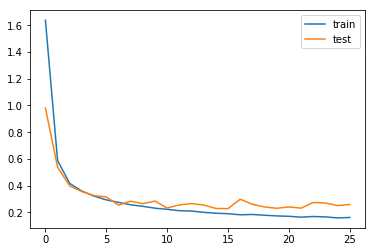

In [35]:
from matplotlib import pyplot
pyplot.plot(hist.history['loss'], label='train')
pyplot.plot(hist.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Save or Loading the best model

In [40]:
model.save('speechTotext_Model.hdf5')

In [42]:
from tensorflow.keras.models import load_model
model = load_model('speechTotext_Model.hdf5')

Define the function that predicts text for the given audio:

In [43]:
def s2t_predict(audio, shape_num=8000):
    prob=model.predict(audio.reshape(1,shape_num,1))
    index=np.argmax(prob[0])
    return classes[index]

Prediction time! Make predictions on the validation data:

In [45]:
import random
index=random.randint(0,len(x_valid)-1)
samples=x_valid[index].ravel()
print("Audio:",classes[np.argmax(y_valid[index])])
ipd.Audio(samples, rate=8000)

Audio: up


In [46]:
samples.shape

(8000,)

In [47]:
print("Text:",s2t_predict(samples))

Text: up


The best part is yet to come! Here is a script that prompts a user to record voice commands. Record your own voice commands and test it on the model:

Let us now read the saved voice command and convert it to text:

In [59]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [60]:
#reading the voice commands
test, test_rate = librosa.load('yes.wav', sr = 16000)
test_sample = librosa.resample(test, test_rate, 8000)
print(test_sample.shape)
ipd.Audio(test_sample,rate=8000)              

(8000,)


In [61]:
#converting voice commands to text
s2t_predict(test_sample)

'one'